In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cmath
from generateRIR import generate_stochasticRIR
import obspy.signal.filter as ob
from scipy import signal, stats
import control
from generate_StochasticRIR import generate_stochastic_rir
import torchsummary as ts
import torch.nn as nn
from torchviz import make_dot
from gen_freqRIR import generate_frequencyRIR
from generate_StochasticRIR2 import generate_stochastic_rir_del
from generate_data import generate_ism
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import timeit
from shoebox.firwin_torch import firwin_torch

# Load data

In [2]:
rir_np = np.load("./rirData/ism_14_new2.npy", allow_pickle=False)
rir_np.shape

(14, 96009)

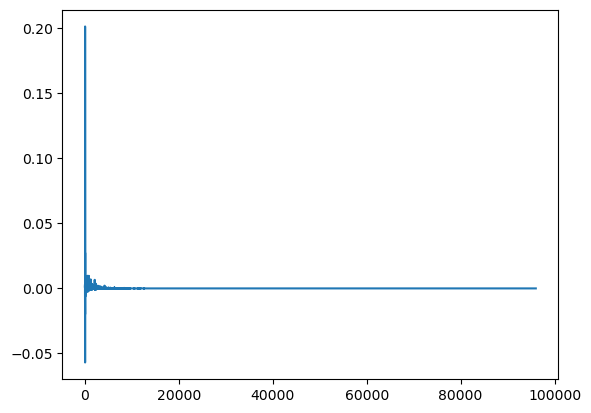

In [21]:
plt.plot((rir_np[10, 9:]))
# plt.yscale("log")

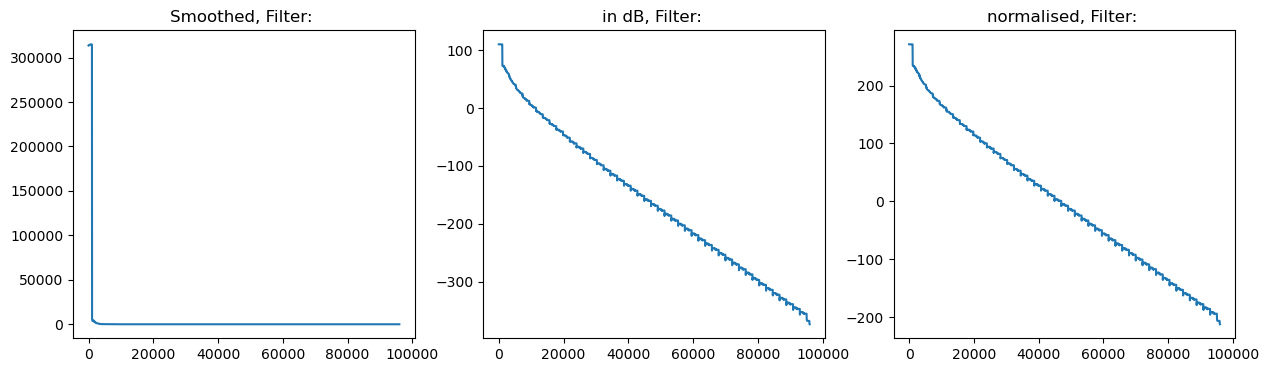

tensor([ 271.1315,  271.1315,  271.1316,  ..., -212.0582, -212.0647,
        -212.0738])

In [17]:
env_makerF(torch.tensor(rir_np[10,9:], dtype=torch.float), filter_len=2047, gain=100, normalise=True, display_plots=True)
# plt.yscale("log")

## Train model

In [29]:
# RIR model
class RIR_model(torch.nn.Module):
    def __init__(self, Kx=None, Ky=None, Kz=None, device='cpu') :
        super().__init__()
        if not [x for x in [Kx, Ky, Kz] if x is None]:
            self.Kx = torch.nn.Parameter(torch.tensor(Kx))
            self.Ky = torch.nn.Parameter(torch.tensor(Ky))
            self.Kz = torch.nn.Parameter(torch.tensor(Kz))            
        else:
            # Random Initialization
            self.Kx = torch.nn.Parameter(torch.randint(-200, -100, (1,)).float()*0.0001)
            self.Ky = torch.nn.Parameter(torch.randint(-200, -100, (1,)).float()*0.0001)
            self.Kz = torch.nn.Parameter(torch.randint(-200, -100, (1,)).float()*0.0001)
        
        # self.L1 = torch.nn.Parameter(torch.randint(3,8,(1,)).float())
        # self.L2 = torch.nn.Parameter(torch.randint(3,8,(1,)).float())
        # self.L3 = torch.nn.Parameter(torch.randint(3,8,(1,)).float())
        self.device = device
        

    def forward(self):
        # return generate_stochasticRIR(L=torch.cat((self.L1,self.L2,self.L3)))#.cuda()
        return generate_stochastic_rir(Kx=self.Kx, Ky=self.Ky, Kz=self.Kz, device=self.device)

In [3]:
# RIR model 2 - for delta_K
class RIR_model2(torch.nn.Module):
    def __init__(self,) : 
        super().__init__()
        self.kx = torch.randint(-200, -100, (1,)).float()*0.0001
        self.ky = torch.randint(-200, -100, (1,)).float()*0.0001
        self.kz = torch.randint(-200, -100, (1,)).float()*0.0001
        self.kes = torch.sort(torch.cat([self.kx.view(-1), self.ky.view(-1), self.kz.view(-1)]))[0]
        self.del_Kx = torch.nn.Parameter(self.kes[0])
        self.del_Ky = torch.nn.Parameter(self.kes[1] - self.kes[0])
        self.del_Kz = torch.nn.Parameter(self.kes[2] - self.kes[1])
        #self.del_Ky = torch.nn.Parameter()
    
        

    def forward(self):
        # return generate_stochasticRIR(L=torch.cat((self.L1,self.L2,self.L3)))#.cuda()
        return generate_stochastic_rir_del(del_Kx=self.del_Kx, del_Ky=self.del_Ky, del_Kz=self.del_Kz)

## Calculation for K's
### condition : $x<y<z$ &emsp;negative cond: $-x<-y<-z$
1. $xh = x$ &emsp; $xh$ and $x$ are both -ve
2. $yh = y-x$ &emsp; $y$ is -ve, $yh$ is +ve
3. $zh = z-y$&emsp; $zh$ is +ve $z$ is -ve  </br>
### backwards calculation:&emsp; backwards:
1. $x = xh$&emsp;  both -ve
2. $y = yh + x = yh + xh$ &emsp; $y = -yh + x = - yh - xh$
3. $z = zh + y = zh + xh + yh$&emsp; $z = -zh + y = -zh - xh - yh$ 


In [4]:
# check delta Ks
Kx=torch.tensor(-0.021)
Ky=torch.tensor(-0.016)
Kz=torch.tensor(-0.012)
kes = torch.sort(torch.cat([Kx.view(-1), Ky.view(-1), Kz.view(-1)]))[0]
print("sorted: ", kes)

del_Kx = kes[0]
del_Ky = kes[1] - kes[0]
del_Kz = kes[2] - kes[1]
print(f"del_Ks: x:{del_Kx}, y: {del_Ky}, z:{del_Kz}")


# del_Kx = torch.tensor(-0.0187)
# del_Ky = torch.tensor(0.0024)
# del_Kz = torch.tensor(0.0043)
Kx = del_Kx
Ky = del_Ky + del_Kx
Kz = del_Kz + del_Ky + del_Kx
print(f"x: {Kx}, y: {Ky}, z: {Kz}")

sorted:  tensor([-0.0210, -0.0160, -0.0120])
del_Ks: x:-0.020999999716877937, y: 0.004999998956918716, z:0.0040000006556510925
x: -0.020999999716877937, y: -0.01600000075995922, z: -0.012000000104308128


In [4]:
# separate RIR into Frequenc bands
def rir_bands(rir, f_center=None, fs=16000, device='cpu'):
    if not f_center:
        nBands = 6
        f_center = torch.zeros(nBands).to(device=device)
        f_center[0] = 125.0     # lowest octave band
        for it in range(1, nBands):
            f_center[it] =  2.0 * f_center[it-1]
    else:
        nBands = f_center.size(0)

    if nBands == 1:
        return rir
    else:
        # order of filters
        order = 1000
        filters = torch.zeros(order + 1, nBands).to(device=device)

        for i in range(nBands):
            if i == 0:
                fl = 30
                fh = (f_center[i] * f_center[i + 1]).sqrt()
                w = torch.tensor([fl / (fs / 2), fh / (fs / 2)]).to(device=device)
                filters[:, i] = firwin_torch(order + 1, w, pass_zero='bandpass', fs=fs, idx = i, device=device)
            elif i == nBands - 1:
                fl = (f_center[i] * f_center[i - 1]).sqrt()
                w = torch.tensor([fl / (fs / 2)]).to(device=device)
                filters[:, i] = firwin_torch(order + 1, w, pass_zero='highpass', fs=fs, idx = i, device=device)
            else:
                fl = (f_center[i] * f_center[i - 1]).sqrt()
                fh = (f_center[i] * f_center[i + 1]).sqrt()
                w = torch.tensor([fl / (fs / 2), fh / (fs / 2)]).to(device=device)
                filters[:, i] = firwin_torch(order + 1, w, pass_zero='bandpass', fs=fs, idx = i, device=device)
        # padding
        temp_rir = torch.cat([rir, torch.zeros(order).to(device=device)])

        rir_filt = torch.zeros(rir.size(0)).to(device=device)
        for j in range(nBands):
            xy = torch.nn.functional.conv1d(temp_rir.reshape(1, -1), filters[:, j].reshape(1,1,-1), stride=1, padding='valid', bias=None).squeeze()
            rir_filt = torch.vstack((rir_filt, xy))

        rir_filt = rir_filt[1:,:].T
            
        return rir_filt


In [5]:
ff = rir_bands(torch.tensor(rir_np[12,9:], dtype=torch.float))

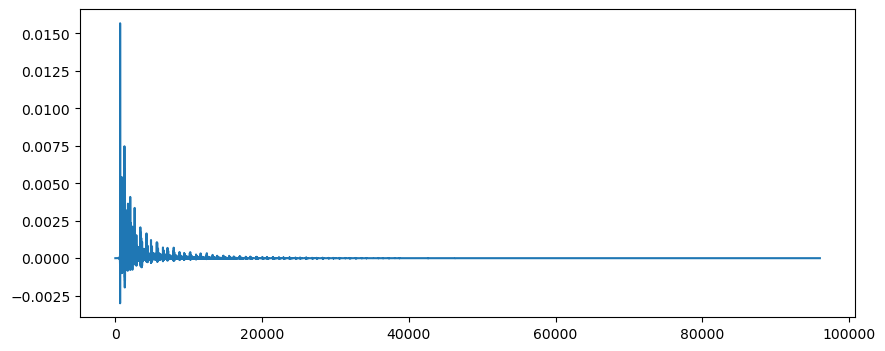

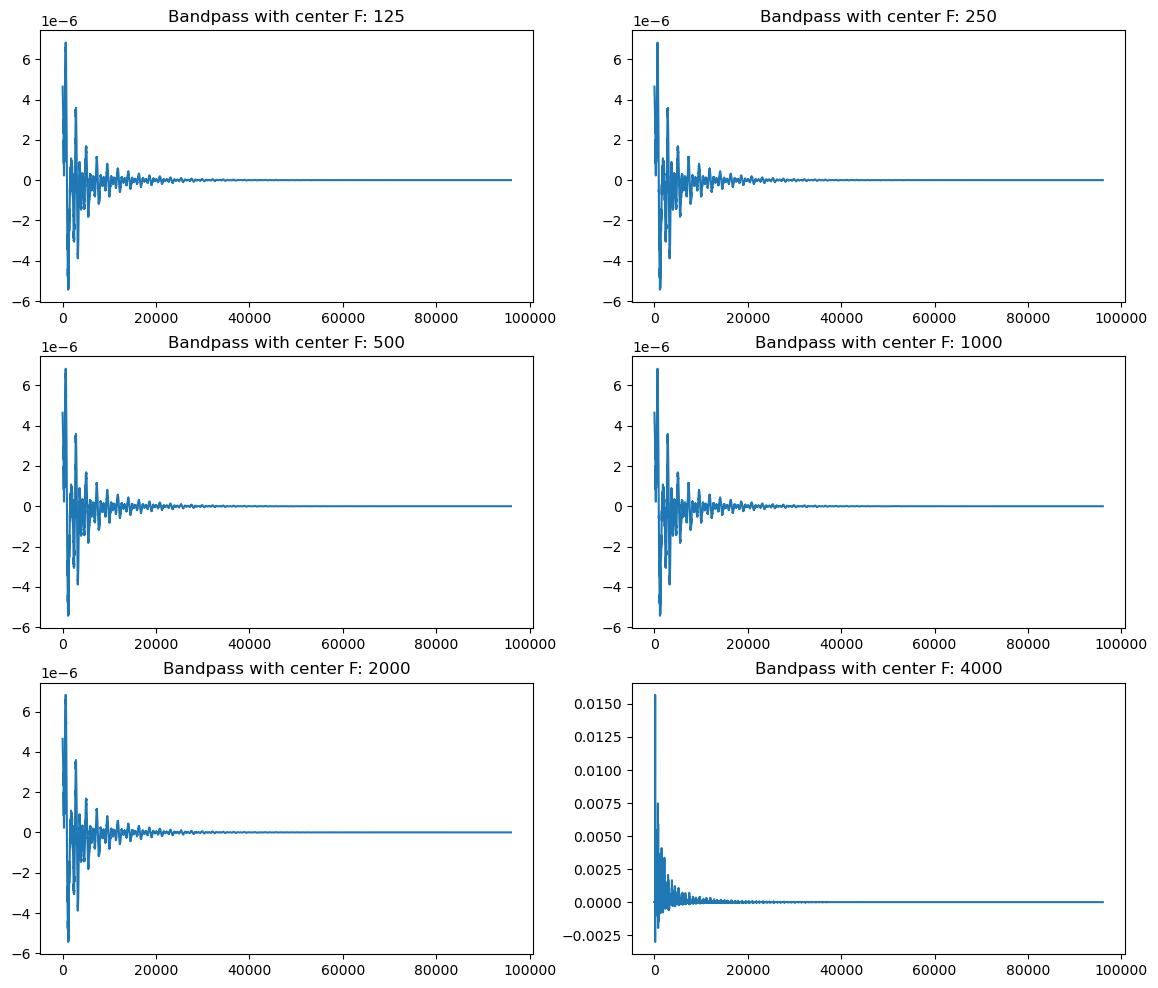

In [6]:
plt.figure(2, figsize=(10,4))
plt.plot(rir_np[12,9:])
plt.figure(1, figsize=(14,12))
fc = [125,250,500,1000,2000,4000]
for i in range(ff.size(1)):
    plt.subplot(3,2,i+1)
    plt.plot(ff[:, i])
    plt.title(f"Bandpass with center F: {fc[i]}")

In [8]:
# calculate Damping Coefficients
def calculate_K(betas, lengths):
    ''' 
    betas: a 6x1 array of all reflection coefficients
    lengths: 3x1 array of all wall measurements
    '''
    Kx = torch.log(torch.prod(betas[0:2])) / lengths[0]
    Ky = torch.log(torch.prod(betas[2:4])) / lengths[1]
    Kz = torch.log(torch.prod(betas[4:6])) / lengths[2]
    return Kx, Ky, Kz

In [26]:
# Env maker
def env_makerF(inp, filter_len=2047, gain=None, clip_=None, normalise=False, title_str = '', display_plots=False, device='cpu'):
    eps=2.2204e-16
    # Amplify
    # if inp.requires_grad : inp.register_hook(lambda x : print("inp: ", x[200:210],inp.grad_fn,inp.data[200:210], torch.any(torch.isnan(x))))
    if gain is not None:
        arr = inp * (10**(gain/20))
    else:
        arr = inp
    # if arr.requires_grad : arr.register_hook(lambda x : print("arr: ",x[200:210], arr.grad_fn,arr.data[200:210],torch.any(torch.isnan(x))))
    ## Main Evelope Block
    filter_= torch.ones(filter_len).to(device=device)
    filter_avg = filter_/torch.sum(filter_) # Avg filter
    sqq = arr**2    # Squaring for Power
    # Smoothing 
    smoothed = torch.nn.functional.conv1d(sqq.reshape(1,-1), filter_avg.reshape(1,1,-1), bias=None, stride=1, padding='same' ).reshape(-1,)
    # if smoothed.requires_grad : smoothed.register_hook(lambda x : print("smoothed: ",x[-10:], smoothed.grad_fn,smoothed.data[200:210], torch.any(torch.isnan(x))))
    sm2 = smoothed.clone() + eps
    # if sm2.requires_grad : sm2.register_hook(lambda x : print("sm2: ", x[-10:], sm2.grad_fn,sm2.data, torch.any(torch.isnan(x))))
    # if torch.any(sm2<=0) : print("negative in sm2",[it for it in sm2 if it<=0])
    in_db = mag2db(sm2)    # Convert to dB scale
    # if in_db.requires_grad : in_db.register_hook(lambda x : print("in_db: ", x,in_db.grad_fn,in_db.data, torch.any(torch.isnan(x))))

    # Clipping below -150/-100dB
    # if clip_ is not None:
    #     in_db2 = torch.clip(in_db, min=clip_)
    # else:
    #     in_db2 = in_db

    # normalise around zero
    if normalise:
        normalised = in_db - torch.mean(in_db)
    else:
        normalised = in_db
    # if normalised.requires_grad : normalised.register_hook(lambda x : print("normalised: ", x[:10], normalised.grad_fn,normalised.data[:10], torch.any(torch.isnan(x))))
    if clip_ is not None:
        clipped_db = torch.clip(normalised, min=clip_)
    else:
        clipped_db = normalised
    # Plot   
    if display_plots:
        if title_str == '':
            title_str = str(filter_len)
        title_switch = {
        # 1: "RIR",
        # 2: "Squared RIR",
        1: "Smoothed",
        2: "in dB", 
        3: "normalised" ,
        4: "clipped"}
        if device == 'cuda':
            normalised_c = normalised.clone()
            llist = [smoothed.detach().cpu(),in_db.detach().cpu() , normalised_c.detach().cpu(),clipped_db.detach().cpu()]
        else:
            llist = [smoothed, clipped_db, normalised]
        #
        plt.figure(figsize=(16,4))
        for i, it in enumerate(llist):
            plt.subplot(1,4,i+1)
            plt.plot(it)
            plt.title(title_switch[i+1]+", Filter: "+title_str)
        plt.show()
    
    return normalised

def mag2db(xcv):
    return 20 * xcv.log10_()

In [6]:
# Check Envelope
Kx=torch.tensor(-0.019)
Ky=torch.tensor( -0.018)
Kz=torch.tensor( -0.018)
Kx1=torch.tensor(-0.012)
Ky1=torch.tensor( -0.014)
Kz1=torch.tensor( -0.017)

labels = generate_stochastic_rir(Kx=Kx,Ky=Ky,Kz=Kz)
t = np.array([1,2,4,8,16,32]) * 128
labels1 = generate_stochastic_rir(Kx=Kx1,Ky=Ky1,Kz=Kz1)
labels2 = generate_stochastic_rir(Kx=Kx,Ky=Ky,Kz=Kz)


torch.float32


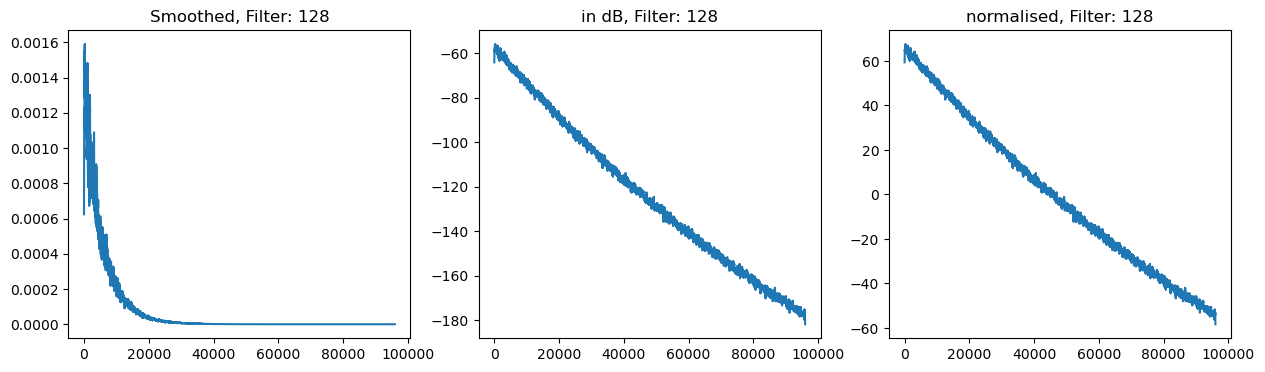

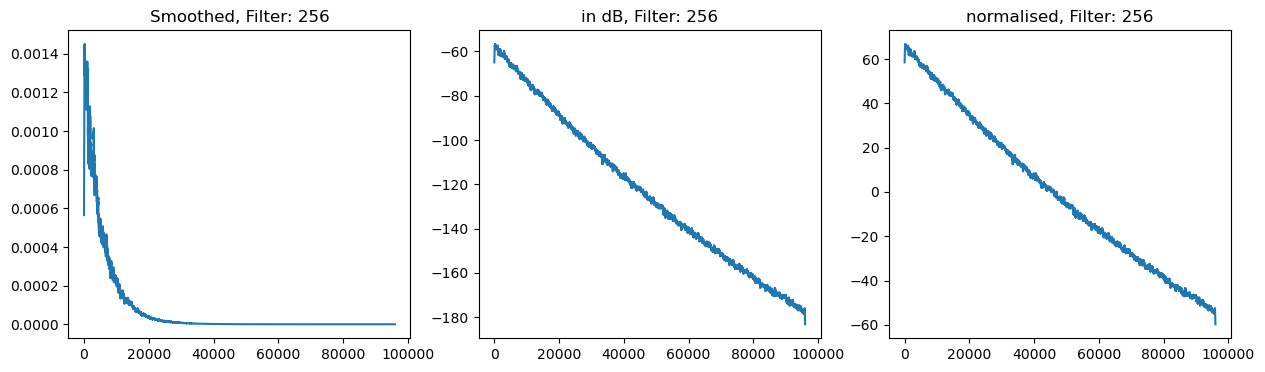

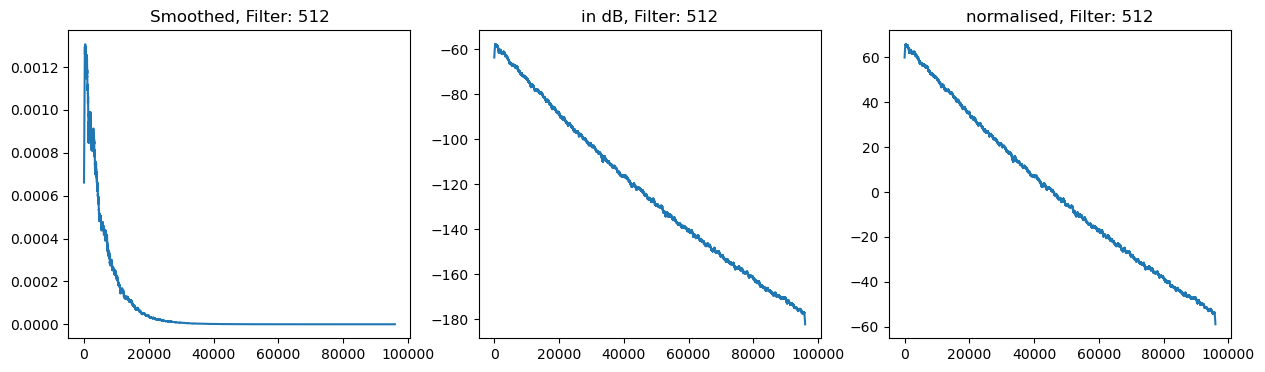

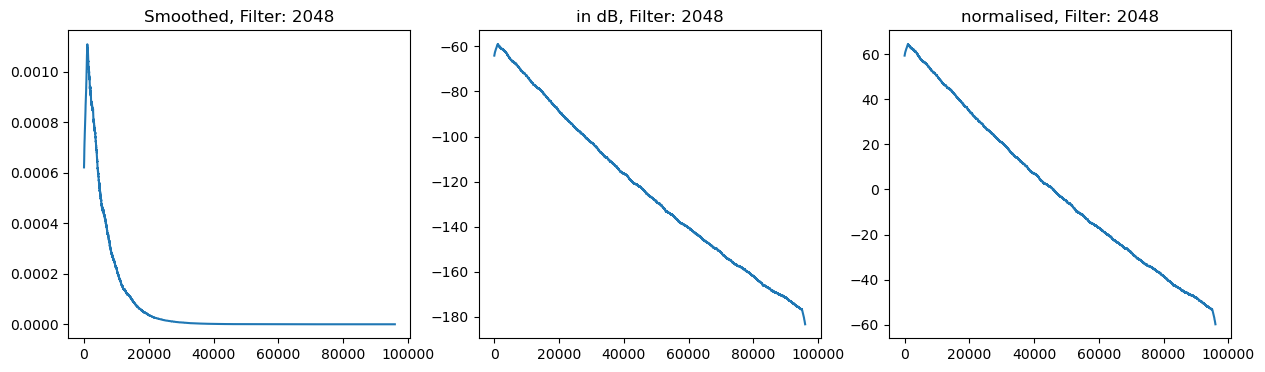

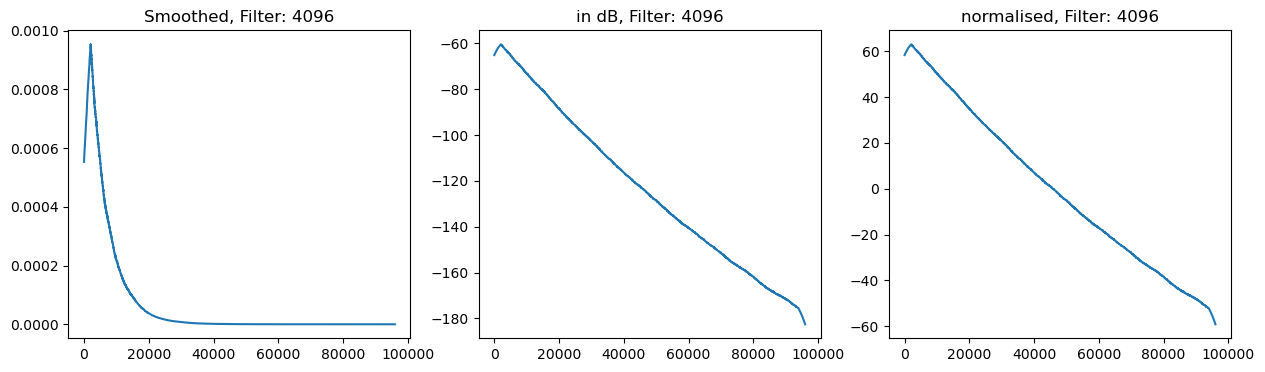

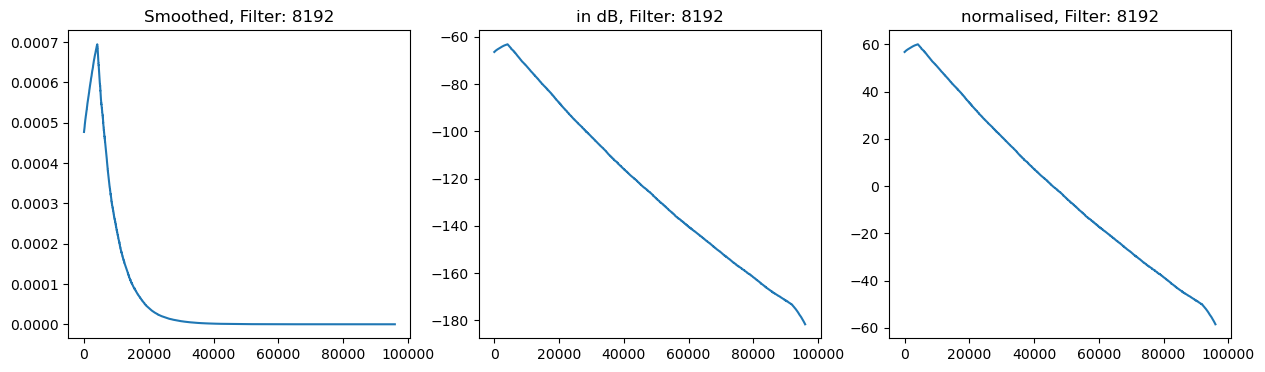

In [38]:
# Print Envelope for different filters
Kx=torch.tensor(-0.019)
Ky=torch.tensor(-0.021)
Kz=torch.tensor(-0.012)
labels = generate_stochastic_rir(Kx=Kx,Ky=Ky,Kz=Kz)
print(labels.dtype)
t = np.array([1,2,4,16, 32, 64])*128
for it in t:
    env_makerF(labels, it,  gain=None, title_str=str(it), display_plots=True, normalise=True)

-------------------1th Datapoint out of 14--------------------------
-----trial number: 1------- 
Target Kvalues for band1: (tensor(-0.0378, device='cuda:0'), tensor(-0.1362, device='cuda:0'), tensor(-0.2648, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1360], device='cuda:0')
Ky :  tensor([-0.1020], device='cuda:0')
Kz :  tensor([-0.1300], device='cuda:0')
Loss in epoch:0 is : 39.17827606201172
Loss in epoch:100 is : 4.0462846755981445
Loss in epoch:200 is : 4.121430397033691

RIR no:1,
Updated model Params:
Kx :  tensor([-0.1303], device='cuda:0')
Ky :  tensor([-0.0325], device='cuda:0')
Kz :  tensor([-0.1242], device='cuda:0')


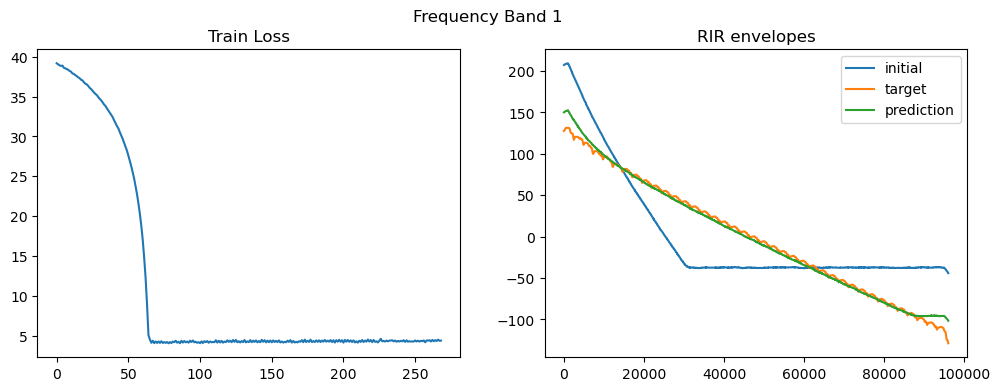

-----trial number: 1------- 
Target Kvalues for band2: (tensor(-0.0378, device='cuda:0'), tensor(-0.1362, device='cuda:0'), tensor(-0.2648, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1710], device='cuda:0')
Ky :  tensor([-0.1800], device='cuda:0')
Kz :  tensor([-0.1770], device='cuda:0')
Loss in epoch:0 is : 46.329925537109375
Loss in epoch:100 is : 45.678688049316406
Loss in epoch:200 is : 43.52616500854492
Loss in epoch:300 is : 35.96842575073242
Loss in epoch:400 is : 4.870794773101807

RIR no:2,
Updated model Params:
Kx :  tensor([-0.0320], device='cuda:0')
Ky :  tensor([-0.1776], device='cuda:0')
Kz :  tensor([-0.1729], device='cuda:0')


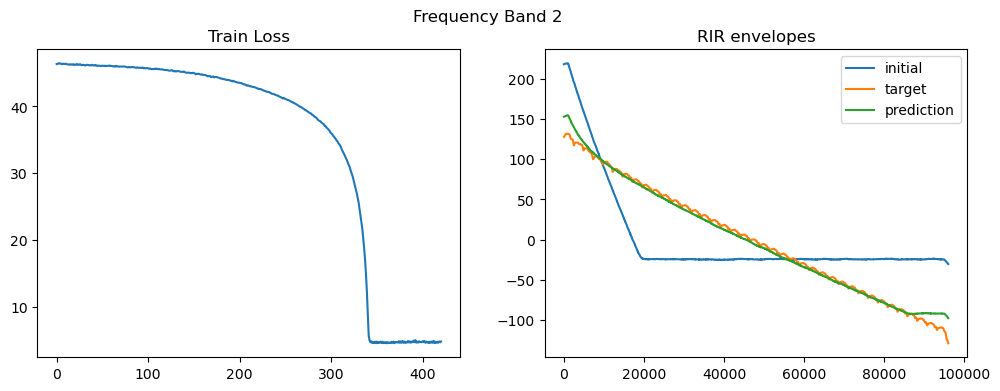

-----trial number: 1------- 
Target Kvalues for band3: (tensor(-0.0378, device='cuda:0'), tensor(-0.1362, device='cuda:0'), tensor(-0.2648, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1140], device='cuda:0')
Ky :  tensor([-0.1660], device='cuda:0')
Kz :  tensor([-0.1050], device='cuda:0')
Loss in epoch:0 is : 39.57112503051758
Loss in epoch:100 is : 4.399566173553467
Loss in epoch:200 is : 4.3382439613342285

RIR no:3,
Updated model Params:
Kx :  tensor([-0.1036], device='cuda:0')
Ky :  tensor([-0.1562], device='cuda:0')
Kz :  tensor([-0.0292], device='cuda:0')


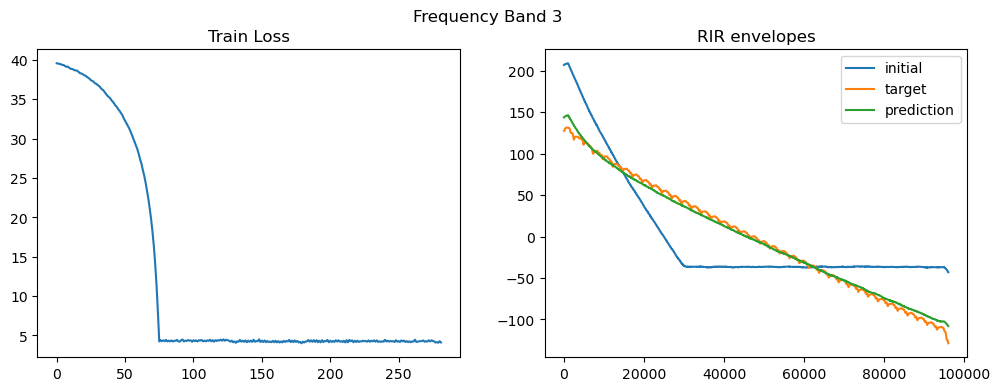

-----trial number: 1------- 
Target Kvalues for band4: (tensor(-0.0378, device='cuda:0'), tensor(-0.1362, device='cuda:0'), tensor(-0.2648, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1700], device='cuda:0')
Ky :  tensor([-0.1810], device='cuda:0')
Kz :  tensor([-0.1320], device='cuda:0')
Loss in epoch:0 is : 43.48615264892578
Loss in epoch:100 is : 36.077659606933594
Loss in epoch:200 is : 4.856616973876953
Loss in epoch:300 is : 4.690650939941406

RIR no:4,
Updated model Params:
Kx :  tensor([-0.1681], device='cuda:0')
Ky :  tensor([-0.1794], device='cuda:0')
Kz :  tensor([-0.0291], device='cuda:0')


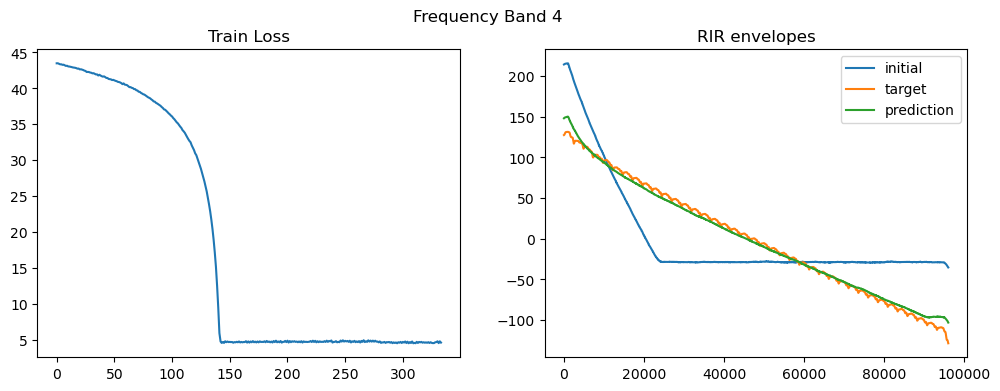

-----trial number: 1------- 
Target Kvalues for band5: (tensor(-0.0378, device='cuda:0'), tensor(-0.1362, device='cuda:0'), tensor(-0.2648, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1570], device='cuda:0')
Ky :  tensor([-0.1110], device='cuda:0')
Kz :  tensor([-0.1430], device='cuda:0')
Loss in epoch:0 is : 40.622833251953125
Loss in epoch:100 is : 4.411326885223389
Loss in epoch:200 is : 4.510421276092529

RIR no:5,
Updated model Params:
Kx :  tensor([-0.1570], device='cuda:0')
Ky :  tensor([-0.0323], device='cuda:0')
Kz :  tensor([-0.1423], device='cuda:0')


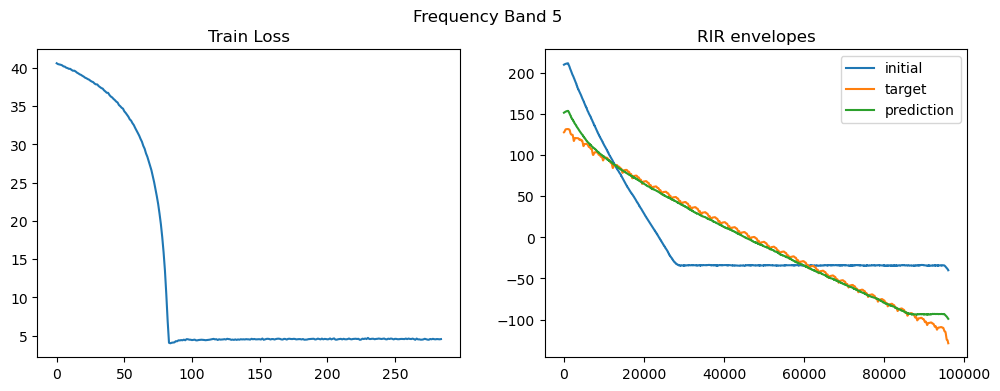

-----trial number: 1------- 
Target Kvalues for band6: (tensor(-0.0378, device='cuda:0'), tensor(-0.1362, device='cuda:0'), tensor(-0.2648, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1420], device='cuda:0')
Ky :  tensor([-0.1520], device='cuda:0')
Kz :  tensor([-0.1410], device='cuda:0')
Loss in epoch:0 is : 43.123558044433594
Loss in epoch:100 is : 40.919189453125
Loss in epoch:200 is : 28.40178680419922
Loss in epoch:300 is : 3.4598166942596436

RIR no:6,
Updated model Params:
Kx :  tensor([-0.1148], device='cuda:0')
Ky :  tensor([-0.1500], device='cuda:0')
Kz :  tensor([-0.0333], device='cuda:0')


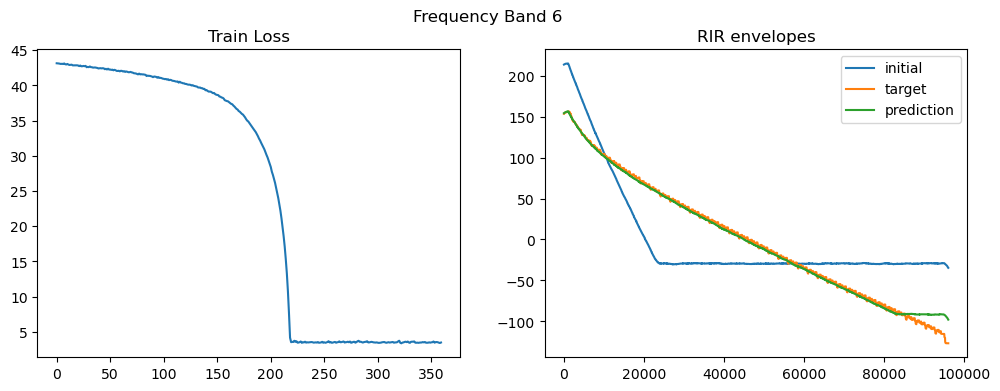

-------------------2th Datapoint out of 14--------------------------
-----trial number: 1------- 
Target Kvalues for band1: (tensor(-0.0209, device='cuda:0'), tensor(-0.1356, device='cuda:0'), tensor(-0.2211, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1230], device='cuda:0')
Ky :  tensor([-0.1310], device='cuda:0')
Kz :  tensor([-0.1880], device='cuda:0')
Loss in epoch:0 is : 31.792627334594727
Loss in epoch:100 is : 31.066713333129883
Loss in epoch:200 is : 30.812185287475586

RIR no:1,
Updated model Params:
Kx :  tensor([-0.1420], device='cuda:0')
Ky :  tensor([-0.1537], device='cuda:0')
Kz :  tensor([-0.1979], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band1: (tensor(-0.0209, device='cuda:0'), tensor(-0.1356, device='cuda:0'), tensor(-0.2211, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1260], device='cuda:0')
Ky :  tensor([-0.1980], device='cuda:0')
Kz :  tensor([-0.1940], device='cuda:0')
Loss in epoch:0 is : 30.45953941345215
Loss i

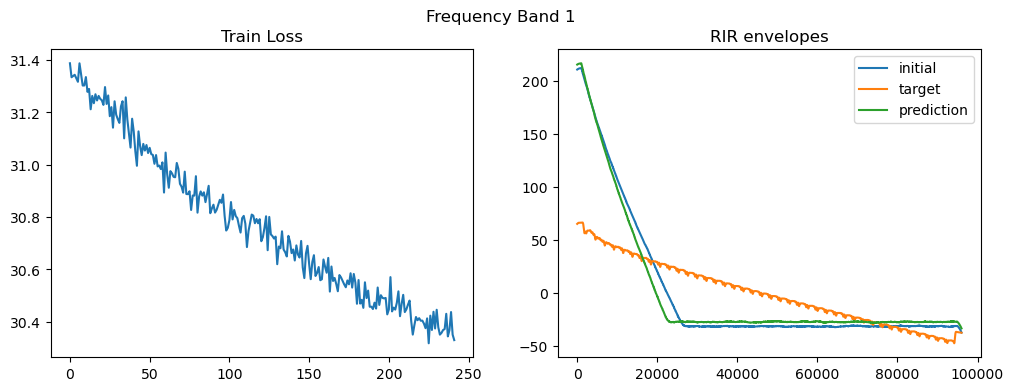

-----trial number: 1------- 
Target Kvalues for band2: (tensor(-0.0209, device='cuda:0'), tensor(-0.1356, device='cuda:0'), tensor(-0.2211, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1940], device='cuda:0')
Ky :  tensor([-0.1330], device='cuda:0')
Kz :  tensor([-0.1100], device='cuda:0')
Loss in epoch:0 is : 32.14213943481445
Loss in epoch:100 is : 31.30242347717285
Loss in epoch:200 is : 30.86984634399414

RIR no:2,
Updated model Params:
Kx :  tensor([-0.2037], device='cuda:0')
Ky :  tensor([-0.1552], device='cuda:0')
Kz :  tensor([-0.1341], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band2: (tensor(-0.0209, device='cuda:0'), tensor(-0.1356, device='cuda:0'), tensor(-0.2211, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1600], device='cuda:0')
Ky :  tensor([-0.1810], device='cuda:0')
Kz :  tensor([-0.1660], device='cuda:0')
Loss in epoch:0 is : 30.222780227661133
Loss in epoch:100 is : 30.060962677001953
Loss in epoch:200 is : 29.937156677

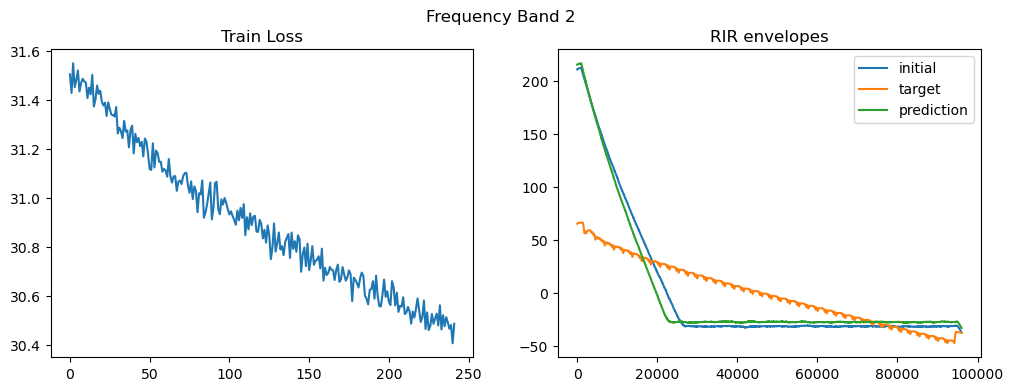

-----trial number: 1------- 
Target Kvalues for band3: (tensor(-0.0209, device='cuda:0'), tensor(-0.1356, device='cuda:0'), tensor(-0.2211, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1880], device='cuda:0')
Ky :  tensor([-0.1650], device='cuda:0')
Kz :  tensor([-0.1750], device='cuda:0')
Loss in epoch:0 is : 30.032875061035156
Loss in epoch:100 is : 29.843446731567383
Loss in epoch:200 is : 29.73876190185547

RIR no:3,
Updated model Params:
Kx :  tensor([-0.1981], device='cuda:0')
Ky :  tensor([-0.1727], device='cuda:0')
Kz :  tensor([-0.1864], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band3: (tensor(-0.0209, device='cuda:0'), tensor(-0.1356, device='cuda:0'), tensor(-0.2211, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1890], device='cuda:0')
Ky :  tensor([-0.1110], device='cuda:0')
Kz :  tensor([-0.1690], device='cuda:0')
Loss in epoch:0 is : 31.42685890197754
Loss in epoch:100 is : 30.712770462036133
Loss in epoch:200 is : 30.33208274

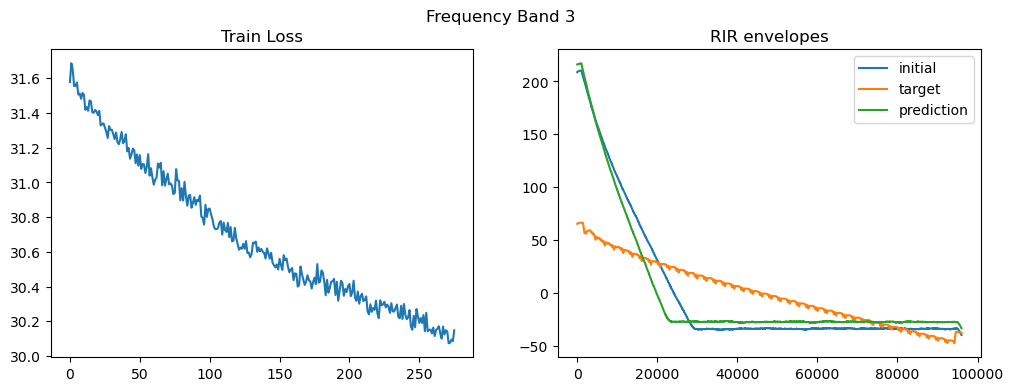

-----trial number: 1------- 
Target Kvalues for band4: (tensor(-0.0209, device='cuda:0'), tensor(-0.1356, device='cuda:0'), tensor(-0.2211, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1650], device='cuda:0')
Ky :  tensor([-0.1630], device='cuda:0')
Kz :  tensor([-0.1030], device='cuda:0')
Loss in epoch:0 is : 32.206974029541016
Loss in epoch:100 is : 31.286611557006836
Loss in epoch:200 is : 30.7573299407959

RIR no:4,
Updated model Params:
Kx :  tensor([-0.1786], device='cuda:0')
Ky :  tensor([-0.1770], device='cuda:0')
Kz :  tensor([-0.1348], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band4: (tensor(-0.0209, device='cuda:0'), tensor(-0.1356, device='cuda:0'), tensor(-0.2211, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1490], device='cuda:0')
Ky :  tensor([-0.1790], device='cuda:0')
Kz :  tensor([-0.1840], device='cuda:0')
Loss in epoch:0 is : 30.184171676635742
Loss in epoch:100 is : 29.90082550048828
Loss in epoch:200 is : 29.803634643

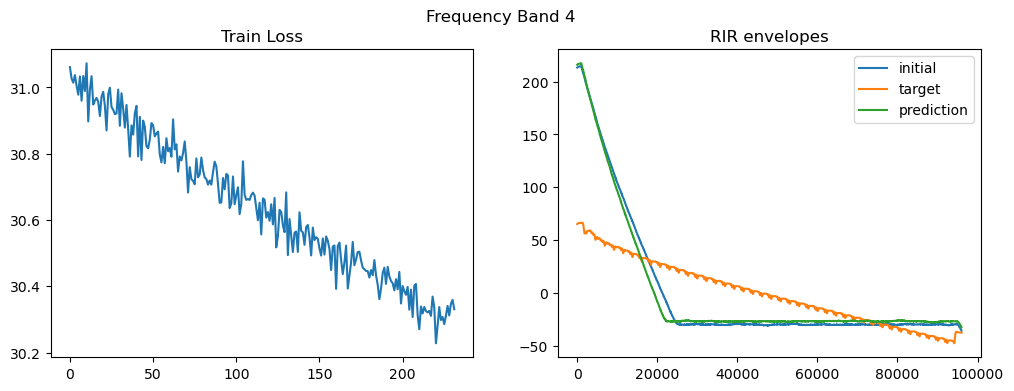

-----trial number: 1------- 
Target Kvalues for band5: (tensor(-0.0209, device='cuda:0'), tensor(-0.1356, device='cuda:0'), tensor(-0.2211, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1780], device='cuda:0')
Ky :  tensor([-0.1310], device='cuda:0')
Kz :  tensor([-0.1770], device='cuda:0')
Loss in epoch:0 is : 30.61087989807129
Loss in epoch:100 is : 30.30790138244629
Loss in epoch:200 is : 30.08926773071289

RIR no:5,
Updated model Params:
Kx :  tensor([-0.1886], device='cuda:0')
Ky :  tensor([-0.1481], device='cuda:0')
Kz :  tensor([-0.1876], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band5: (tensor(-0.0209, device='cuda:0'), tensor(-0.1356, device='cuda:0'), tensor(-0.2211, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1890], device='cuda:0')
Ky :  tensor([-0.1570], device='cuda:0')
Kz :  tensor([-0.1260], device='cuda:0')
Loss in epoch:0 is : 30.918418884277344
Loss in epoch:100 is : 30.572111129760742
Loss in epoch:200 is : 30.314994812

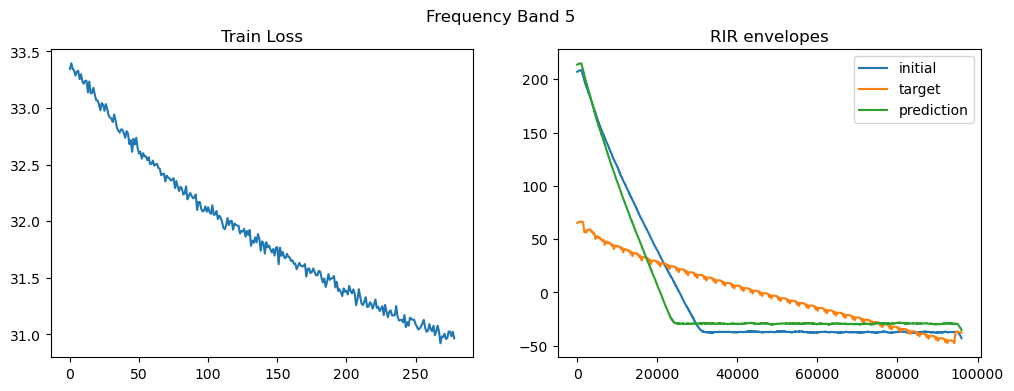

-----trial number: 1------- 
Target Kvalues for band6: (tensor(-0.0209, device='cuda:0'), tensor(-0.1356, device='cuda:0'), tensor(-0.2211, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1530], device='cuda:0')
Ky :  tensor([-0.1110], device='cuda:0')
Kz :  tensor([-0.1970], device='cuda:0')
Loss in epoch:0 is : 29.169193267822266
Loss in epoch:100 is : 28.952198028564453
Loss in epoch:200 is : 28.71750259399414

RIR no:6,
Updated model Params:
Kx :  tensor([-0.1648], device='cuda:0')
Ky :  tensor([-0.1222], device='cuda:0')
Kz :  tensor([-0.2045], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band6: (tensor(-0.0209, device='cuda:0'), tensor(-0.1356, device='cuda:0'), tensor(-0.2211, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1870], device='cuda:0')
Ky :  tensor([-0.1460], device='cuda:0')
Kz :  tensor([-0.1980], device='cuda:0')
Loss in epoch:0 is : 28.297718048095703
Loss in epoch:100 is : 28.490646362304688
Loss in epoch:200 is : 28.4281330

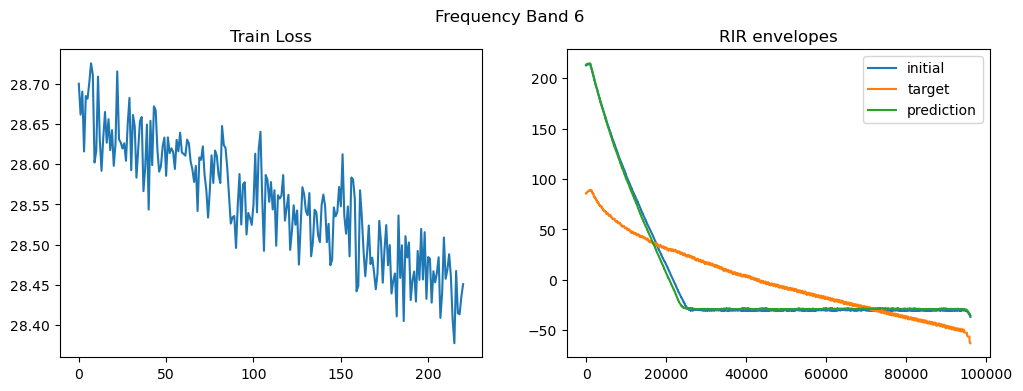

-------------------3th Datapoint out of 14--------------------------
-----trial number: 1------- 
Target Kvalues for band1: (tensor(-0.2197, device='cuda:0'), tensor(-0.1651, device='cuda:0'), tensor(-0.1865, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1350], device='cuda:0')
Ky :  tensor([-0.1010], device='cuda:0')
Kz :  tensor([-0.1570], device='cuda:0')
Loss in epoch:0 is : 24.71723747253418
Loss in epoch:100 is : 10.522022247314453
Loss in epoch:200 is : 10.056903839111328

RIR no:1,
Updated model Params:
Kx :  tensor([-0.0923], device='cuda:0')
Ky :  tensor([-0.0659], device='cuda:0')
Kz :  tensor([-0.1197], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band1: (tensor(-0.2197, device='cuda:0'), tensor(-0.1651, device='cuda:0'), tensor(-0.1865, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1890], device='cuda:0')
Ky :  tensor([-0.1650], device='cuda:0')
Kz :  tensor([-0.1790], device='cuda:0')
Loss in epoch:0 is : 40.223793029785156
Loss i

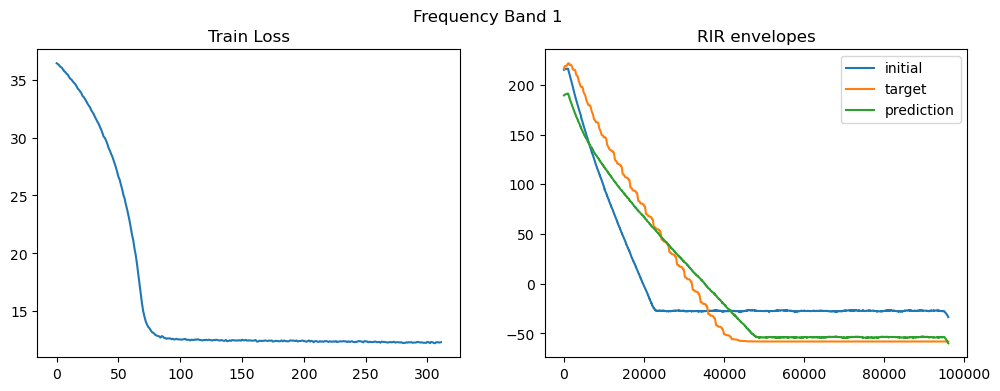

-----trial number: 1------- 
Target Kvalues for band2: (tensor(-0.2197, device='cuda:0'), tensor(-0.1651, device='cuda:0'), tensor(-0.1865, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1700], device='cuda:0')
Ky :  tensor([-0.1350], device='cuda:0')
Kz :  tensor([-0.1400], device='cuda:0')
Loss in epoch:0 is : 33.612186431884766
Loss in epoch:100 is : 11.159503936767578
Loss in epoch:200 is : 10.810032844543457
Loss in epoch:300 is : 10.439766883850098

RIR no:2,
Updated model Params:
Kx :  tensor([-0.1475], device='cuda:0')
Ky :  tensor([-0.0642], device='cuda:0')
Kz :  tensor([-0.1034], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band2: (tensor(-0.2197, device='cuda:0'), tensor(-0.1651, device='cuda:0'), tensor(-0.1865, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1290], device='cuda:0')
Ky :  tensor([-0.1420], device='cuda:0')
Kz :  tensor([-0.1020], device='cuda:0')
Loss in epoch:0 is : 24.6475830078125
Loss in epoch:100 is : 10.52923297

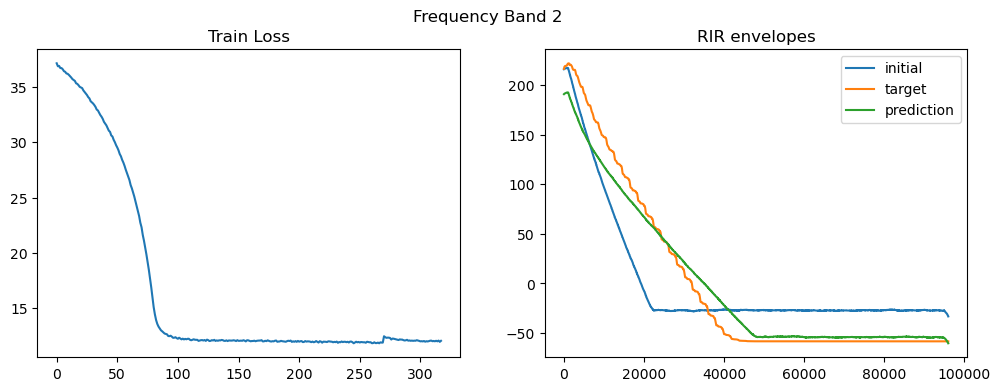

-----trial number: 1------- 
Target Kvalues for band3: (tensor(-0.2197, device='cuda:0'), tensor(-0.1651, device='cuda:0'), tensor(-0.1865, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1880], device='cuda:0')
Ky :  tensor([-0.1340], device='cuda:0')
Kz :  tensor([-0.1540], device='cuda:0')
Loss in epoch:0 is : 34.59939193725586
Loss in epoch:100 is : 11.85419750213623
Loss in epoch:200 is : 11.639466285705566
Loss in epoch:300 is : 11.437898635864258

RIR no:3,
Updated model Params:
Kx :  tensor([-0.1704], device='cuda:0')
Ky :  tensor([-0.0623], device='cuda:0')
Kz :  tensor([-0.1310], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band3: (tensor(-0.2197, device='cuda:0'), tensor(-0.1651, device='cuda:0'), tensor(-0.1865, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1640], device='cuda:0')
Ky :  tensor([-0.1110], device='cuda:0')
Kz :  tensor([-0.1860], device='cuda:0')
Loss in epoch:0 is : 29.351869583129883
Loss in epoch:100 is : 11.95237255

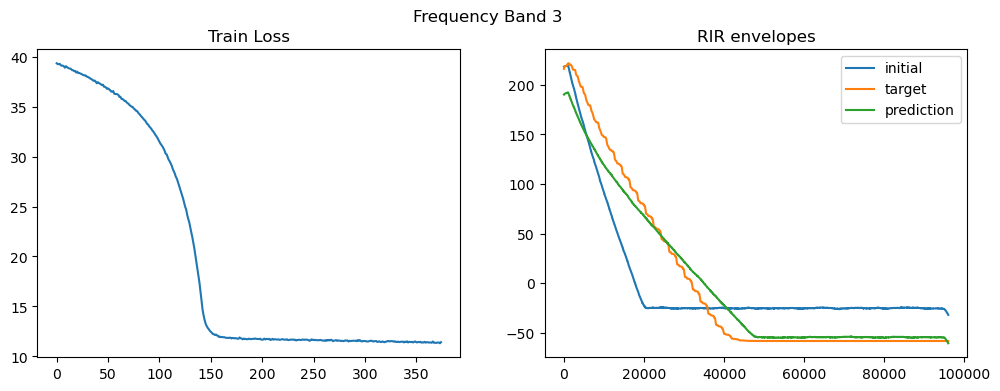

-----trial number: 1------- 
Target Kvalues for band4: (tensor(-0.2197, device='cuda:0'), tensor(-0.1651, device='cuda:0'), tensor(-0.1865, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1300], device='cuda:0')
Ky :  tensor([-0.1270], device='cuda:0')
Kz :  tensor([-0.1310], device='cuda:0')
Loss in epoch:0 is : 29.747413635253906
Loss in epoch:100 is : 9.918510437011719
Loss in epoch:200 is : 9.131670951843262
Loss in epoch:300 is : 7.421204566955566

RIR no:4,
Updated model Params:
Kx :  tensor([-0.0790], device='cuda:0')
Ky :  tensor([-0.0788], device='cuda:0')
Kz :  tensor([-0.0807], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band4: (tensor(-0.2197, device='cuda:0'), tensor(-0.1651, device='cuda:0'), tensor(-0.1865, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1750], device='cuda:0')
Ky :  tensor([-0.1360], device='cuda:0')
Kz :  tensor([-0.1490], device='cuda:0')
Loss in epoch:0 is : 34.44379806518555
Loss in epoch:100 is : 11.5518341064

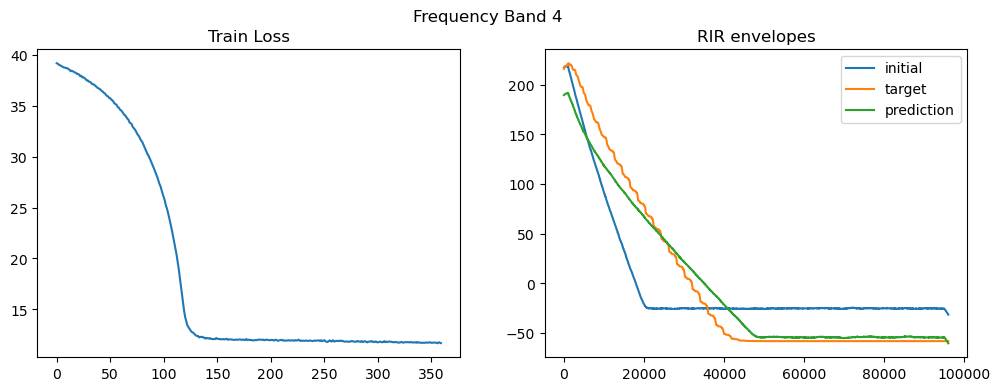

-----trial number: 1------- 
Target Kvalues for band5: (tensor(-0.2197, device='cuda:0'), tensor(-0.1651, device='cuda:0'), tensor(-0.1865, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1890], device='cuda:0')
Ky :  tensor([-0.1930], device='cuda:0')
Kz :  tensor([-0.1100], device='cuda:0')
Loss in epoch:0 is : 30.08112907409668
Loss in epoch:100 is : 12.446187019348145
Loss in epoch:200 is : 12.30078411102295

RIR no:5,
Updated model Params:
Kx :  tensor([-0.1752], device='cuda:0')
Ky :  tensor([-0.1794], device='cuda:0')
Kz :  tensor([-0.0597], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band5: (tensor(-0.2197, device='cuda:0'), tensor(-0.1651, device='cuda:0'), tensor(-0.1865, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1670], device='cuda:0')
Ky :  tensor([-0.1870], device='cuda:0')
Kz :  tensor([-0.1980], device='cuda:0')
Loss in epoch:0 is : 40.81617736816406
Loss in epoch:100 is : 30.938291549682617
Loss in epoch:200 is : 12.356278419

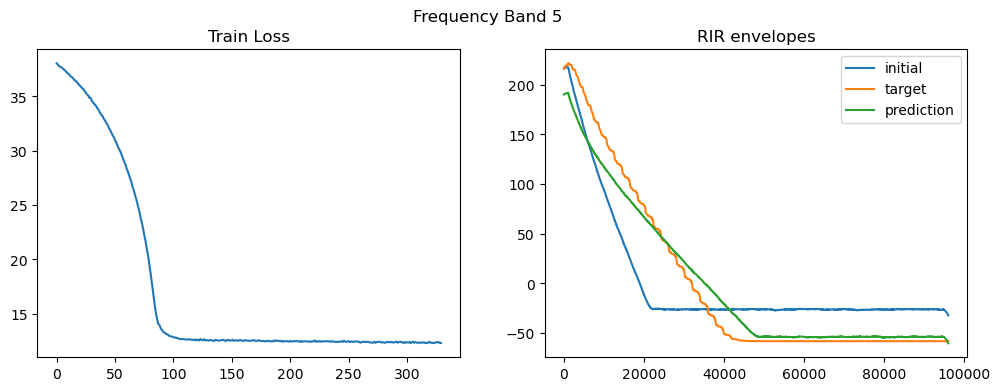

-----trial number: 1------- 
Target Kvalues for band6: (tensor(-0.2197, device='cuda:0'), tensor(-0.1651, device='cuda:0'), tensor(-0.1865, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1120], device='cuda:0')
Ky :  tensor([-0.1270], device='cuda:0')
Kz :  tensor([-0.1470], device='cuda:0')
Loss in epoch:0 is : 62.876617431640625
Loss in epoch:100 is : 37.873775482177734
Loss in epoch:200 is : 38.165618896484375

RIR no:6,
Updated model Params:
Kx :  tensor([-0.0505], device='cuda:0')
Ky :  tensor([-0.1147], device='cuda:0')
Kz :  tensor([-0.1429], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band6: (tensor(-0.2197, device='cuda:0'), tensor(-0.1651, device='cuda:0'), tensor(-0.1865, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1640], device='cuda:0')
Ky :  tensor([-0.1420], device='cuda:0')
Kz :  tensor([-0.1030], device='cuda:0')
Loss in epoch:0 is : 61.64119338989258
Loss in epoch:100 is : 38.553932189941406
Loss in epoch:200 is : 38.4435882

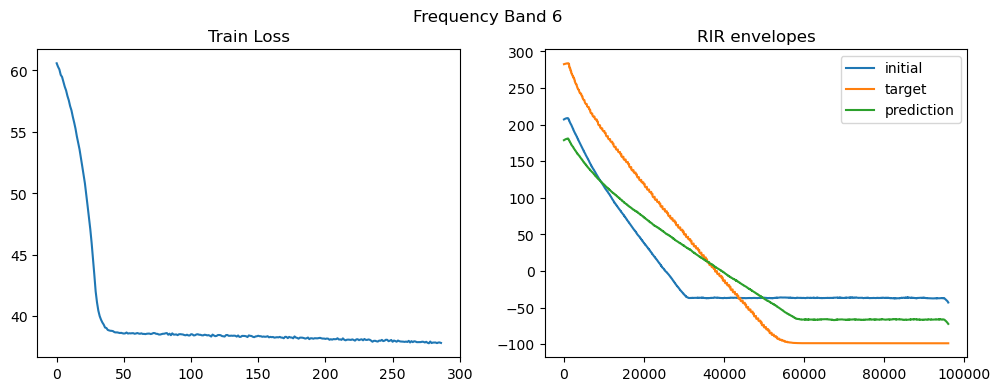

-------------------4th Datapoint out of 14--------------------------
-----trial number: 1------- 
Target Kvalues for band1: (tensor(-0.0903, device='cuda:0'), tensor(-0.1521, device='cuda:0'), tensor(-0.0665, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1360], device='cuda:0')
Ky :  tensor([-0.1140], device='cuda:0')
Kz :  tensor([-0.1710], device='cuda:0')
Loss in epoch:0 is : 36.21281814575195
Loss in epoch:100 is : 31.100250244140625
Loss in epoch:200 is : 3.850606679916382
Loss in epoch:300 is : 3.842179536819458

RIR no:1,
Updated model Params:
Kx :  tensor([-0.1407], device='cuda:0')
Ky :  tensor([-0.0227], device='cuda:0')
Kz :  tensor([-0.1747], device='cuda:0')


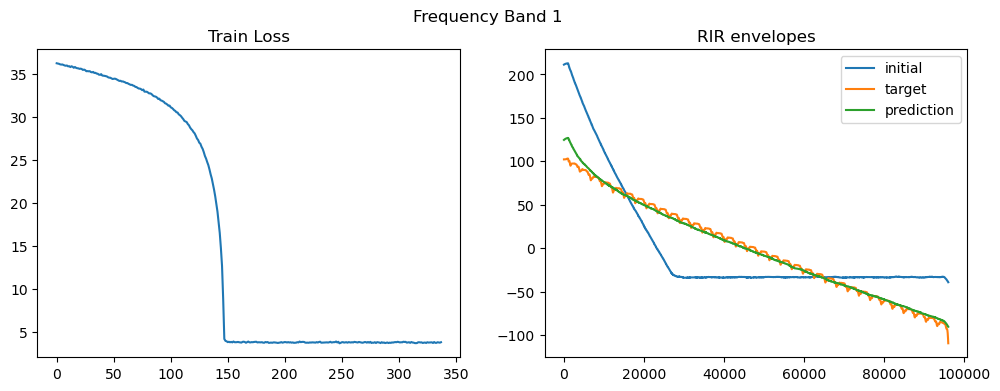

-----trial number: 1------- 
Target Kvalues for band2: (tensor(-0.0903, device='cuda:0'), tensor(-0.1521, device='cuda:0'), tensor(-0.0665, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1650], device='cuda:0')
Ky :  tensor([-0.1250], device='cuda:0')
Kz :  tensor([-0.1460], device='cuda:0')
Loss in epoch:0 is : 36.97188949584961
Loss in epoch:100 is : 34.20467758178711
Loss in epoch:200 is : 3.8094842433929443
Loss in epoch:300 is : 3.7095773220062256

RIR no:2,
Updated model Params:
Kx :  tensor([-0.1705], device='cuda:0')
Ky :  tensor([-0.0234], device='cuda:0')
Kz :  tensor([-0.1521], device='cuda:0')


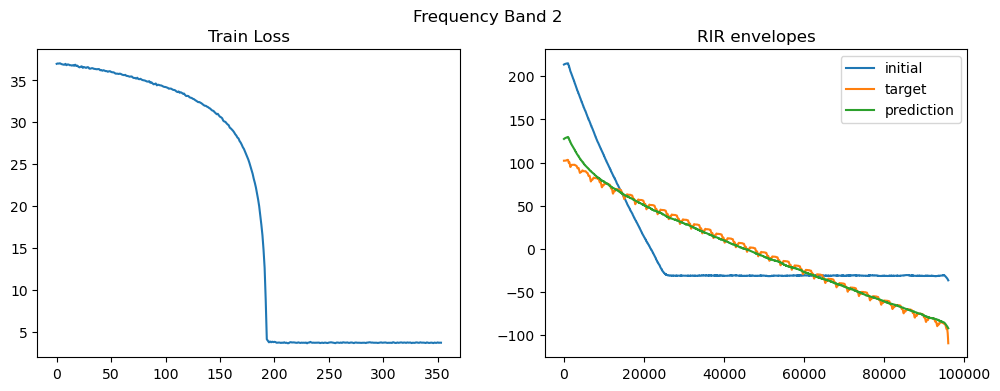

-----trial number: 1------- 
Target Kvalues for band3: (tensor(-0.0903, device='cuda:0'), tensor(-0.1521, device='cuda:0'), tensor(-0.0665, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1870], device='cuda:0')
Ky :  tensor([-0.1810], device='cuda:0')
Kz :  tensor([-0.1610], device='cuda:0')
Loss in epoch:0 is : 39.051414489746094
Loss in epoch:100 is : 38.35756301879883
Loss in epoch:200 is : 37.04732894897461
Loss in epoch:300 is : 34.03296661376953
Loss in epoch:400 is : 3.7721457481384277

RIR no:3,
Updated model Params:
Kx :  tensor([-0.1859], device='cuda:0')
Ky :  tensor([-0.1800], device='cuda:0')
Kz :  tensor([-0.0221], device='cuda:0')


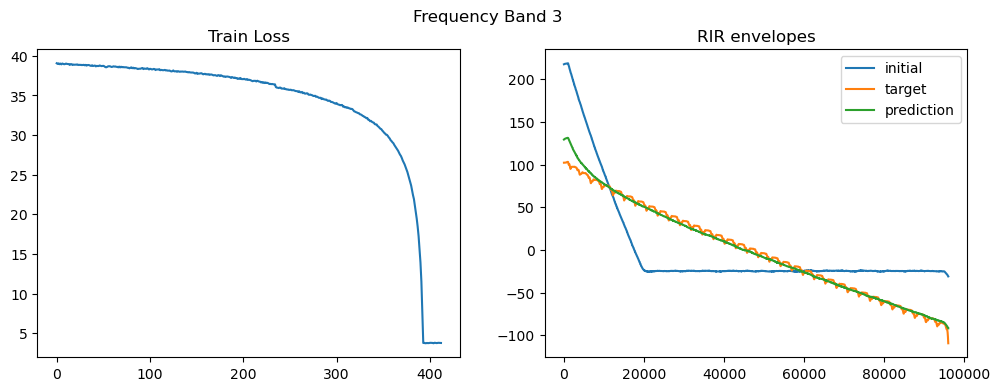

-----trial number: 1------- 
Target Kvalues for band4: (tensor(-0.0903, device='cuda:0'), tensor(-0.1521, device='cuda:0'), tensor(-0.0665, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1180], device='cuda:0')
Ky :  tensor([-0.1730], device='cuda:0')
Kz :  tensor([-0.1860], device='cuda:0')
Loss in epoch:0 is : 36.215126037597656
Loss in epoch:100 is : 32.372764587402344
Loss in epoch:200 is : 3.763275623321533
Loss in epoch:300 is : 3.860280990600586

RIR no:4,
Updated model Params:
Kx :  tensor([-0.0228], device='cuda:0')
Ky :  tensor([-0.1764], device='cuda:0')
Kz :  tensor([-0.1892], device='cuda:0')


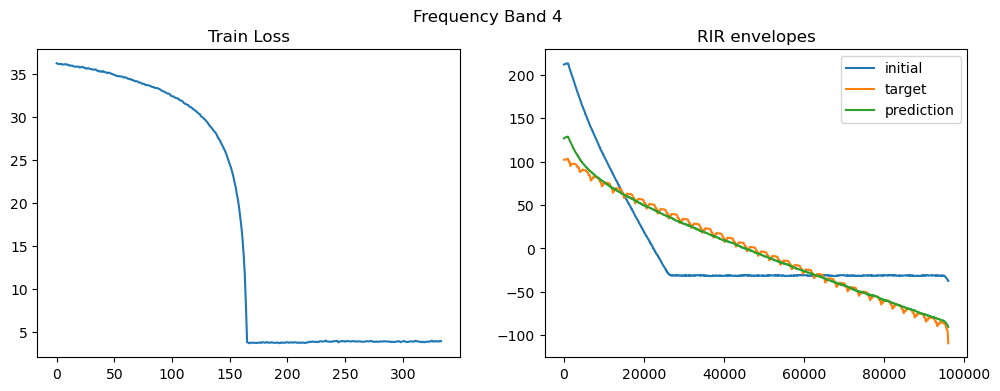

-----trial number: 1------- 
Target Kvalues for band5: (tensor(-0.0903, device='cuda:0'), tensor(-0.1521, device='cuda:0'), tensor(-0.0665, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1830], device='cuda:0')
Ky :  tensor([-0.1960], device='cuda:0')
Kz :  tensor([-0.1530], device='cuda:0')
Loss in epoch:0 is : 38.56397247314453
Loss in epoch:100 is : 37.751808166503906
Loss in epoch:200 is : 35.81455612182617
Loss in epoch:300 is : 31.398927688598633
Loss in epoch:400 is : 3.729037046432495

RIR no:5,
Updated model Params:
Kx :  tensor([-0.1888], device='cuda:0')
Ky :  tensor([-0.2013], device='cuda:0')
Kz :  tensor([-0.0222], device='cuda:0')


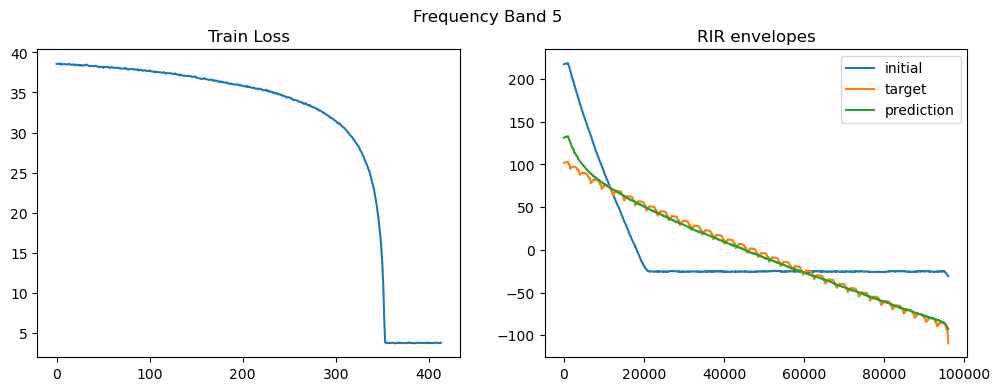

-----trial number: 1------- 
Target Kvalues for band6: (tensor(-0.0903, device='cuda:0'), tensor(-0.1521, device='cuda:0'), tensor(-0.0665, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1440], device='cuda:0')
Ky :  tensor([-0.1270], device='cuda:0')
Kz :  tensor([-0.1310], device='cuda:0')
Loss in epoch:0 is : 34.97884750366211
Loss in epoch:100 is : 32.16500473022461
Loss in epoch:200 is : 3.2476654052734375
Loss in epoch:300 is : 3.351069688796997

RIR no:6,
Updated model Params:
Kx :  tensor([-0.1491], device='cuda:0')
Ky :  tensor([-0.0265], device='cuda:0')
Kz :  tensor([-0.1334], device='cuda:0')


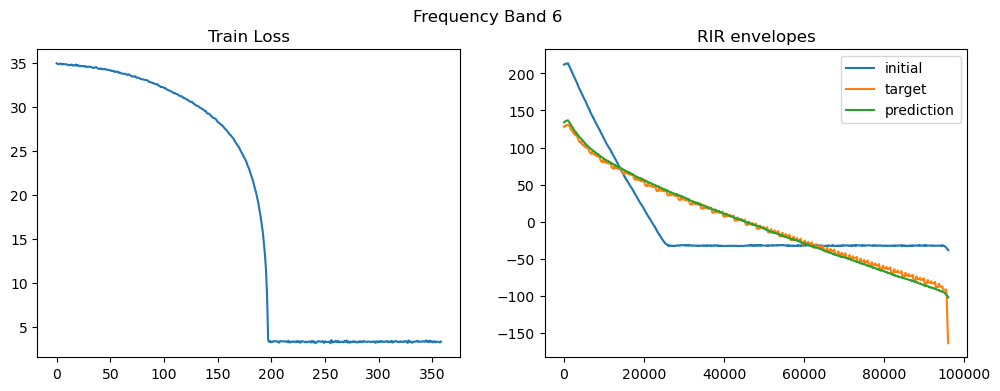

-------------------5th Datapoint out of 14--------------------------
-----trial number: 1------- 
Target Kvalues for band1: (tensor(-0.0732, device='cuda:0'), tensor(-0.2182, device='cuda:0'), tensor(-0.0953, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1110], device='cuda:0')
Ky :  tensor([-0.1200], device='cuda:0')
Kz :  tensor([-0.1080], device='cuda:0')
Loss in epoch:0 is : 39.33229064941406
Loss in epoch:100 is : 3.5524098873138428
Loss in epoch:200 is : 3.7497007846832275

RIR no:1,
Updated model Params:
Kx :  tensor([-0.1072], device='cuda:0')
Ky :  tensor([-0.1221], device='cuda:0')
Kz :  tensor([-0.0309], device='cuda:0')


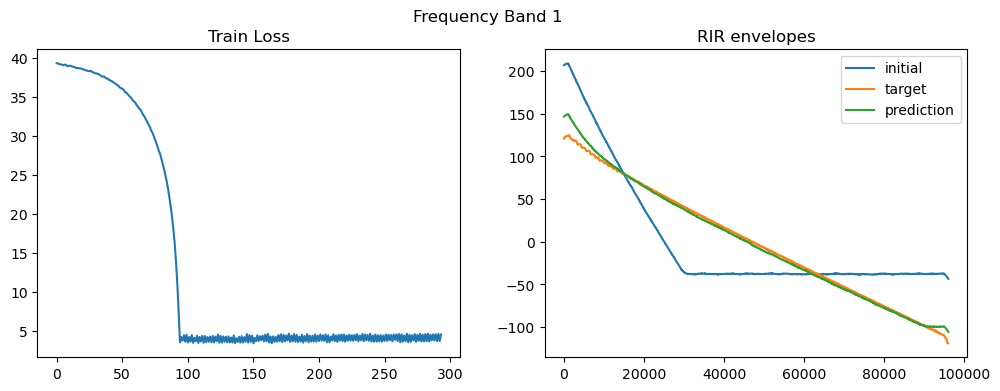

-----trial number: 1------- 
Target Kvalues for band2: (tensor(-0.0732, device='cuda:0'), tensor(-0.2182, device='cuda:0'), tensor(-0.0953, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1770], device='cuda:0')
Ky :  tensor([-0.1640], device='cuda:0')
Kz :  tensor([-0.1440], device='cuda:0')
Loss in epoch:0 is : 43.85484313964844
Loss in epoch:100 is : 40.333091735839844
Loss in epoch:200 is : 4.208724021911621
Loss in epoch:300 is : 4.358597755432129

RIR no:2,
Updated model Params:
Kx :  tensor([-0.1775], device='cuda:0')
Ky :  tensor([-0.1640], device='cuda:0')
Kz :  tensor([-0.0274], device='cuda:0')


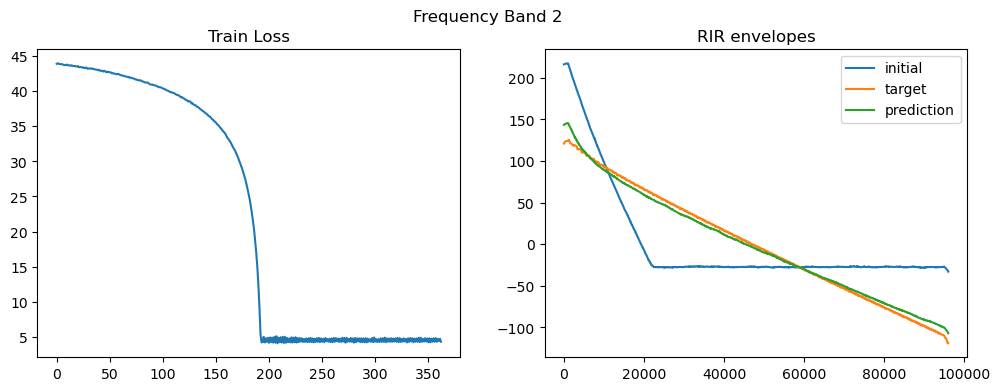

-----trial number: 1------- 
Target Kvalues for band3: (tensor(-0.0732, device='cuda:0'), tensor(-0.2182, device='cuda:0'), tensor(-0.0953, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1270], device='cuda:0')
Ky :  tensor([-0.1950], device='cuda:0')
Kz :  tensor([-0.1250], device='cuda:0')
Loss in epoch:0 is : 41.460227966308594
Loss in epoch:100 is : 36.131107330322266
Loss in epoch:200 is : 4.635395526885986
Loss in epoch:300 is : 4.607466697692871

RIR no:3,
Updated model Params:
Kx :  tensor([-0.1064], device='cuda:0')
Ky :  tensor([-0.1822], device='cuda:0')
Kz :  tensor([-0.0308], device='cuda:0')


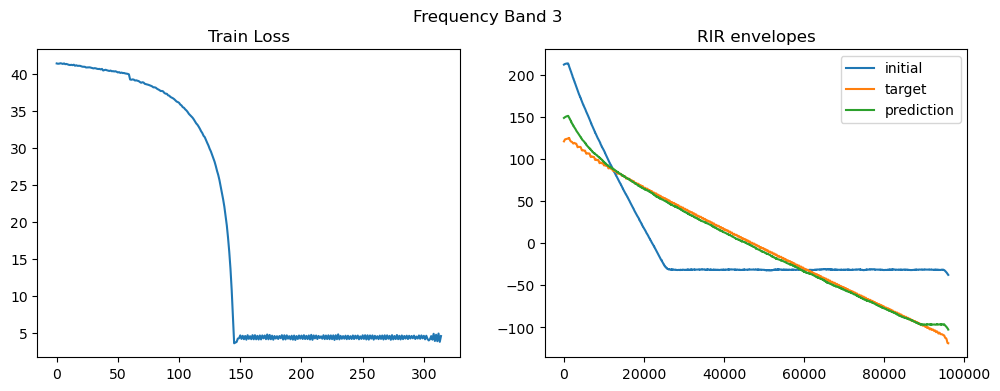

-----trial number: 1------- 
Target Kvalues for band4: (tensor(-0.0732, device='cuda:0'), tensor(-0.2182, device='cuda:0'), tensor(-0.0953, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1210], device='cuda:0')
Ky :  tensor([-0.1540], device='cuda:0')
Kz :  tensor([-0.1430], device='cuda:0')
Loss in epoch:0 is : 41.45311737060547
Loss in epoch:100 is : 25.495750427246094
Loss in epoch:200 is : 4.541673183441162
Loss in epoch:300 is : 4.660681247711182

RIR no:4,
Updated model Params:
Kx :  tensor([-0.0319], device='cuda:0')
Ky :  tensor([-0.1547], device='cuda:0')
Kz :  tensor([-0.1433], device='cuda:0')


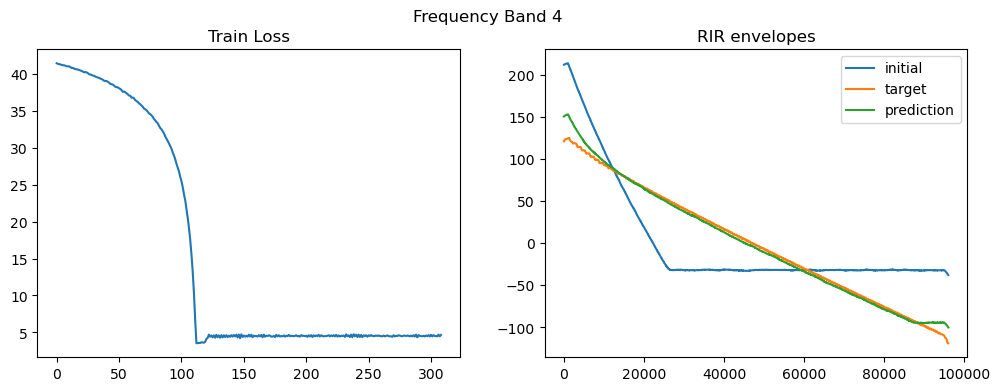

-----trial number: 1------- 
Target Kvalues for band5: (tensor(-0.0732, device='cuda:0'), tensor(-0.2182, device='cuda:0'), tensor(-0.0953, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1530], device='cuda:0')
Ky :  tensor([-0.1440], device='cuda:0')
Kz :  tensor([-0.1160], device='cuda:0')
Loss in epoch:0 is : 40.93643569946289
Loss in epoch:100 is : 6.5805792808532715
Loss in epoch:200 is : 3.999805212020874

RIR no:5,
Updated model Params:
Kx :  tensor([-0.1500], device='cuda:0')
Ky :  tensor([-0.1408], device='cuda:0')
Kz :  tensor([-0.0276], device='cuda:0')


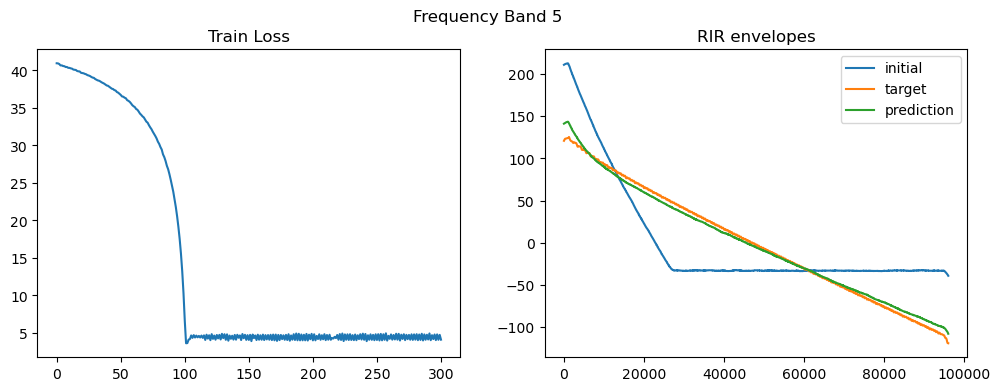

-----trial number: 1------- 
Target Kvalues for band6: (tensor(-0.0732, device='cuda:0'), tensor(-0.2182, device='cuda:0'), tensor(-0.0953, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1890], device='cuda:0')
Ky :  tensor([-0.1040], device='cuda:0')
Kz :  tensor([-0.1300], device='cuda:0')
Loss in epoch:0 is : 37.670162200927734
Loss in epoch:100 is : 3.58050799369812
Loss in epoch:200 is : 3.3991470336914062

RIR no:6,
Updated model Params:
Kx :  tensor([-0.2004], device='cuda:0')
Ky :  tensor([-0.0338], device='cuda:0')
Kz :  tensor([-0.1355], device='cuda:0')


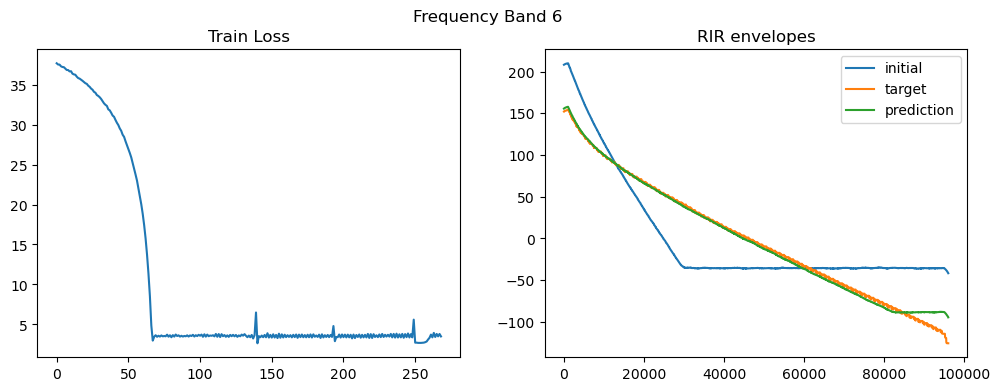

-------------------6th Datapoint out of 14--------------------------
-----trial number: 1------- 
Target Kvalues for band1: (tensor(-0.1369, device='cuda:0'), tensor(-0.0665, device='cuda:0'), tensor(-0.1679, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1300], device='cuda:0')
Ky :  tensor([-0.1410], device='cuda:0')
Kz :  tensor([-0.1970], device='cuda:0')
Loss in epoch:0 is : 47.114280700683594
Loss in epoch:100 is : 35.01070022583008
Loss in epoch:200 is : 7.847792148590088
Loss in epoch:300 is : 7.49361515045166

RIR no:1,
Updated model Params:
Kx :  tensor([-0.0337], device='cuda:0')
Ky :  tensor([-0.1253], device='cuda:0')
Kz :  tensor([-0.1843], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band1: (tensor(-0.1369, device='cuda:0'), tensor(-0.0665, device='cuda:0'), tensor(-0.1679, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1330], device='cuda:0')
Ky :  tensor([-0.1640], device='cuda:0')
Kz :  tensor([-0.1420], device='cuda:0')
Loss in

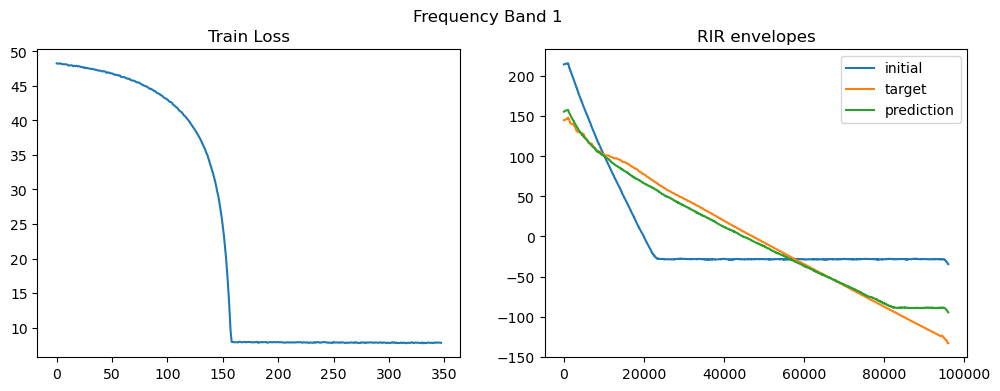

-----trial number: 1------- 
Target Kvalues for band2: (tensor(-0.1369, device='cuda:0'), tensor(-0.0665, device='cuda:0'), tensor(-0.1679, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1410], device='cuda:0')
Ky :  tensor([-0.1370], device='cuda:0')
Kz :  tensor([-0.1820], device='cuda:0')
Loss in epoch:0 is : 47.74375915527344
Loss in epoch:100 is : 42.39974594116211
Loss in epoch:200 is : 7.566967487335205
Loss in epoch:300 is : 7.536942481994629

RIR no:2,
Updated model Params:
Kx :  tensor([-0.1276], device='cuda:0')
Ky :  tensor([-0.0337], device='cuda:0')
Kz :  tensor([-0.1788], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band2: (tensor(-0.1369, device='cuda:0'), tensor(-0.0665, device='cuda:0'), tensor(-0.1679, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1260], device='cuda:0')
Ky :  tensor([-0.1910], device='cuda:0')
Kz :  tensor([-0.1420], device='cuda:0')
Loss in epoch:0 is : 46.779415130615234
Loss in epoch:100 is : 25.0628356933

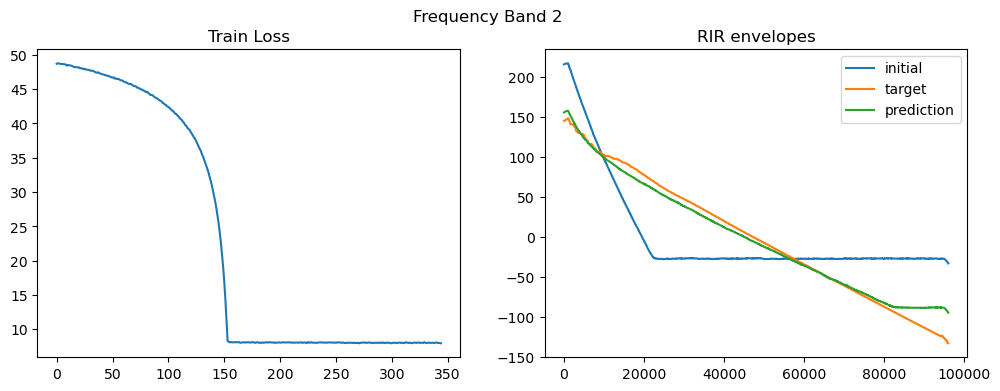

-----trial number: 1------- 
Target Kvalues for band3: (tensor(-0.1369, device='cuda:0'), tensor(-0.0665, device='cuda:0'), tensor(-0.1679, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1340], device='cuda:0')
Ky :  tensor([-0.1260], device='cuda:0')
Kz :  tensor([-0.1740], device='cuda:0')
Loss in epoch:0 is : 46.57525634765625
Loss in epoch:100 is : 29.031740188598633
Loss in epoch:200 is : 7.49892520904541
Loss in epoch:300 is : 7.410046577453613

RIR no:3,
Updated model Params:
Kx :  tensor([-0.1243], device='cuda:0')
Ky :  tensor([-0.0336], device='cuda:0')
Kz :  tensor([-0.1708], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band3: (tensor(-0.1369, device='cuda:0'), tensor(-0.0665, device='cuda:0'), tensor(-0.1679, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1810], device='cuda:0')
Ky :  tensor([-0.1810], device='cuda:0')
Kz :  tensor([-0.1760], device='cuda:0')
Loss in epoch:0 is : 51.22573471069336
Loss in epoch:100 is : 50.56753540039

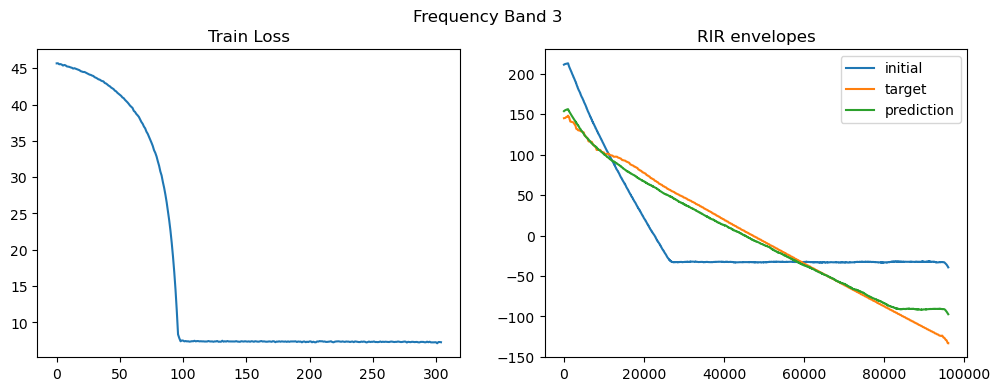

-----trial number: 1------- 
Target Kvalues for band4: (tensor(-0.1369, device='cuda:0'), tensor(-0.0665, device='cuda:0'), tensor(-0.1679, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1270], device='cuda:0')
Ky :  tensor([-0.1120], device='cuda:0')
Kz :  tensor([-0.1400], device='cuda:0')
Loss in epoch:0 is : 44.479103088378906
Loss in epoch:100 is : 7.051950931549072
Loss in epoch:200 is : 7.080953121185303

RIR no:4,
Updated model Params:
Kx :  tensor([-0.1122], device='cuda:0')
Ky :  tensor([-0.0338], device='cuda:0')
Kz :  tensor([-0.1261], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band4: (tensor(-0.1369, device='cuda:0'), tensor(-0.0665, device='cuda:0'), tensor(-0.1679, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1950], device='cuda:0')
Ky :  tensor([-0.1170], device='cuda:0')
Kz :  tensor([-0.1450], device='cuda:0')
Loss in epoch:0 is : 45.49755859375
Loss in epoch:100 is : 7.937037467956543
Loss in epoch:200 is : 7.85020303726196

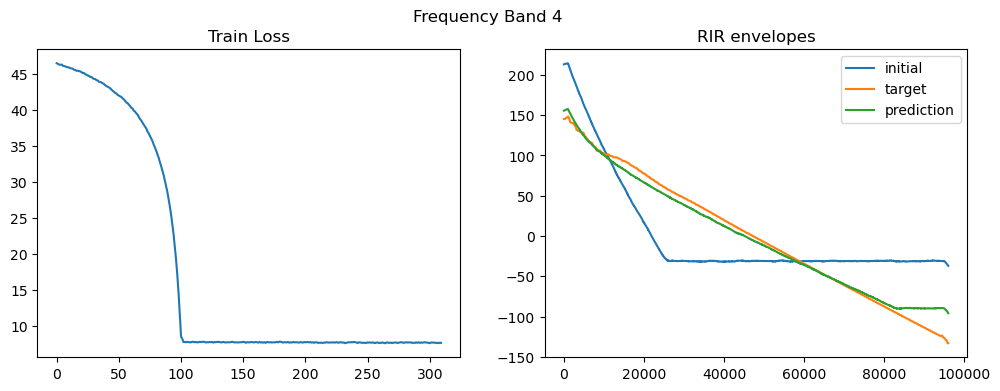

-----trial number: 1------- 
Target Kvalues for band5: (tensor(-0.1369, device='cuda:0'), tensor(-0.0665, device='cuda:0'), tensor(-0.1679, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1970], device='cuda:0')
Ky :  tensor([-0.1350], device='cuda:0')
Kz :  tensor([-0.1260], device='cuda:0')
Loss in epoch:0 is : 46.71217727661133
Loss in epoch:100 is : 31.42440414428711
Loss in epoch:200 is : 7.715445041656494
Loss in epoch:300 is : 7.662152290344238

RIR no:5,
Updated model Params:
Kx :  tensor([-0.1930], device='cuda:0')
Ky :  tensor([-0.1236], device='cuda:0')
Kz :  tensor([-0.0327], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band5: (tensor(-0.1369, device='cuda:0'), tensor(-0.0665, device='cuda:0'), tensor(-0.1679, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1010], device='cuda:0')
Ky :  tensor([-0.1800], device='cuda:0')
Kz :  tensor([-0.1970], device='cuda:0')
Loss in epoch:0 is : 42.83442306518555
Loss in epoch:100 is : 8.336192131042

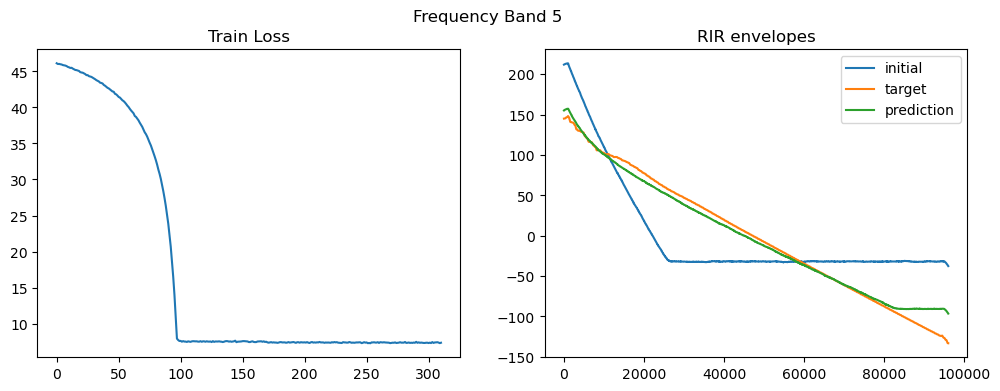

-----trial number: 1------- 
Target Kvalues for band6: (tensor(-0.1369, device='cuda:0'), tensor(-0.0665, device='cuda:0'), tensor(-0.1679, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1410], device='cuda:0')
Ky :  tensor([-0.1870], device='cuda:0')
Kz :  tensor([-0.1860], device='cuda:0')
Loss in epoch:0 is : 49.79579162597656
Loss in epoch:100 is : 38.449195861816406
Loss in epoch:200 is : 11.088539123535156
Loss in epoch:300 is : 10.994683265686035

RIR no:6,
Updated model Params:
Kx :  tensor([-0.0357], device='cuda:0')
Ky :  tensor([-0.1764], device='cuda:0')
Kz :  tensor([-0.1753], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band6: (tensor(-0.1369, device='cuda:0'), tensor(-0.0665, device='cuda:0'), tensor(-0.1679, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1540], device='cuda:0')
Ky :  tensor([-0.1790], device='cuda:0')
Kz :  tensor([-0.1280], device='cuda:0')
Loss in epoch:0 is : 47.72898864746094
Loss in epoch:100 is : 15.01913642

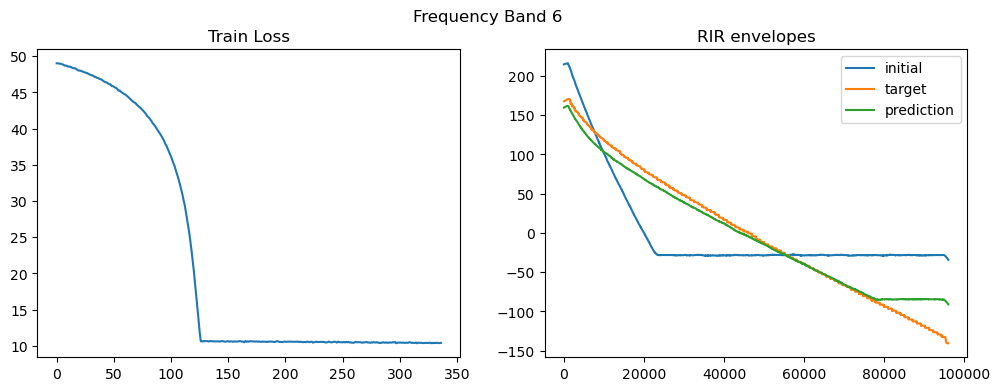

-------------------7th Datapoint out of 14--------------------------
-----trial number: 1------- 
Target Kvalues for band1: (tensor(-0.1310, device='cuda:0'), tensor(-0.1102, device='cuda:0'), tensor(-0.1361, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1050], device='cuda:0')
Ky :  tensor([-0.1430], device='cuda:0')
Kz :  tensor([-0.1180], device='cuda:0')
Loss in epoch:0 is : 47.099727630615234
Loss in epoch:100 is : 16.320770263671875
Loss in epoch:200 is : 15.919424057006836

RIR no:1,
Updated model Params:
Kx :  tensor([-0.0425], device='cuda:0')
Ky :  tensor([-0.1224], device='cuda:0')
Kz :  tensor([-0.0903], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band1: (tensor(-0.1310, device='cuda:0'), tensor(-0.1102, device='cuda:0'), tensor(-0.1361, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1200], device='cuda:0')
Ky :  tensor([-0.1150], device='cuda:0')
Kz :  tensor([-0.1890], device='cuda:0')
Loss in epoch:0 is : 49.69200897216797
Loss i

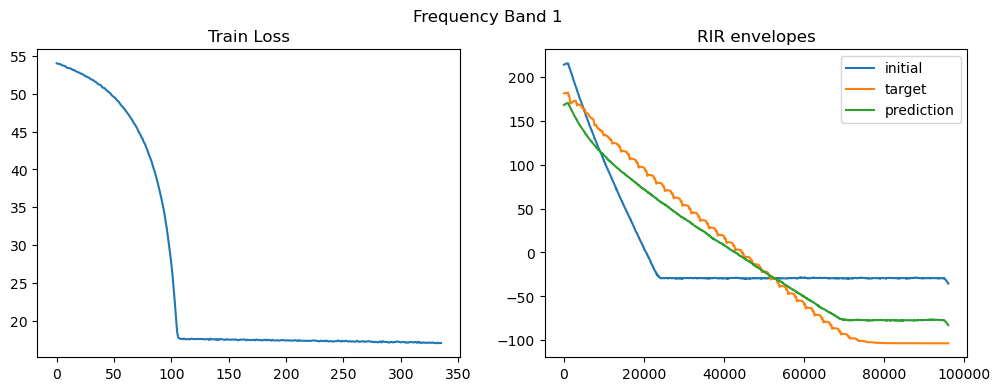

-----trial number: 1------- 
Target Kvalues for band2: (tensor(-0.1310, device='cuda:0'), tensor(-0.1102, device='cuda:0'), tensor(-0.1361, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1100], device='cuda:0')
Ky :  tensor([-0.1860], device='cuda:0')
Kz :  tensor([-0.1280], device='cuda:0')
Loss in epoch:0 is : 49.252498626708984
Loss in epoch:100 is : 17.343595504760742
Loss in epoch:200 is : 17.112060546875

RIR no:2,
Updated model Params:
Kx :  tensor([-0.0416], device='cuda:0')
Ky :  tensor([-0.1715], device='cuda:0')
Kz :  tensor([-0.1044], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band2: (tensor(-0.1310, device='cuda:0'), tensor(-0.1102, device='cuda:0'), tensor(-0.1361, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1260], device='cuda:0')
Ky :  tensor([-0.1630], device='cuda:0')
Kz :  tensor([-0.1580], device='cuda:0')
Loss in epoch:0 is : 52.84297180175781
Loss in epoch:100 is : 17.622859954833984
Loss in epoch:200 is : 17.4289798736

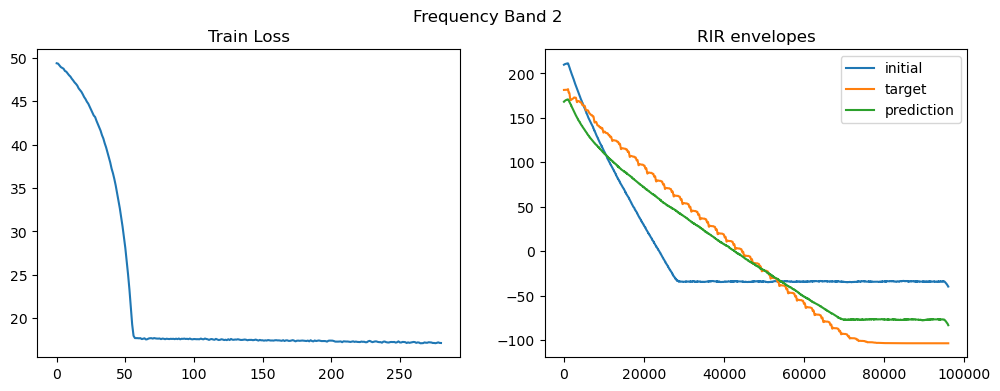

-----trial number: 1------- 
Target Kvalues for band3: (tensor(-0.1310, device='cuda:0'), tensor(-0.1102, device='cuda:0'), tensor(-0.1361, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1550], device='cuda:0')
Ky :  tensor([-0.1930], device='cuda:0')
Kz :  tensor([-0.1010], device='cuda:0')
Loss in epoch:0 is : 47.99320602416992
Loss in epoch:100 is : 18.030406951904297
Loss in epoch:200 is : 17.827505111694336

RIR no:3,
Updated model Params:
Kx :  tensor([-0.1387], device='cuda:0')
Ky :  tensor([-0.1800], device='cuda:0')
Kz :  tensor([-0.0400], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band3: (tensor(-0.1310, device='cuda:0'), tensor(-0.1102, device='cuda:0'), tensor(-0.1361, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1100], device='cuda:0')
Ky :  tensor([-0.1800], device='cuda:0')
Kz :  tensor([-0.1680], device='cuda:0')
Loss in epoch:0 is : 50.07954025268555
Loss in epoch:100 is : 18.027000427246094
Loss in epoch:200 is : 17.97345352

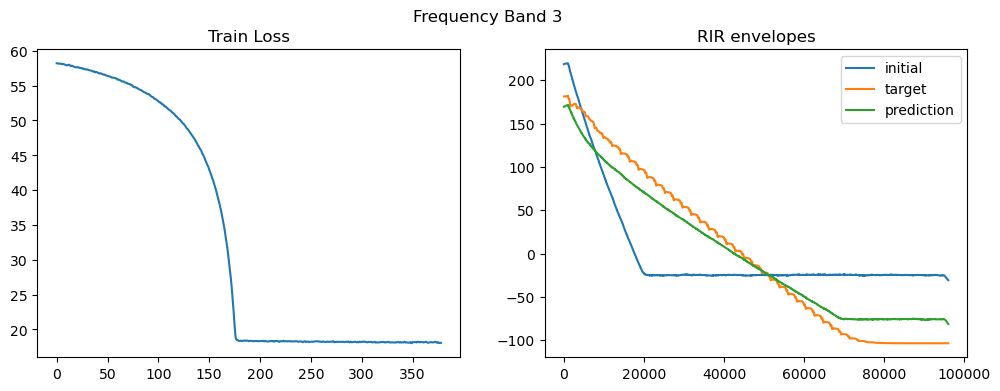

-----trial number: 1------- 
Target Kvalues for band4: (tensor(-0.1310, device='cuda:0'), tensor(-0.1102, device='cuda:0'), tensor(-0.1361, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1960], device='cuda:0')
Ky :  tensor([-0.1210], device='cuda:0')
Kz :  tensor([-0.1590], device='cuda:0')
Loss in epoch:0 is : 52.374244689941406
Loss in epoch:100 is : 18.279972076416016
Loss in epoch:200 is : 18.108898162841797

RIR no:4,
Updated model Params:
Kx :  tensor([-0.1893], device='cuda:0')
Ky :  tensor([-0.0408], device='cuda:0')
Kz :  tensor([-0.1479], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band4: (tensor(-0.1310, device='cuda:0'), tensor(-0.1102, device='cuda:0'), tensor(-0.1361, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1490], device='cuda:0')
Ky :  tensor([-0.1840], device='cuda:0')
Kz :  tensor([-0.1350], device='cuda:0')
Loss in epoch:0 is : 54.41189193725586
Loss in epoch:100 is : 28.619583129882812
Loss in epoch:200 is : 17.5559253

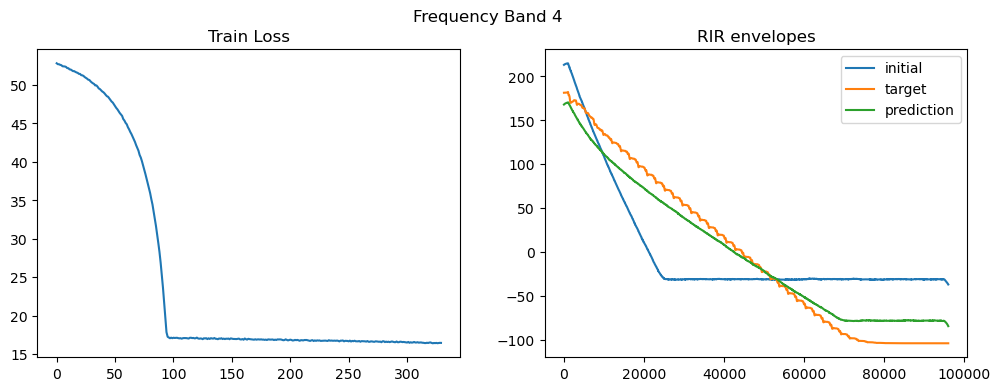

-----trial number: 1------- 
Target Kvalues for band5: (tensor(-0.1310, device='cuda:0'), tensor(-0.1102, device='cuda:0'), tensor(-0.1361, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1550], device='cuda:0')
Ky :  tensor([-0.1730], device='cuda:0')
Kz :  tensor([-0.1560], device='cuda:0')
Loss in epoch:0 is : 56.53587341308594
Loss in epoch:100 is : 52.352745056152344
Loss in epoch:200 is : 17.382383346557617
Loss in epoch:300 is : 17.083232879638672

RIR no:5,
Updated model Params:
Kx :  tensor([-0.0416], device='cuda:0')
Ky :  tensor([-0.1538], device='cuda:0')
Kz :  tensor([-0.1176], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band5: (tensor(-0.1310, device='cuda:0'), tensor(-0.1102, device='cuda:0'), tensor(-0.1361, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1290], device='cuda:0')
Ky :  tensor([-0.1610], device='cuda:0')
Kz :  tensor([-0.1830], device='cuda:0')
Loss in epoch:0 is : 53.694725036621094
Loss in epoch:100 is : 18.0066032

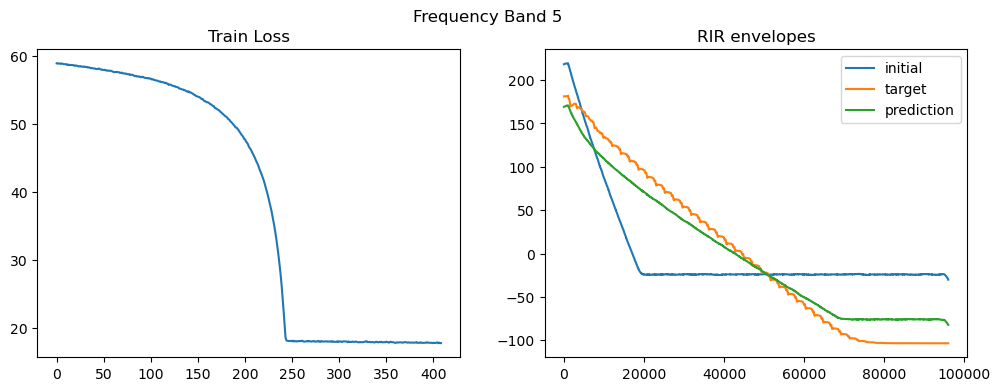

-----trial number: 1------- 
Target Kvalues for band6: (tensor(-0.1310, device='cuda:0'), tensor(-0.1102, device='cuda:0'), tensor(-0.1361, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1010], device='cuda:0')
Ky :  tensor([-0.1440], device='cuda:0')
Kz :  tensor([-0.1020], device='cuda:0')
Loss in epoch:0 is : 58.69573974609375
Loss in epoch:100 is : 30.95995330810547
Loss in epoch:200 is : 30.085895538330078
Loss in epoch:300 is : 27.67938995361328

RIR no:6,
Updated model Params:
Kx :  tensor([-0.0432], device='cuda:0')
Ky :  tensor([-0.1173], device='cuda:0')
Kz :  tensor([-0.0429], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band6: (tensor(-0.1310, device='cuda:0'), tensor(-0.1102, device='cuda:0'), tensor(-0.1361, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1780], device='cuda:0')
Ky :  tensor([-0.1230], device='cuda:0')
Kz :  tensor([-0.1600], device='cuda:0')
Loss in epoch:0 is : 66.04486083984375
Loss in epoch:100 is : 33.4739646911

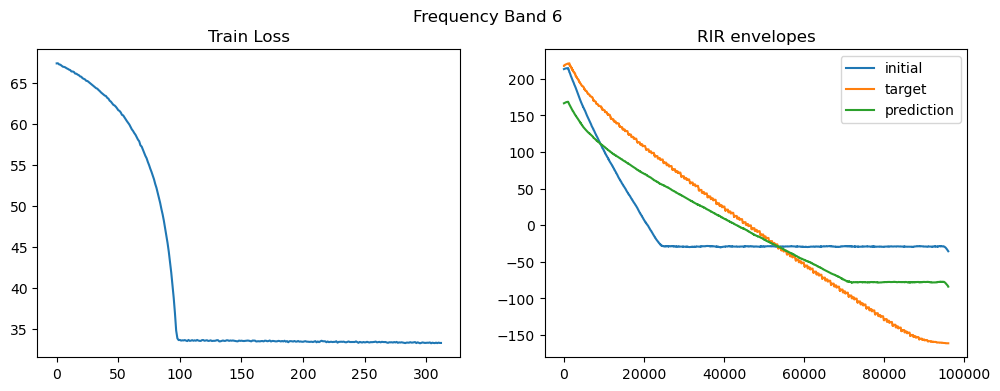

-------------------8th Datapoint out of 14--------------------------
-----trial number: 1------- 
Target Kvalues for band1: (tensor(-0.0859, device='cuda:0'), tensor(-0.0638, device='cuda:0'), tensor(-0.1147, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1410], device='cuda:0')
Ky :  tensor([-0.1850], device='cuda:0')
Kz :  tensor([-0.1690], device='cuda:0')
Loss in epoch:0 is : 55.198665618896484
Loss in epoch:100 is : 33.570472717285156
Loss in epoch:200 is : 15.540114402770996
Loss in epoch:300 is : 15.38740348815918

RIR no:1,
Updated model Params:
Kx :  tensor([-0.0365], device='cuda:0')
Ky :  tensor([-0.1642], device='cuda:0')
Kz :  tensor([-0.1473], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band1: (tensor(-0.0859, device='cuda:0'), tensor(-0.0638, device='cuda:0'), tensor(-0.1147, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1480], device='cuda:0')
Ky :  tensor([-0.1260], device='cuda:0')
Kz :  tensor([-0.1790], device='cuda:0')
Loss

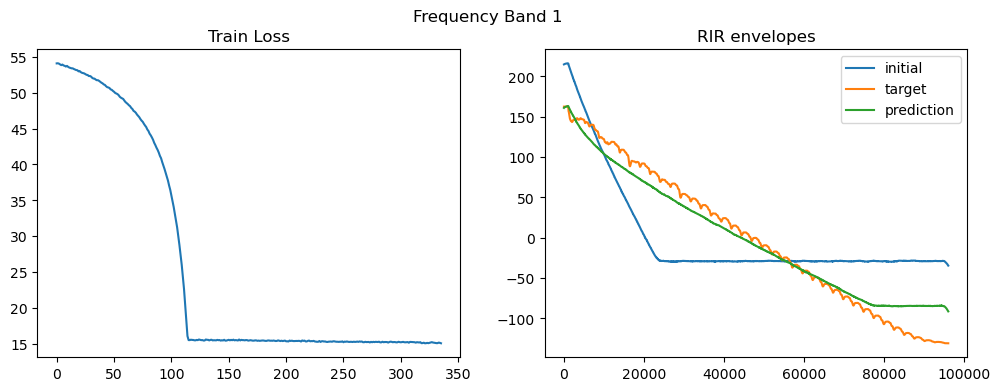

-----trial number: 1------- 
Target Kvalues for band2: (tensor(-0.0859, device='cuda:0'), tensor(-0.0638, device='cuda:0'), tensor(-0.1147, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1290], device='cuda:0')
Ky :  tensor([-0.1850], device='cuda:0')
Kz :  tensor([-0.1940], device='cuda:0')
Loss in epoch:0 is : 53.73674774169922
Loss in epoch:100 is : 15.847814559936523
Loss in epoch:200 is : 15.731554985046387
Loss in epoch:300 is : 15.653246879577637

RIR no:2,
Updated model Params:
Kx :  tensor([-0.0363], device='cuda:0')
Ky :  tensor([-0.1616], device='cuda:0')
Kz :  tensor([-0.1709], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band2: (tensor(-0.0859, device='cuda:0'), tensor(-0.0638, device='cuda:0'), tensor(-0.1147, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1440], device='cuda:0')
Ky :  tensor([-0.2000], device='cuda:0')
Kz :  tensor([-0.1810], device='cuda:0')
Loss in epoch:0 is : 55.7507438659668
Loss in epoch:100 is : 45.818790435

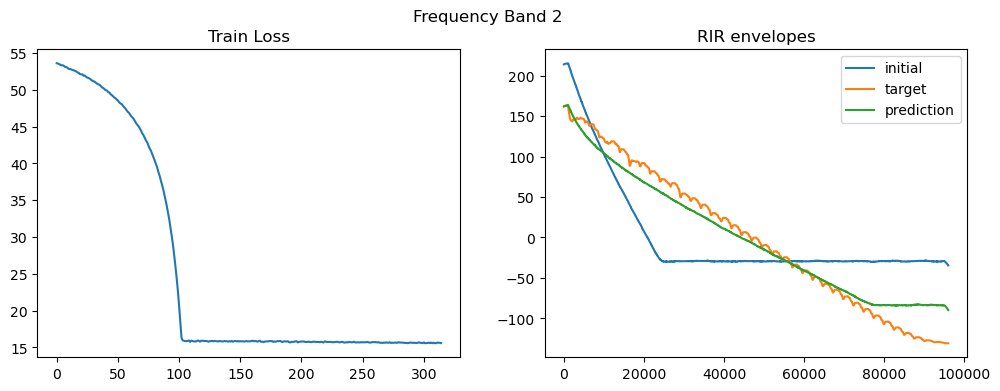

-----trial number: 1------- 
Target Kvalues for band3: (tensor(-0.0859, device='cuda:0'), tensor(-0.0638, device='cuda:0'), tensor(-0.1147, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1990], device='cuda:0')
Ky :  tensor([-0.1800], device='cuda:0')
Kz :  tensor([-0.1850], device='cuda:0')
Loss in epoch:0 is : 58.87557601928711
Loss in epoch:100 is : 57.48197937011719
Loss in epoch:200 is : 53.88127517700195
Loss in epoch:300 is : 19.792728424072266
Loss in epoch:400 is : 16.013601303100586

RIR no:3,
Updated model Params:
Kx :  tensor([-0.1894], device='cuda:0')
Ky :  tensor([-0.0361], device='cuda:0')
Kz :  tensor([-0.1665], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band3: (tensor(-0.0859, device='cuda:0'), tensor(-0.0638, device='cuda:0'), tensor(-0.1147, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1940], device='cuda:0')
Ky :  tensor([-0.1680], device='cuda:0')
Kz :  tensor([-0.1140], device='cuda:0')
Loss in epoch:0 is : 51.181617736

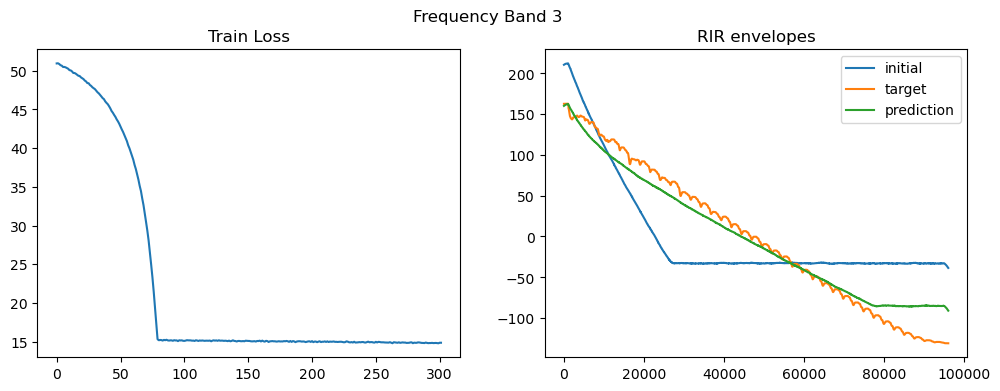

-----trial number: 1------- 
Target Kvalues for band4: (tensor(-0.0859, device='cuda:0'), tensor(-0.0638, device='cuda:0'), tensor(-0.1147, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1310], device='cuda:0')
Ky :  tensor([-0.1490], device='cuda:0')
Kz :  tensor([-0.1750], device='cuda:0')
Loss in epoch:0 is : 53.45066452026367
Loss in epoch:100 is : 15.21761417388916
Loss in epoch:200 is : 15.02661418914795
Loss in epoch:300 is : 14.954914093017578

RIR no:4,
Updated model Params:
Kx :  tensor([-0.0368], device='cuda:0')
Ky :  tensor([-0.1256], device='cuda:0')
Kz :  tensor([-0.1547], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band4: (tensor(-0.0859, device='cuda:0'), tensor(-0.0638, device='cuda:0'), tensor(-0.1147, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1840], device='cuda:0')
Ky :  tensor([-0.1940], device='cuda:0')
Kz :  tensor([-0.1570], device='cuda:0')
Loss in epoch:0 is : 57.23222732543945
Loss in epoch:100 is : 52.4573211669

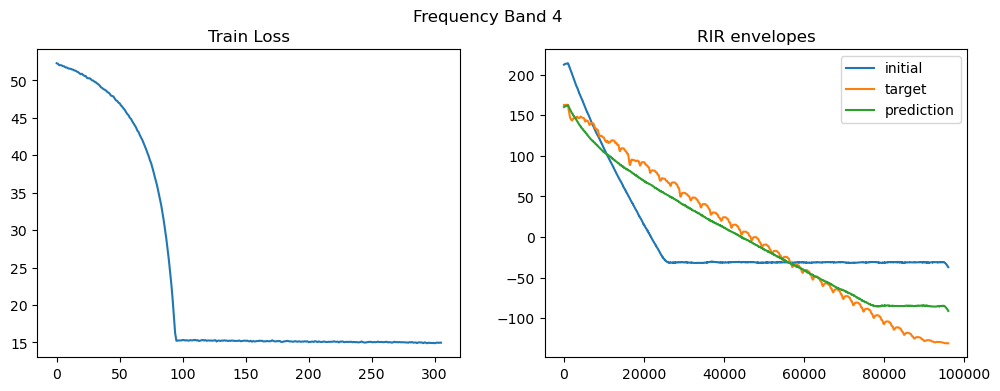

-----trial number: 1------- 
Target Kvalues for band5: (tensor(-0.0859, device='cuda:0'), tensor(-0.0638, device='cuda:0'), tensor(-0.1147, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1250], device='cuda:0')
Ky :  tensor([-0.1730], device='cuda:0')
Kz :  tensor([-0.1250], device='cuda:0')
Loss in epoch:0 is : 51.48039627075195
Loss in epoch:100 is : 30.02369499206543
Loss in epoch:200 is : 14.227439880371094
Loss in epoch:300 is : 13.823041915893555

RIR no:5,
Updated model Params:
Kx :  tensor([-0.0373], device='cuda:0')
Ky :  tensor([-0.1544], device='cuda:0')
Kz :  tensor([-0.0806], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band5: (tensor(-0.0859, device='cuda:0'), tensor(-0.0638, device='cuda:0'), tensor(-0.1147, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1900], device='cuda:0')
Ky :  tensor([-0.1150], device='cuda:0')
Kz :  tensor([-0.1570], device='cuda:0')
Loss in epoch:0 is : 51.064170837402344
Loss in epoch:100 is : 15.80850982

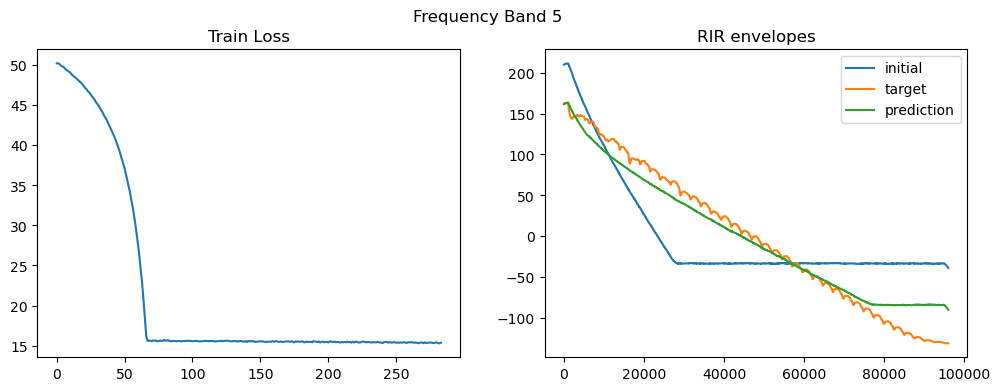

-----trial number: 1------- 
Target Kvalues for band6: (tensor(-0.0859, device='cuda:0'), tensor(-0.0638, device='cuda:0'), tensor(-0.1147, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1350], device='cuda:0')
Ky :  tensor([-0.1220], device='cuda:0')
Kz :  tensor([-0.1020], device='cuda:0')
Loss in epoch:0 is : 50.909889221191406
Loss in epoch:100 is : 21.143924713134766
Loss in epoch:200 is : 20.916479110717773

RIR no:6,
Updated model Params:
Kx :  tensor([-0.1189], device='cuda:0')
Ky :  tensor([-0.1025], device='cuda:0')
Kz :  tensor([-0.0384], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band6: (tensor(-0.0859, device='cuda:0'), tensor(-0.0638, device='cuda:0'), tensor(-0.1147, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1040], device='cuda:0')
Ky :  tensor([-0.1910], device='cuda:0')
Kz :  tensor([-0.1600], device='cuda:0')
Loss in epoch:0 is : 52.82225799560547
Loss in epoch:100 is : 22.7559871673584
Loss in epoch:200 is : 22.684583663

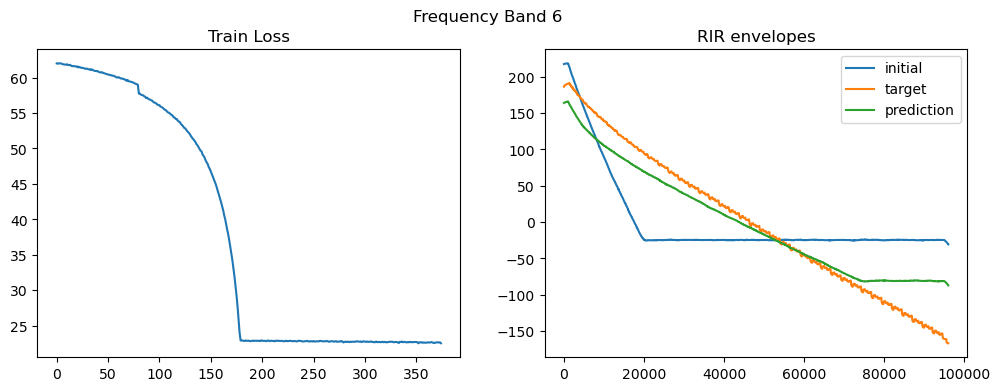

-------------------9th Datapoint out of 14--------------------------
-----trial number: 1------- 
Target Kvalues for band1: (tensor(-0.0311, device='cuda:0'), tensor(-0.1429, device='cuda:0'), tensor(-0.1812, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1150], device='cuda:0')
Ky :  tensor([-0.1740], device='cuda:0')
Kz :  tensor([-0.1420], device='cuda:0')
Loss in epoch:0 is : 36.09602355957031
Loss in epoch:100 is : 31.774641036987305
Loss in epoch:200 is : 29.932254791259766
Loss in epoch:300 is : 28.72464370727539
Loss in epoch:400 is : 27.905376434326172

RIR no:1,
Updated model Params:
Kx :  tensor([-0.1912], device='cuda:0')
Ky :  tensor([-0.2041], device='cuda:0')
Kz :  tensor([-0.1927], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band1: (tensor(-0.0311, device='cuda:0'), tensor(-0.1429, device='cuda:0'), tensor(-0.1812, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1660], device='cuda:0')
Ky :  tensor([-0.1500], device='cuda:0')
Kz :

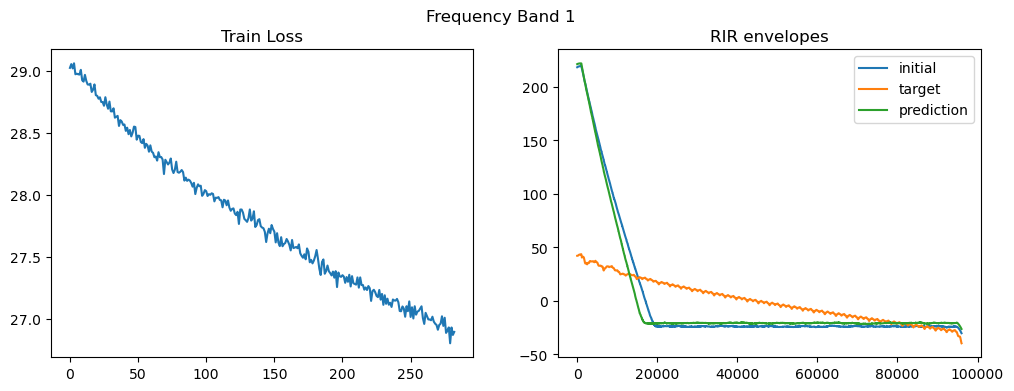

-----trial number: 1------- 
Target Kvalues for band2: (tensor(-0.0311, device='cuda:0'), tensor(-0.1429, device='cuda:0'), tensor(-0.1812, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1210], device='cuda:0')
Ky :  tensor([-0.1060], device='cuda:0')
Kz :  tensor([-0.1110], device='cuda:0')
Loss in epoch:0 is : 40.75344467163086
Loss in epoch:100 is : 35.4583625793457
Loss in epoch:200 is : 32.38510513305664
Loss in epoch:300 is : 30.517911911010742
Loss in epoch:400 is : 29.239614486694336

RIR no:2,
Updated model Params:
Kx :  tensor([-0.1902], device='cuda:0')
Ky :  tensor([-0.1894], device='cuda:0')
Kz :  tensor([-0.1887], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band2: (tensor(-0.0311, device='cuda:0'), tensor(-0.1429, device='cuda:0'), tensor(-0.1812, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1880], device='cuda:0')
Ky :  tensor([-0.1500], device='cuda:0')
Kz :  tensor([-0.1170], device='cuda:0')
Loss in epoch:0 is : 35.1234626770

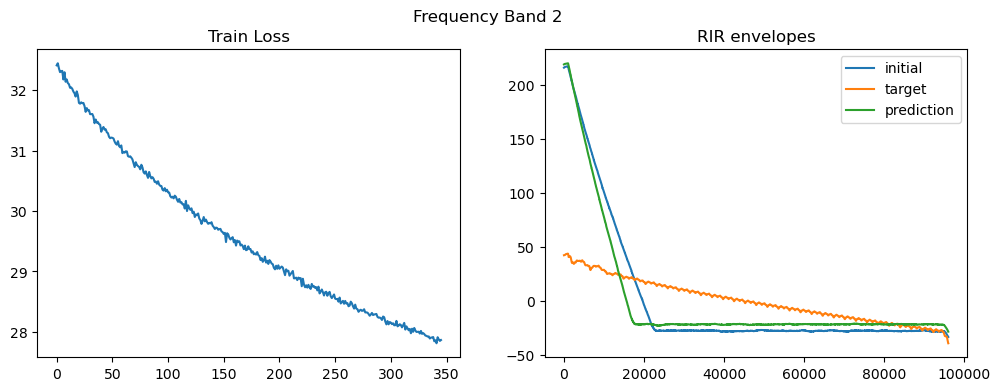

-----trial number: 1------- 
Target Kvalues for band3: (tensor(-0.0311, device='cuda:0'), tensor(-0.1429, device='cuda:0'), tensor(-0.1812, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1450], device='cuda:0')
Ky :  tensor([-0.1930], device='cuda:0')
Kz :  tensor([-0.1970], device='cuda:0')
Loss in epoch:0 is : 30.732372283935547
Loss in epoch:100 is : 28.70675277709961
Loss in epoch:200 is : 27.769739151000977
Loss in epoch:300 is : 27.060468673706055

RIR no:3,
Updated model Params:
Kx :  tensor([-0.1962], device='cuda:0')
Ky :  tensor([-0.2135], device='cuda:0')
Kz :  tensor([-0.2158], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band3: (tensor(-0.0311, device='cuda:0'), tensor(-0.1429, device='cuda:0'), tensor(-0.1812, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1940], device='cuda:0')
Ky :  tensor([-0.1400], device='cuda:0')
Kz :  tensor([-0.1940], device='cuda:0')
Loss in epoch:0 is : 31.206403732299805
Loss in epoch:100 is : 28.9423141

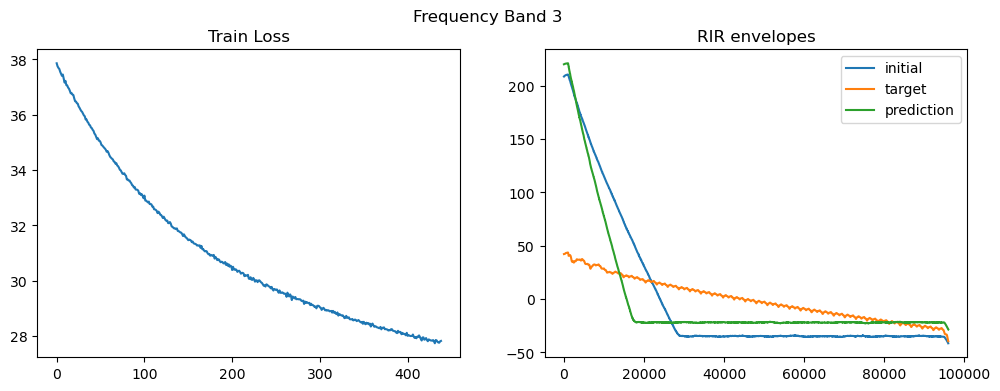

-----trial number: 1------- 
Target Kvalues for band4: (tensor(-0.0311, device='cuda:0'), tensor(-0.1429, device='cuda:0'), tensor(-0.1812, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1030], device='cuda:0')
Ky :  tensor([-0.1130], device='cuda:0')
Kz :  tensor([-0.1620], device='cuda:0')
Loss in epoch:0 is : 39.63883590698242
Loss in epoch:100 is : 36.33929443359375
Loss in epoch:200 is : 32.64389419555664
Loss in epoch:300 is : 30.617549896240234
Loss in epoch:400 is : 29.241254806518555

RIR no:4,
Updated model Params:
Kx :  tensor([-0.1833], device='cuda:0')
Ky :  tensor([-0.1834], device='cuda:0')
Kz :  tensor([-0.1883], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band4: (tensor(-0.0311, device='cuda:0'), tensor(-0.1429, device='cuda:0'), tensor(-0.1812, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1440], device='cuda:0')
Ky :  tensor([-0.1480], device='cuda:0')
Kz :  tensor([-0.1080], device='cuda:0')
Loss in epoch:0 is : 37.600780487

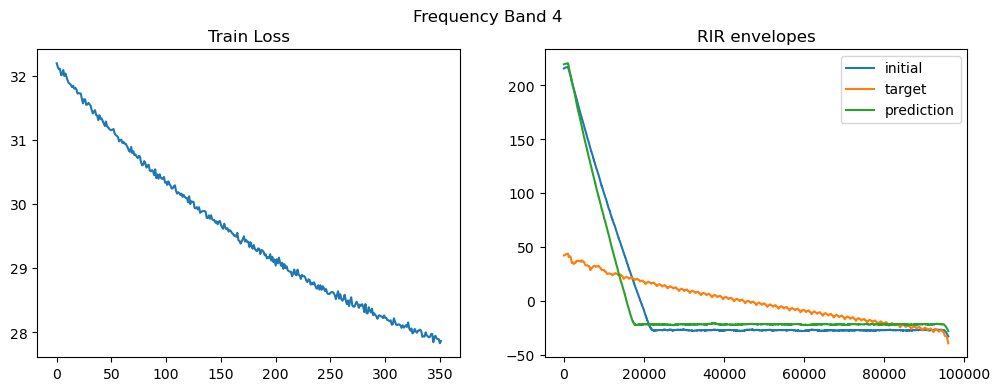

-----trial number: 1------- 
Target Kvalues for band5: (tensor(-0.0311, device='cuda:0'), tensor(-0.1429, device='cuda:0'), tensor(-0.1812, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1550], device='cuda:0')
Ky :  tensor([-0.1640], device='cuda:0')
Kz :  tensor([-0.1420], device='cuda:0')
Loss in epoch:0 is : 32.67533493041992
Loss in epoch:100 is : 30.519166946411133
Loss in epoch:200 is : 29.238094329833984
Loss in epoch:300 is : 28.268512725830078

RIR no:5,
Updated model Params:
Kx :  tensor([-0.1955], device='cuda:0')
Ky :  tensor([-0.1983], device='cuda:0')
Kz :  tensor([-0.1921], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band5: (tensor(-0.0311, device='cuda:0'), tensor(-0.1429, device='cuda:0'), tensor(-0.1812, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1720], device='cuda:0')
Ky :  tensor([-0.1830], device='cuda:0')
Kz :  tensor([-0.1500], device='cuda:0')
Loss in epoch:0 is : 30.89003562927246
Loss in epoch:100 is : 29.29401779

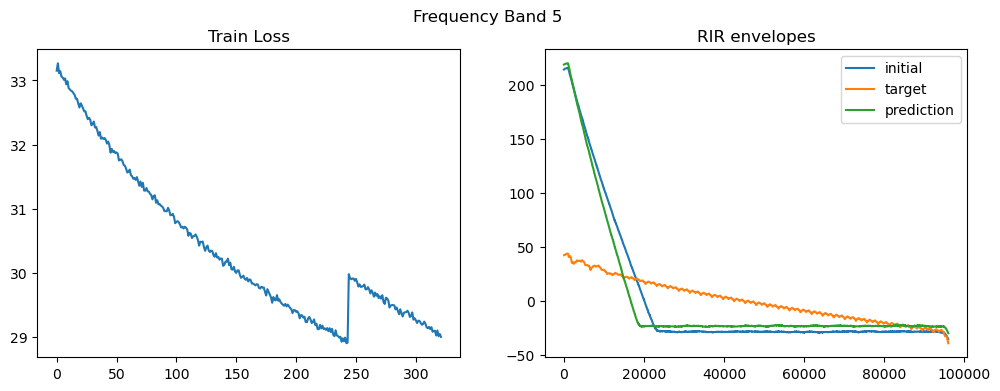

-----trial number: 1------- 
Target Kvalues for band6: (tensor(-0.0311, device='cuda:0'), tensor(-0.1429, device='cuda:0'), tensor(-0.1812, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1680], device='cuda:0')
Ky :  tensor([-0.1780], device='cuda:0')
Kz :  tensor([-0.1100], device='cuda:0')
Loss in epoch:0 is : 31.106576919555664
Loss in epoch:100 is : 28.95725440979004
Loss in epoch:200 is : 27.5842227935791
Loss in epoch:300 is : 26.84217071533203

RIR no:6,
Updated model Params:
Kx :  tensor([-0.1830], device='cuda:0')
Ky :  tensor([-0.1887], device='cuda:0')
Kz :  tensor([-0.1656], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band6: (tensor(-0.0311, device='cuda:0'), tensor(-0.1429, device='cuda:0'), tensor(-0.1812, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1670], device='cuda:0')
Ky :  tensor([-0.1250], device='cuda:0')
Kz :  tensor([-0.1240], device='cuda:0')
Loss in epoch:0 is : 31.400920867919922
Loss in epoch:100 is : 29.1252155303

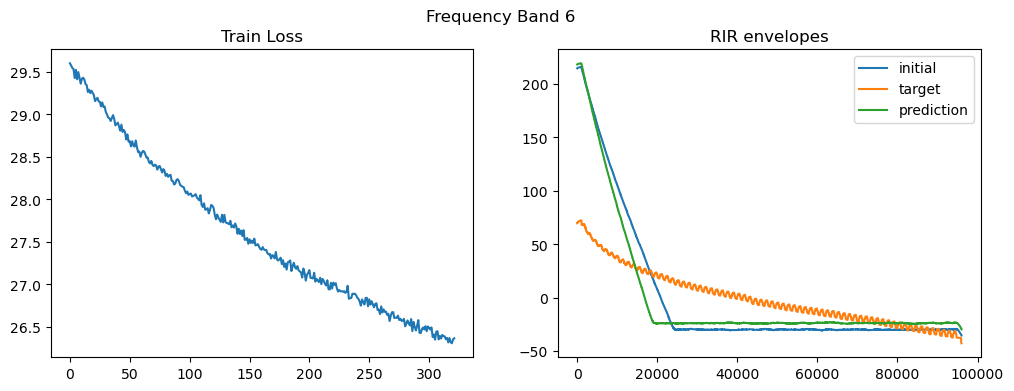

-------------------10th Datapoint out of 14--------------------------
-----trial number: 1------- 
Target Kvalues for band1: (tensor(-0.0507, device='cuda:0'), tensor(-0.0400, device='cuda:0'), tensor(-0.1165, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1980], device='cuda:0')
Ky :  tensor([-0.1280], device='cuda:0')
Kz :  tensor([-0.1960], device='cuda:0')
Loss in epoch:0 is : 31.313825607299805
Loss in epoch:100 is : 30.700162887573242
Loss in epoch:200 is : 30.339792251586914

RIR no:1,
Updated model Params:
Kx :  tensor([-0.2076], device='cuda:0')
Ky :  tensor([-0.1549], device='cuda:0')
Kz :  tensor([-0.2057], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band1: (tensor(-0.0507, device='cuda:0'), tensor(-0.0400, device='cuda:0'), tensor(-0.1165, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1630], device='cuda:0')
Ky :  tensor([-0.1660], device='cuda:0')
Kz :  tensor([-0.1680], device='cuda:0')
Loss in epoch:0 is : 31.166730880737305
Loss

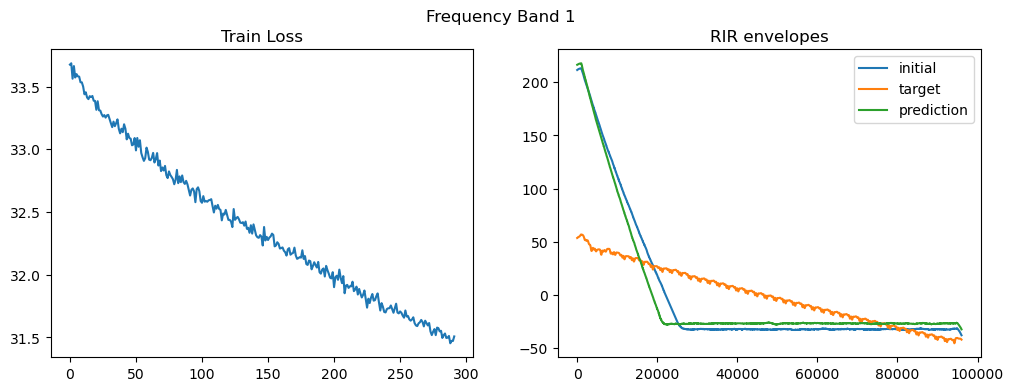

-----trial number: 1------- 
Target Kvalues for band2: (tensor(-0.0507, device='cuda:0'), tensor(-0.0400, device='cuda:0'), tensor(-0.1165, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1340], device='cuda:0')
Ky :  tensor([-0.1210], device='cuda:0')
Kz :  tensor([-0.1710], device='cuda:0')
Loss in epoch:0 is : 33.23969268798828
Loss in epoch:100 is : 32.3039436340332
Loss in epoch:200 is : 31.675031661987305

RIR no:2,
Updated model Params:
Kx :  tensor([-0.1614], device='cuda:0')
Ky :  tensor([-0.1503], device='cuda:0')
Kz :  tensor([-0.1857], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band2: (tensor(-0.0507, device='cuda:0'), tensor(-0.0400, device='cuda:0'), tensor(-0.1165, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1220], device='cuda:0')
Ky :  tensor([-0.1220], device='cuda:0')
Kz :  tensor([-0.1490], device='cuda:0')
Loss in epoch:0 is : 34.14015197753906
Loss in epoch:100 is : 32.906524658203125
Loss in epoch:200 is : 32.1672554016

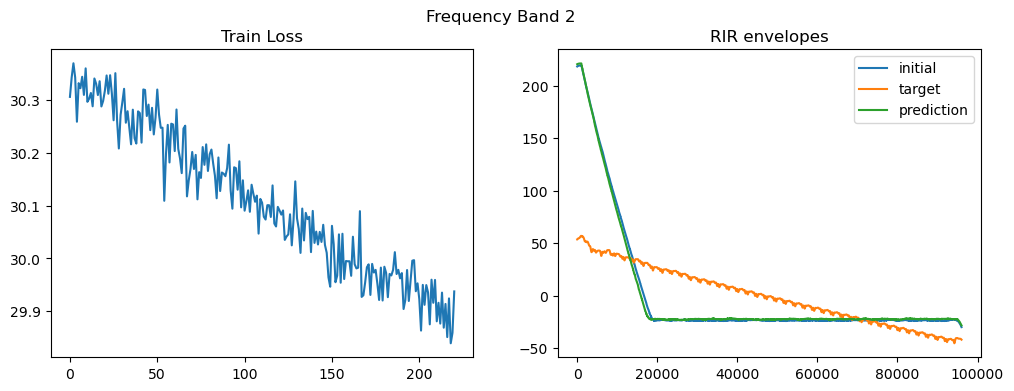

-----trial number: 1------- 
Target Kvalues for band3: (tensor(-0.0507, device='cuda:0'), tensor(-0.0400, device='cuda:0'), tensor(-0.1165, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1620], device='cuda:0')
Ky :  tensor([-0.1430], device='cuda:0')
Kz :  tensor([-0.1880], device='cuda:0')
Loss in epoch:0 is : 31.404203414916992
Loss in epoch:100 is : 30.94618797302246
Loss in epoch:200 is : 30.663949966430664

RIR no:3,
Updated model Params:
Kx :  tensor([-0.1780], device='cuda:0')
Ky :  tensor([-0.1596], device='cuda:0')
Kz :  tensor([-0.1983], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band3: (tensor(-0.0507, device='cuda:0'), tensor(-0.0400, device='cuda:0'), tensor(-0.1165, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1800], device='cuda:0')
Ky :  tensor([-0.1220], device='cuda:0')
Kz :  tensor([-0.1220], device='cuda:0')
Loss in epoch:0 is : 33.538082122802734
Loss in epoch:100 is : 32.43739700317383
Loss in epoch:200 is : 31.84650039

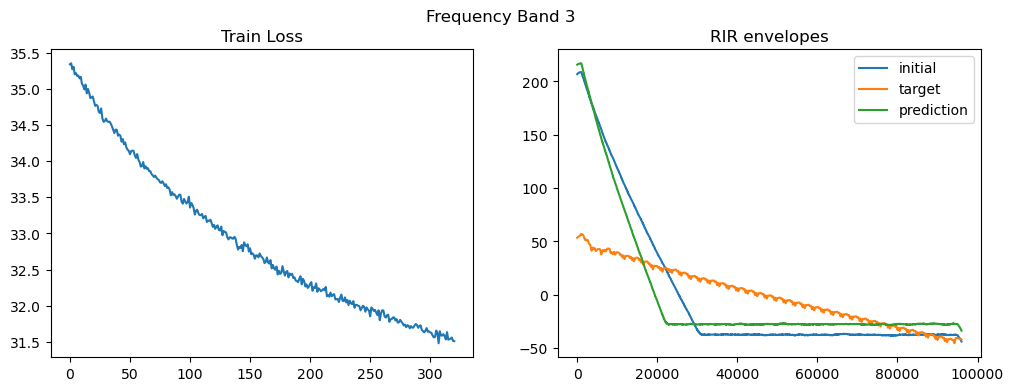

-----trial number: 1------- 
Target Kvalues for band4: (tensor(-0.0507, device='cuda:0'), tensor(-0.0400, device='cuda:0'), tensor(-0.1165, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1490], device='cuda:0')
Ky :  tensor([-0.1360], device='cuda:0')
Kz :  tensor([-0.1020], device='cuda:0')
Loss in epoch:0 is : 34.80877685546875
Loss in epoch:100 is : 33.103240966796875
Loss in epoch:200 is : 32.18880081176758

RIR no:4,
Updated model Params:
Kx :  tensor([-0.1694], device='cuda:0')
Ky :  tensor([-0.1616], device='cuda:0')
Kz :  tensor([-0.1424], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band4: (tensor(-0.0507, device='cuda:0'), tensor(-0.0400, device='cuda:0'), tensor(-0.1165, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1510], device='cuda:0')
Ky :  tensor([-0.1090], device='cuda:0')
Kz :  tensor([-0.1930], device='cuda:0')
Loss in epoch:0 is : 33.21628952026367
Loss in epoch:100 is : 31.90934944152832
Loss in epoch:200 is : 31.3619117736

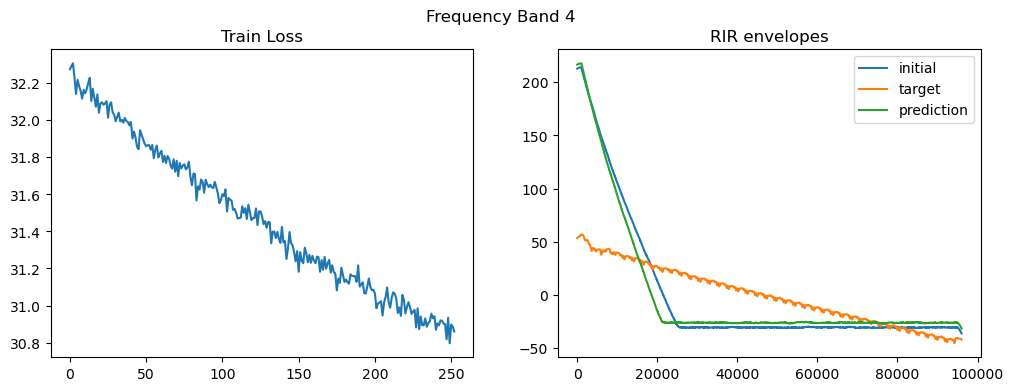

-----trial number: 1------- 
Target Kvalues for band5: (tensor(-0.0507, device='cuda:0'), tensor(-0.0400, device='cuda:0'), tensor(-0.1165, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1260], device='cuda:0')
Ky :  tensor([-0.1030], device='cuda:0')
Kz :  tensor([-0.1030], device='cuda:0')
Loss in epoch:0 is : 36.91259002685547
Loss in epoch:100 is : 34.44609451293945
Loss in epoch:200 is : 33.10648727416992
Loss in epoch:300 is : 32.34442138671875

RIR no:5,
Updated model Params:
Kx :  tensor([-0.1578], device='cuda:0')
Ky :  tensor([-0.1466], device='cuda:0')
Kz :  tensor([-0.1464], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band5: (tensor(-0.0507, device='cuda:0'), tensor(-0.0400, device='cuda:0'), tensor(-0.1165, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1200], device='cuda:0')
Ky :  tensor([-0.1960], device='cuda:0')
Kz :  tensor([-0.1530], device='cuda:0')
Loss in epoch:0 is : 32.465755462646484
Loss in epoch:100 is : 31.5621356964

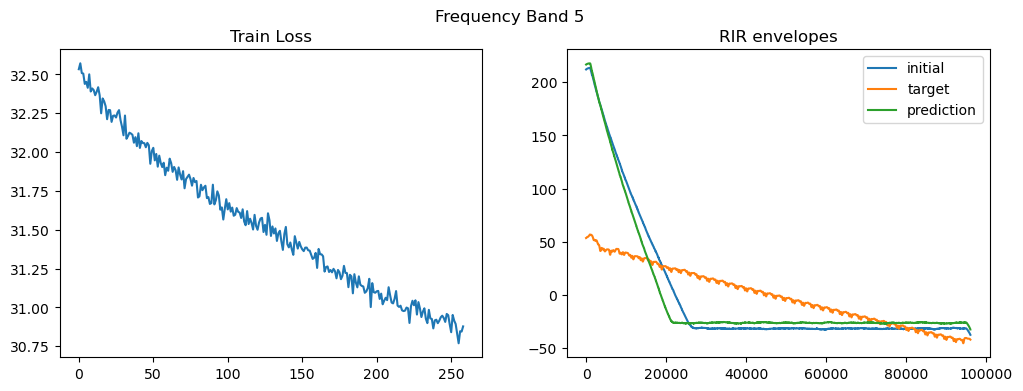

-----trial number: 1------- 
Target Kvalues for band6: (tensor(-0.0507, device='cuda:0'), tensor(-0.0400, device='cuda:0'), tensor(-0.1165, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1810], device='cuda:0')
Ky :  tensor([-0.1300], device='cuda:0')
Kz :  tensor([-0.1970], device='cuda:0')
Loss in epoch:0 is : 28.70254898071289
Loss in epoch:100 is : 28.71847915649414
Loss in epoch:200 is : 28.53457260131836

RIR no:6,
Updated model Params:
Kx :  tensor([-0.1885], device='cuda:0')
Ky :  tensor([-0.1328], device='cuda:0')
Kz :  tensor([-0.2033], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band6: (tensor(-0.0507, device='cuda:0'), tensor(-0.0400, device='cuda:0'), tensor(-0.1165, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1690], device='cuda:0')
Ky :  tensor([-0.1990], device='cuda:0')
Kz :  tensor([-0.1300], device='cuda:0')
Loss in epoch:0 is : 28.796207427978516
Loss in epoch:100 is : 29.011280059814453
Loss in epoch:200 is : 28.843608856

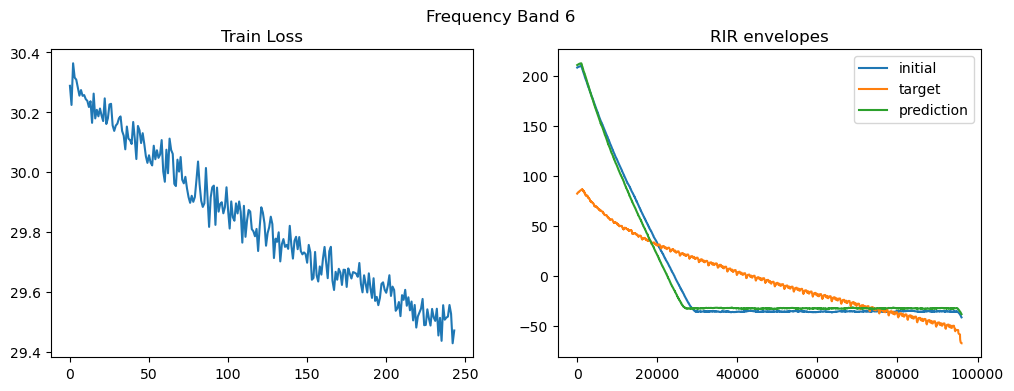

-------------------11th Datapoint out of 14--------------------------
-----trial number: 1------- 
Target Kvalues for band1: (tensor(-0.1015, device='cuda:0'), tensor(-0.2689, device='cuda:0'), tensor(-0.1218, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1470], device='cuda:0')
Ky :  tensor([-0.1970], device='cuda:0')
Kz :  tensor([-0.1250], device='cuda:0')
Loss in epoch:0 is : 53.829627990722656
Loss in epoch:100 is : 20.210617065429688
Loss in epoch:200 is : 19.963966369628906
Loss in epoch:300 is : 19.811574935913086

RIR no:1,
Updated model Params:
Kx :  tensor([-0.1285], device='cuda:0')
Ky :  tensor([-0.1865], device='cuda:0')
Kz :  tensor([-0.0418], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band1: (tensor(-0.1015, device='cuda:0'), tensor(-0.2689, device='cuda:0'), tensor(-0.1218, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1130], device='cuda:0')
Ky :  tensor([-0.1890], device='cuda:0')
Kz :  tensor([-0.1320], device='cuda:0')
Lo

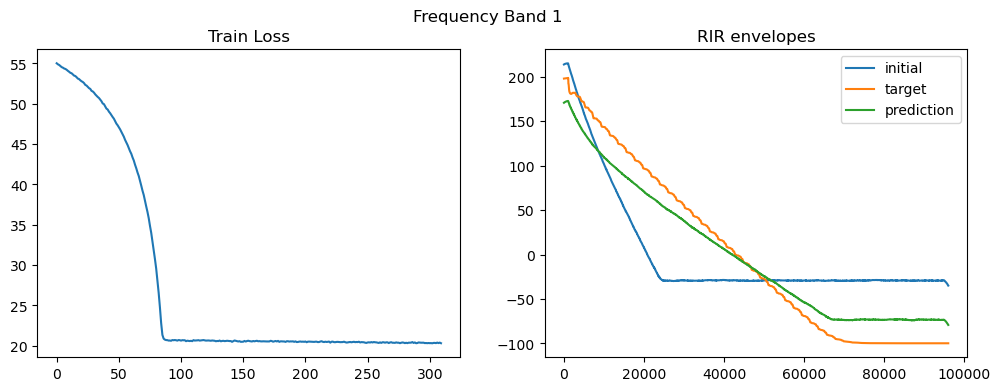

-----trial number: 1------- 
Target Kvalues for band2: (tensor(-0.1015, device='cuda:0'), tensor(-0.2689, device='cuda:0'), tensor(-0.1218, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1620], device='cuda:0')
Ky :  tensor([-0.1690], device='cuda:0')
Kz :  tensor([-0.1840], device='cuda:0')
Loss in epoch:0 is : 58.948604583740234
Loss in epoch:100 is : 54.26319885253906
Loss in epoch:200 is : 20.186044692993164
Loss in epoch:300 is : 20.560049057006836

RIR no:2,
Updated model Params:
Kx :  tensor([-0.0424], device='cuda:0')
Ky :  tensor([-0.1554], device='cuda:0')
Kz :  tensor([-0.1805], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band2: (tensor(-0.1015, device='cuda:0'), tensor(-0.2689, device='cuda:0'), tensor(-0.1218, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1290], device='cuda:0')
Ky :  tensor([-0.1350], device='cuda:0')
Kz :  tensor([-0.1970], device='cuda:0')
Loss in epoch:0 is : 53.68946838378906
Loss in epoch:100 is : 19.81635093

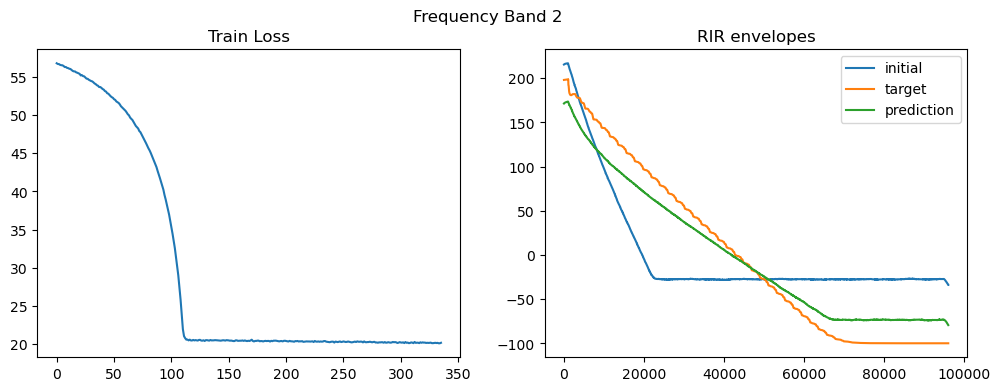

-----trial number: 1------- 
Target Kvalues for band3: (tensor(-0.1015, device='cuda:0'), tensor(-0.2689, device='cuda:0'), tensor(-0.1218, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1270], device='cuda:0')
Ky :  tensor([-0.1890], device='cuda:0')
Kz :  tensor([-0.1340], device='cuda:0')
Loss in epoch:0 is : 53.3491096496582
Loss in epoch:100 is : 19.703060150146484
Loss in epoch:200 is : 19.361215591430664
Loss in epoch:300 is : 19.161033630371094

RIR no:3,
Updated model Params:
Kx :  tensor([-0.0433], device='cuda:0')
Ky :  tensor([-0.1734], device='cuda:0')
Kz :  tensor([-0.1052], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band3: (tensor(-0.1015, device='cuda:0'), tensor(-0.2689, device='cuda:0'), tensor(-0.1218, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1810], device='cuda:0')
Ky :  tensor([-0.1630], device='cuda:0')
Kz :  tensor([-0.1190], device='cuda:0')
Loss in epoch:0 is : 52.944488525390625
Loss in epoch:100 is : 20.21845245

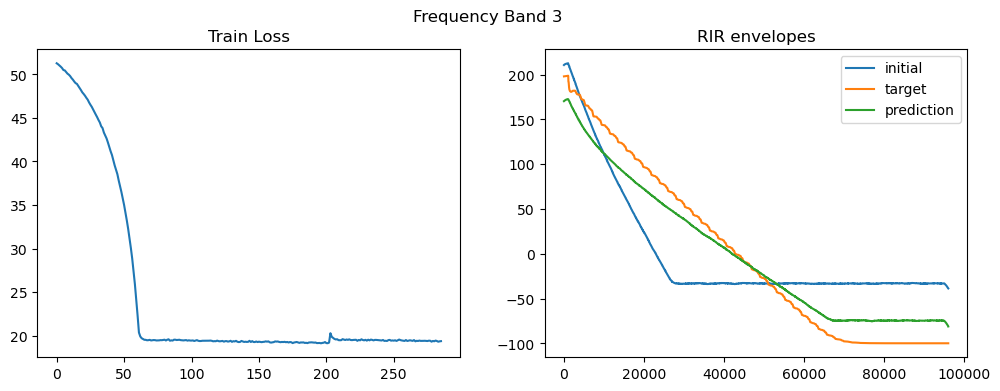

-----trial number: 1------- 
Target Kvalues for band4: (tensor(-0.1015, device='cuda:0'), tensor(-0.2689, device='cuda:0'), tensor(-0.1218, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1960], device='cuda:0')
Ky :  tensor([-0.1610], device='cuda:0')
Kz :  tensor([-0.1660], device='cuda:0')
Loss in epoch:0 is : 58.84435272216797
Loss in epoch:100 is : 54.064292907714844
Loss in epoch:200 is : 20.346521377563477
Loss in epoch:300 is : 20.091136932373047

RIR no:4,
Updated model Params:
Kx :  tensor([-0.1788], device='cuda:0')
Ky :  tensor([-0.0427], device='cuda:0')
Kz :  tensor([-0.1359], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band4: (tensor(-0.1015, device='cuda:0'), tensor(-0.2689, device='cuda:0'), tensor(-0.1218, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1450], device='cuda:0')
Ky :  tensor([-0.1890], device='cuda:0')
Kz :  tensor([-0.1320], device='cuda:0')
Loss in epoch:0 is : 54.79092788696289
Loss in epoch:100 is : 19.99714469

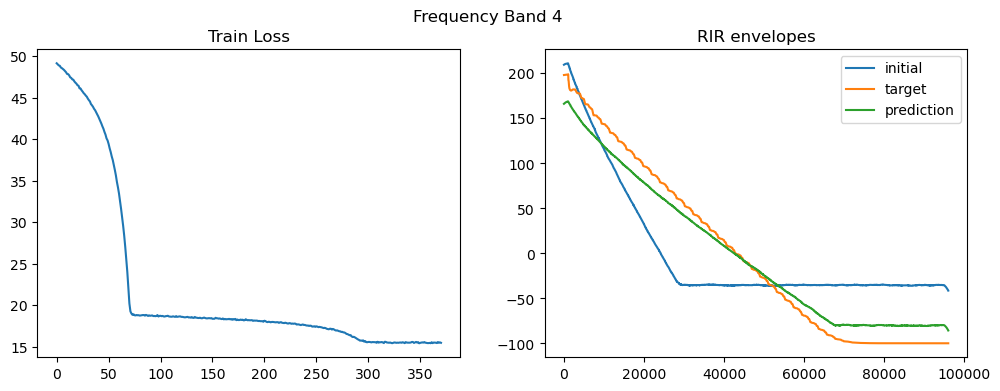

-----trial number: 1------- 
Target Kvalues for band5: (tensor(-0.1015, device='cuda:0'), tensor(-0.2689, device='cuda:0'), tensor(-0.1218, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1690], device='cuda:0')
Ky :  tensor([-0.1490], device='cuda:0')
Kz :  tensor([-0.1630], device='cuda:0')
Loss in epoch:0 is : 57.22023010253906
Loss in epoch:100 is : 46.62303161621094
Loss in epoch:200 is : 19.868545532226562
Loss in epoch:300 is : 19.686004638671875

RIR no:5,
Updated model Params:
Kx :  tensor([-0.1491], device='cuda:0')
Ky :  tensor([-0.0430], device='cuda:0')
Kz :  tensor([-0.1411], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band5: (tensor(-0.1015, device='cuda:0'), tensor(-0.2689, device='cuda:0'), tensor(-0.1218, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1720], device='cuda:0')
Ky :  tensor([-0.1090], device='cuda:0')
Kz :  tensor([-0.1290], device='cuda:0')
Loss in epoch:0 is : 49.525550842285156
Loss in epoch:100 is : 19.83731269

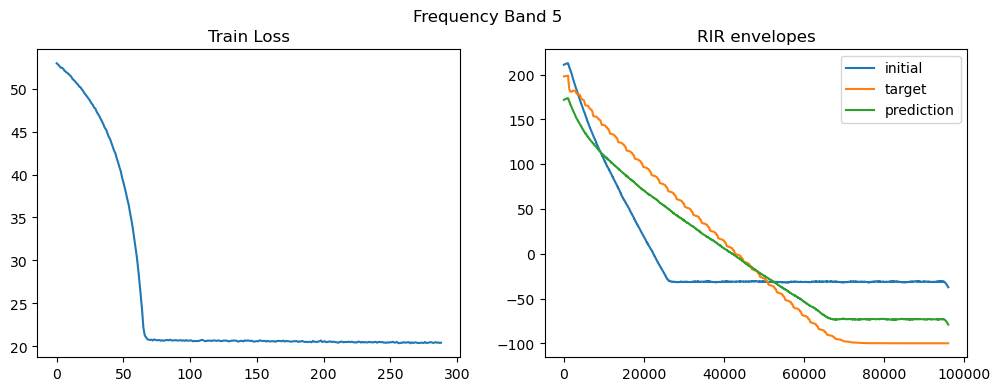

-----trial number: 1------- 
Target Kvalues for band6: (tensor(-0.1015, device='cuda:0'), tensor(-0.2689, device='cuda:0'), tensor(-0.1218, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1040], device='cuda:0')
Ky :  tensor([-0.1160], device='cuda:0')
Kz :  tensor([-0.1410], device='cuda:0')
Loss in epoch:0 is : 63.702728271484375
Loss in epoch:100 is : 35.01112365722656
Loss in epoch:200 is : 35.222469329833984

RIR no:6,
Updated model Params:
Kx :  tensor([-0.0409], device='cuda:0')
Ky :  tensor([-0.1043], device='cuda:0')
Kz :  tensor([-0.1392], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band6: (tensor(-0.1015, device='cuda:0'), tensor(-0.2689, device='cuda:0'), tensor(-0.1218, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1210], device='cuda:0')
Ky :  tensor([-0.1930], device='cuda:0')
Kz :  tensor([-0.1220], device='cuda:0')
Loss in epoch:0 is : 67.6588363647461
Loss in epoch:100 is : 35.744384765625
Loss in epoch:200 is : 35.399703979492

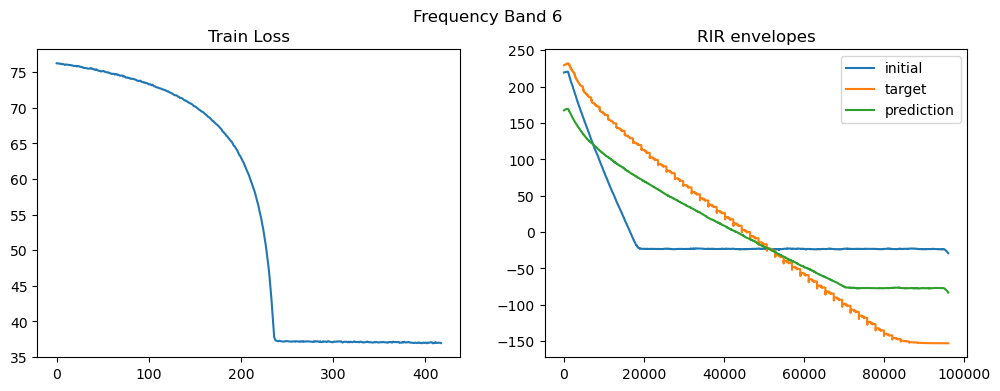

-------------------12th Datapoint out of 14--------------------------
-----trial number: 1------- 
Target Kvalues for band1: (tensor(-0.1031, device='cuda:0'), tensor(-0.1049, device='cuda:0'), tensor(-0.1635, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1340], device='cuda:0')
Ky :  tensor([-0.1990], device='cuda:0')
Kz :  tensor([-0.1060], device='cuda:0')
Loss in epoch:0 is : 37.107418060302734
Loss in epoch:100 is : 3.2960734367370605
Loss in epoch:200 is : 3.601576805114746

RIR no:1,
Updated model Params:
Kx :  tensor([-0.1362], device='cuda:0')
Ky :  tensor([-0.2012], device='cuda:0')
Kz :  tensor([-0.0271], device='cuda:0')


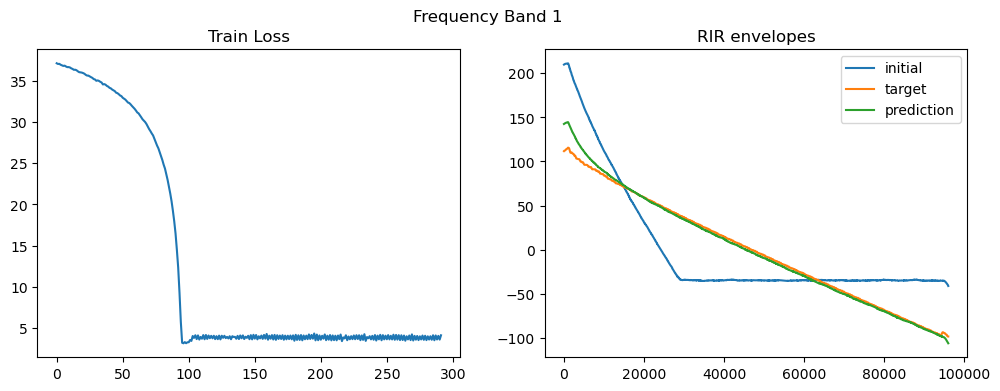

-----trial number: 1------- 
Target Kvalues for band2: (tensor(-0.1031, device='cuda:0'), tensor(-0.1049, device='cuda:0'), tensor(-0.1635, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1130], device='cuda:0')
Ky :  tensor([-0.1110], device='cuda:0')
Kz :  tensor([-0.1190], device='cuda:0')
Loss in epoch:0 is : 37.54375076293945
Loss in epoch:100 is : 29.181663513183594
Loss in epoch:200 is : 3.3234946727752686
Loss in epoch:300 is : 3.482085943222046

RIR no:2,
Updated model Params:
Kx :  tensor([-0.1018], device='cuda:0')
Ky :  tensor([-0.0252], device='cuda:0')
Kz :  tensor([-0.1117], device='cuda:0')


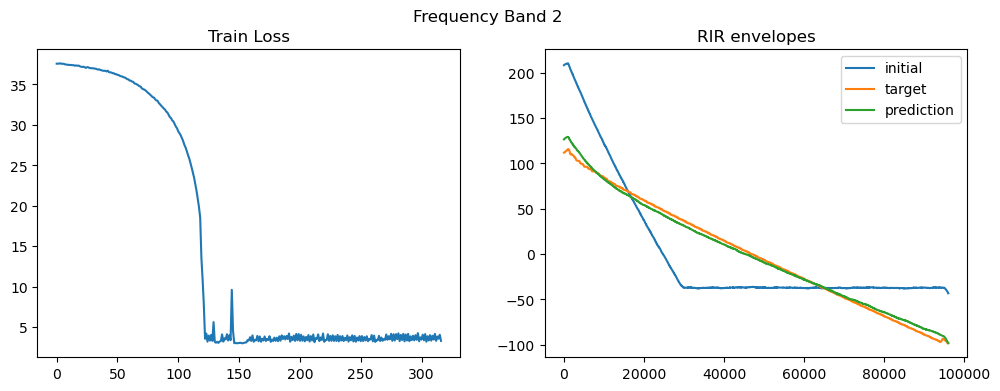

-----trial number: 1------- 
Target Kvalues for band3: (tensor(-0.1031, device='cuda:0'), tensor(-0.1049, device='cuda:0'), tensor(-0.1635, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1970], device='cuda:0')
Ky :  tensor([-0.1240], device='cuda:0')
Kz :  tensor([-0.1080], device='cuda:0')
Loss in epoch:0 is : 37.37158203125
Loss in epoch:100 is : 3.9997735023498535
Loss in epoch:200 is : 3.6094987392425537

RIR no:3,
Updated model Params:
Kx :  tensor([-0.1988], device='cuda:0')
Ky :  tensor([-0.1260], device='cuda:0')
Kz :  tensor([-0.0245], device='cuda:0')


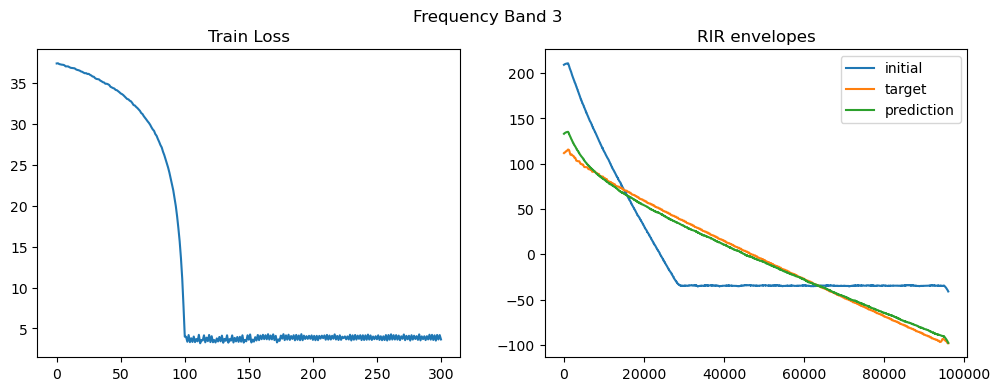

-----trial number: 1------- 
Target Kvalues for band4: (tensor(-0.1031, device='cuda:0'), tensor(-0.1049, device='cuda:0'), tensor(-0.1635, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1890], device='cuda:0')
Ky :  tensor([-0.1690], device='cuda:0')
Kz :  tensor([-0.1280], device='cuda:0')
Loss in epoch:0 is : 39.45065689086914
Loss in epoch:100 is : 34.935874938964844
Loss in epoch:200 is : 3.4647057056427
Loss in epoch:300 is : 3.3914883136749268

RIR no:4,
Updated model Params:
Kx :  tensor([-0.1914], device='cuda:0')
Ky :  tensor([-0.1715], device='cuda:0')
Kz :  tensor([-0.0242], device='cuda:0')


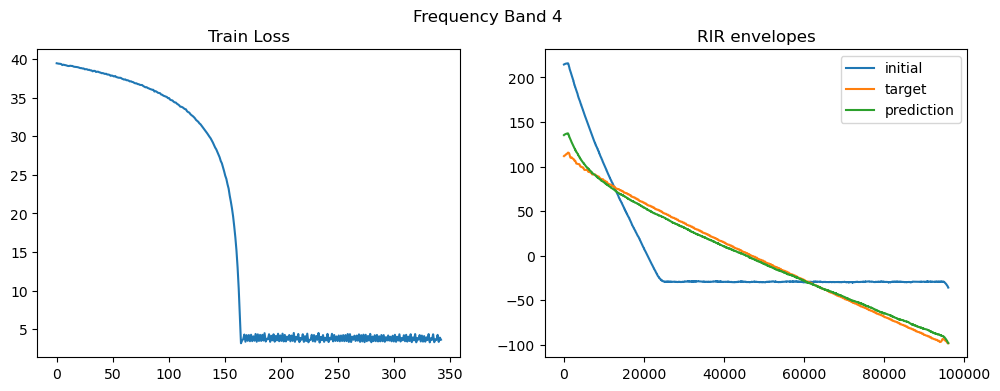

-----trial number: 1------- 
Target Kvalues for band5: (tensor(-0.1031, device='cuda:0'), tensor(-0.1049, device='cuda:0'), tensor(-0.1635, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1250], device='cuda:0')
Ky :  tensor([-0.1980], device='cuda:0')
Kz :  tensor([-0.1210], device='cuda:0')
Loss in epoch:0 is : 38.57453155517578
Loss in epoch:100 is : 34.22156524658203
Loss in epoch:200 is : 3.6650688648223877
Loss in epoch:300 is : 3.6597793102264404

RIR no:5,
Updated model Params:
Kx :  tensor([-0.1227], device='cuda:0')
Ky :  tensor([-0.2003], device='cuda:0')
Kz :  tensor([-0.0273], device='cuda:0')


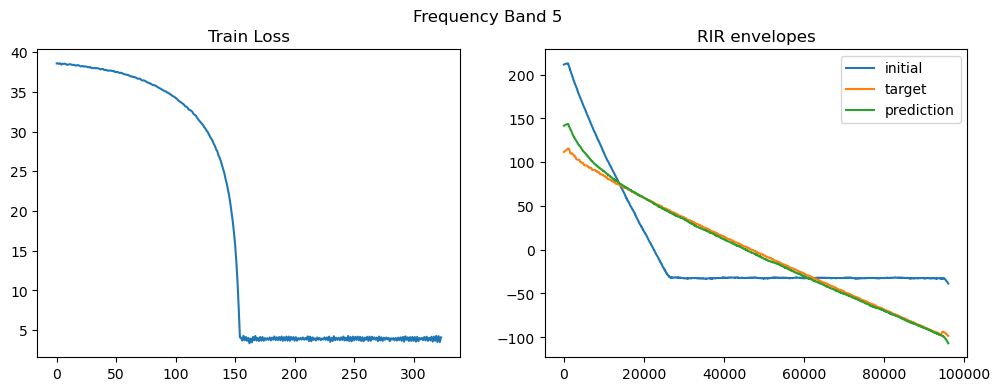

-----trial number: 1------- 
Target Kvalues for band6: (tensor(-0.1031, device='cuda:0'), tensor(-0.1049, device='cuda:0'), tensor(-0.1635, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1520], device='cuda:0')
Ky :  tensor([-0.1010], device='cuda:0')
Kz :  tensor([-0.1570], device='cuda:0')
Loss in epoch:0 is : 34.87645721435547
Loss in epoch:100 is : 1.3870623111724854
Loss in epoch:200 is : 1.5297143459320068

RIR no:6,
Updated model Params:
Kx :  tensor([-0.1529], device='cuda:0')
Ky :  tensor([-0.0282], device='cuda:0')
Kz :  tensor([-0.1578], device='cuda:0')


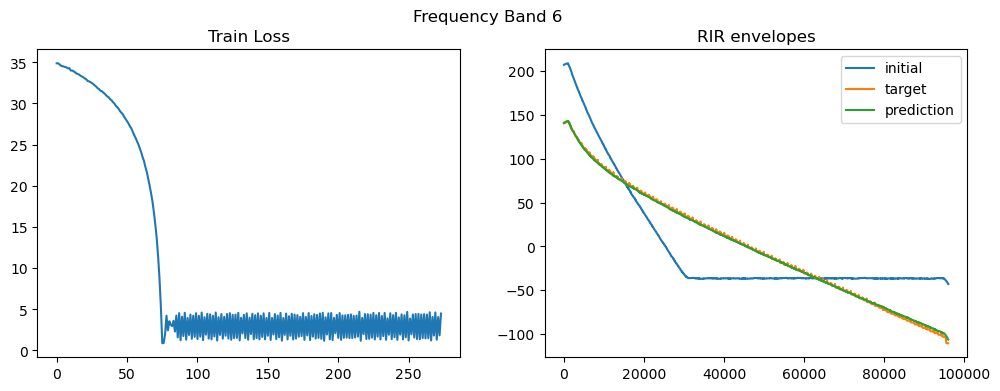

-------------------13th Datapoint out of 14--------------------------
-----trial number: 1------- 
Target Kvalues for band1: (tensor(-0.1022, device='cuda:0'), tensor(-0.2046, device='cuda:0'), tensor(-0.1062, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1080], device='cuda:0')
Ky :  tensor([-0.1120], device='cuda:0')
Kz :  tensor([-0.1960], device='cuda:0')
Loss in epoch:0 is : 35.10274887084961
Loss in epoch:100 is : 27.57656478881836
Loss in epoch:200 is : 2.7199835777282715
Loss in epoch:300 is : 2.9446520805358887

RIR no:1,
Updated model Params:
Kx :  tensor([-0.0252], device='cuda:0')
Ky :  tensor([-0.1140], device='cuda:0')
Kz :  tensor([-0.1992], device='cuda:0')


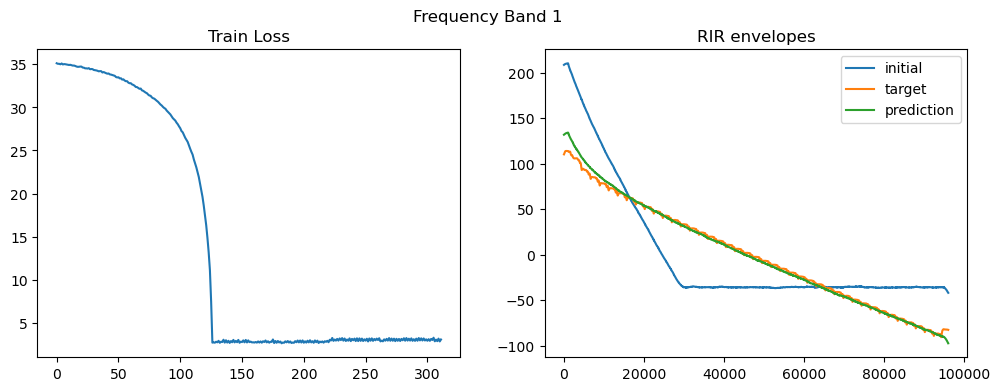

-----trial number: 1------- 
Target Kvalues for band2: (tensor(-0.1022, device='cuda:0'), tensor(-0.2046, device='cuda:0'), tensor(-0.1062, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1230], device='cuda:0')
Ky :  tensor([-0.1810], device='cuda:0')
Kz :  tensor([-0.1040], device='cuda:0')
Loss in epoch:0 is : 34.90529251098633
Loss in epoch:100 is : 14.96740436553955
Loss in epoch:200 is : 2.8520960807800293

RIR no:2,
Updated model Params:
Kx :  tensor([-0.1200], device='cuda:0')
Ky :  tensor([-0.1742], device='cuda:0')
Kz :  tensor([-0.0242], device='cuda:0')


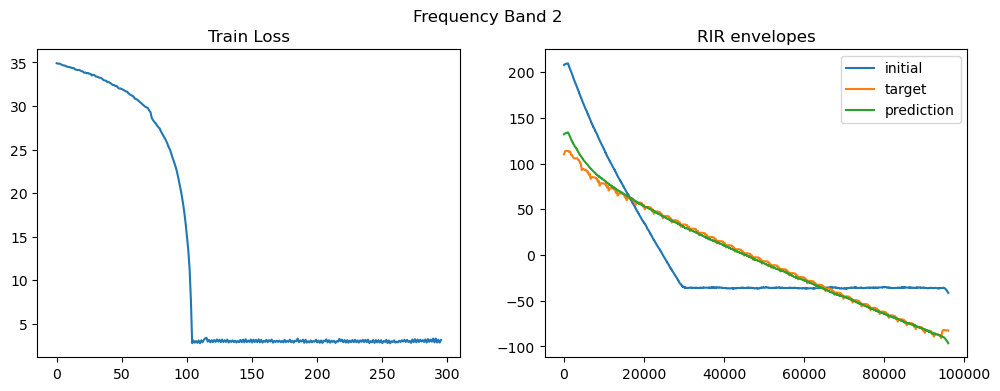

-----trial number: 1------- 
Target Kvalues for band3: (tensor(-0.1022, device='cuda:0'), tensor(-0.2046, device='cuda:0'), tensor(-0.1062, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1290], device='cuda:0')
Ky :  tensor([-0.1080], device='cuda:0')
Kz :  tensor([-0.2000], device='cuda:0')
Loss in epoch:0 is : 35.15467834472656
Loss in epoch:100 is : 24.886186599731445
Loss in epoch:200 is : 3.4022023677825928
Loss in epoch:300 is : 2.7981183528900146

RIR no:3,
Updated model Params:
Kx :  tensor([-0.1278], device='cuda:0')
Ky :  tensor([-0.0231], device='cuda:0')
Kz :  tensor([-0.1952], device='cuda:0')


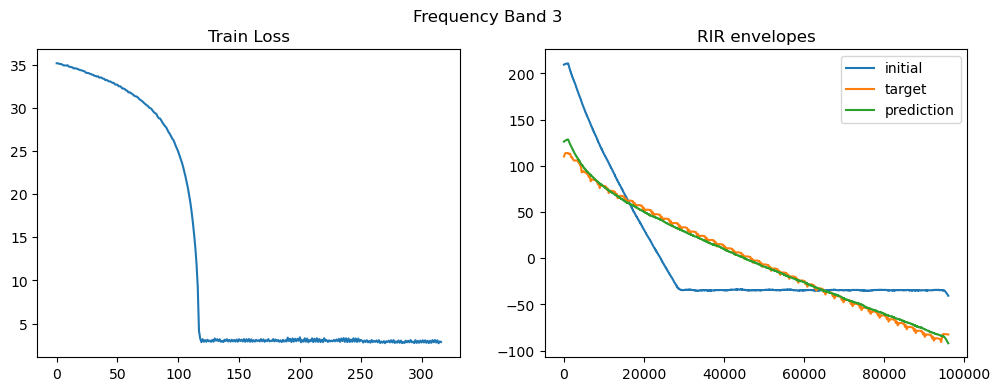

-----trial number: 1------- 
Target Kvalues for band4: (tensor(-0.1022, device='cuda:0'), tensor(-0.2046, device='cuda:0'), tensor(-0.1062, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1110], device='cuda:0')
Ky :  tensor([-0.1060], device='cuda:0')
Kz :  tensor([-0.1050], device='cuda:0')
Loss in epoch:0 is : 35.111141204833984
Loss in epoch:100 is : 31.431055068969727
Loss in epoch:200 is : 2.8009729385375977
Loss in epoch:300 is : 2.8188631534576416

RIR no:4,
Updated model Params:
Kx :  tensor([-0.1154], device='cuda:0')
Ky :  tensor([-0.1012], device='cuda:0')
Kz :  tensor([-0.0242], device='cuda:0')


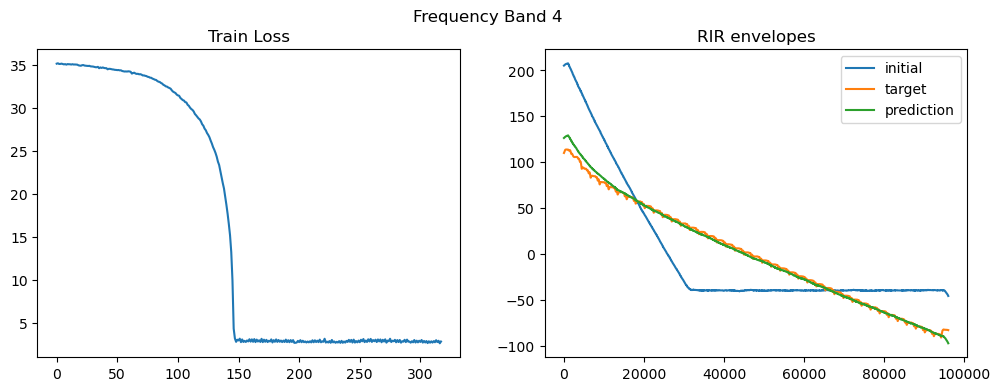

-----trial number: 1------- 
Target Kvalues for band5: (tensor(-0.1022, device='cuda:0'), tensor(-0.2046, device='cuda:0'), tensor(-0.1062, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1370], device='cuda:0')
Ky :  tensor([-0.1280], device='cuda:0')
Kz :  tensor([-0.1240], device='cuda:0')
Loss in epoch:0 is : 36.7533073425293
Loss in epoch:100 is : 34.77577209472656
Loss in epoch:200 is : 7.617232322692871
Loss in epoch:300 is : 3.0571398735046387

RIR no:5,
Updated model Params:
Kx :  tensor([-0.1439], device='cuda:0')
Ky :  tensor([-0.1312], device='cuda:0')
Kz :  tensor([-0.0224], device='cuda:0')


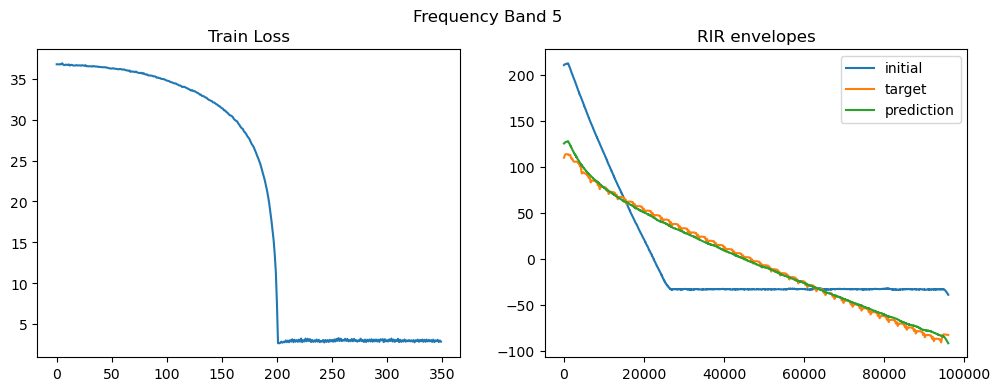

-----trial number: 1------- 
Target Kvalues for band6: (tensor(-0.1022, device='cuda:0'), tensor(-0.2046, device='cuda:0'), tensor(-0.1062, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1980], device='cuda:0')
Ky :  tensor([-0.1480], device='cuda:0')
Kz :  tensor([-0.1210], device='cuda:0')
Loss in epoch:0 is : 35.50254821777344
Loss in epoch:100 is : 29.613561630249023
Loss in epoch:200 is : 2.321455717086792
Loss in epoch:300 is : 2.28505277633667

RIR no:6,
Updated model Params:
Kx :  tensor([-0.1996], device='cuda:0')
Ky :  tensor([-0.1502], device='cuda:0')
Kz :  tensor([-0.0278], device='cuda:0')


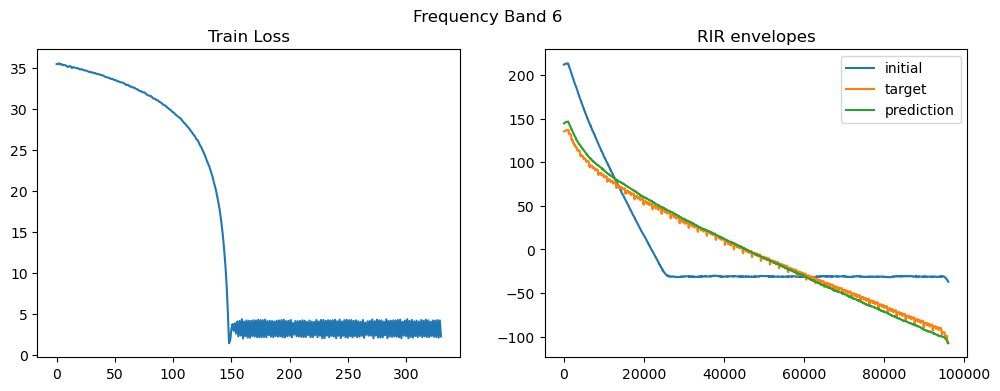

-------------------14th Datapoint out of 14--------------------------
-----trial number: 1------- 
Target Kvalues for band1: (tensor(-0.1629, device='cuda:0'), tensor(-0.1882, device='cuda:0'), tensor(-0.1868, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1280], device='cuda:0')
Ky :  tensor([-0.1230], device='cuda:0')
Kz :  tensor([-0.1850], device='cuda:0')
Loss in epoch:0 is : 43.392765045166016
Loss in epoch:100 is : 16.80130386352539
Loss in epoch:200 is : 16.72447395324707

RIR no:1,
Updated model Params:
Kx :  tensor([-0.1107], device='cuda:0')
Ky :  tensor([-0.0517], device='cuda:0')
Kz :  tensor([-0.1904], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band1: (tensor(-0.1629, device='cuda:0'), tensor(-0.1882, device='cuda:0'), tensor(-0.1868, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1760], device='cuda:0')
Ky :  tensor([-0.1280], device='cuda:0')
Kz :  tensor([-0.1200], device='cuda:0')
Loss in epoch:0 is : 42.85634231567383
Loss in

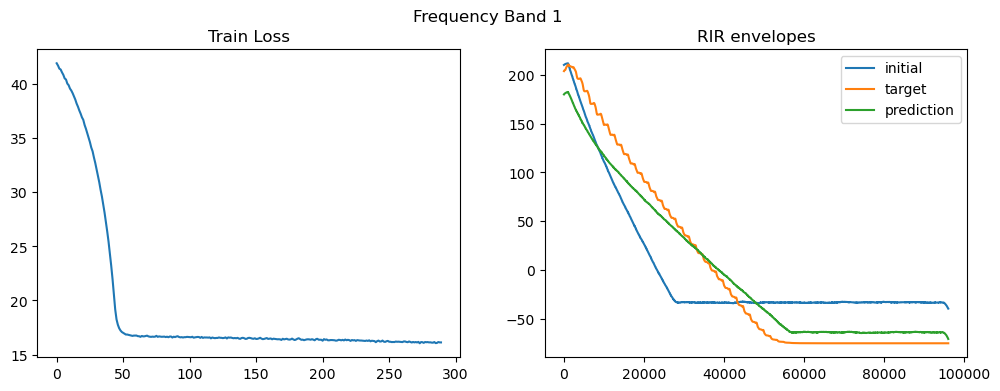

-----trial number: 1------- 
Target Kvalues for band2: (tensor(-0.1629, device='cuda:0'), tensor(-0.1882, device='cuda:0'), tensor(-0.1868, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1240], device='cuda:0')
Ky :  tensor([-0.1090], device='cuda:0')
Kz :  tensor([-0.1750], device='cuda:0')
Loss in epoch:0 is : 40.06449508666992
Loss in epoch:100 is : 16.13319206237793
Loss in epoch:200 is : 15.806854248046875

RIR no:2,
Updated model Params:
Kx :  tensor([-0.0929], device='cuda:0')
Ky :  tensor([-0.0530], device='cuda:0')
Kz :  tensor([-0.1557], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band2: (tensor(-0.1629, device='cuda:0'), tensor(-0.1882, device='cuda:0'), tensor(-0.1868, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1240], device='cuda:0')
Ky :  tensor([-0.1580], device='cuda:0')
Kz :  tensor([-0.1130], device='cuda:0')
Loss in epoch:0 is : 40.77436447143555
Loss in epoch:100 is : 15.828859329223633
Loss in epoch:200 is : 15.440935134

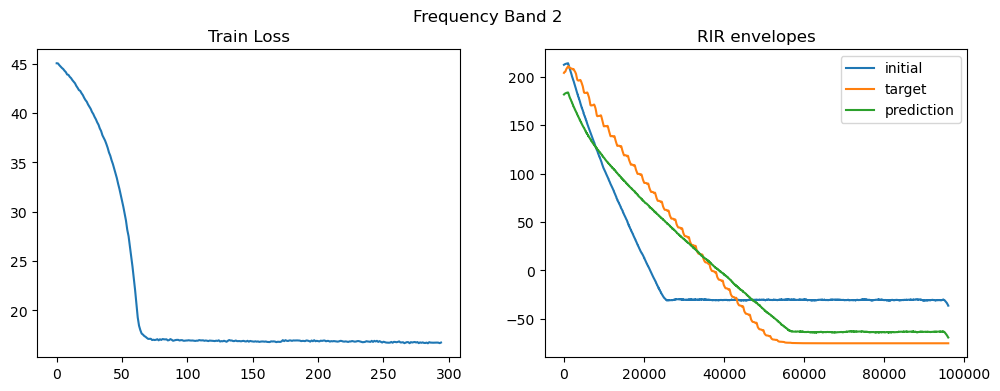

-----trial number: 1------- 
Target Kvalues for band3: (tensor(-0.1629, device='cuda:0'), tensor(-0.1882, device='cuda:0'), tensor(-0.1868, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1620], device='cuda:0')
Ky :  tensor([-0.1710], device='cuda:0')
Kz :  tensor([-0.1310], device='cuda:0')
Loss in epoch:0 is : 46.42138671875
Loss in epoch:100 is : 16.909759521484375
Loss in epoch:200 is : 16.88982582092285

RIR no:3,
Updated model Params:
Kx :  tensor([-0.1552], device='cuda:0')
Ky :  tensor([-0.1665], device='cuda:0')
Kz :  tensor([-0.0501], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band3: (tensor(-0.1629, device='cuda:0'), tensor(-0.1882, device='cuda:0'), tensor(-0.1868, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1630], device='cuda:0')
Ky :  tensor([-0.1400], device='cuda:0')
Kz :  tensor([-0.1380], device='cuda:0')
Loss in epoch:0 is : 46.177894592285156
Loss in epoch:100 is : 26.001453399658203
Loss in epoch:200 is : 15.54289054870

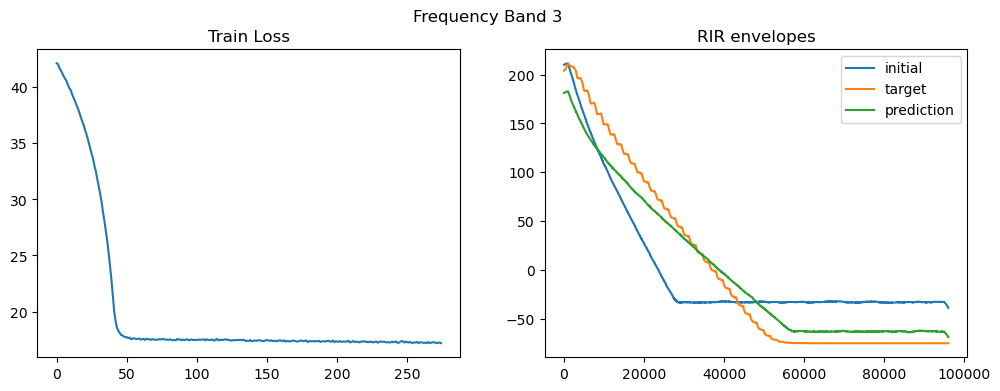

-----trial number: 1------- 
Target Kvalues for band4: (tensor(-0.1629, device='cuda:0'), tensor(-0.1882, device='cuda:0'), tensor(-0.1868, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1060], device='cuda:0')
Ky :  tensor([-0.1990], device='cuda:0')
Kz :  tensor([-0.1300], device='cuda:0')
Loss in epoch:0 is : 40.012760162353516
Loss in epoch:100 is : 16.75237464904785
Loss in epoch:200 is : 16.563875198364258

RIR no:4,
Updated model Params:
Kx :  tensor([-0.0517], device='cuda:0')
Ky :  tensor([-0.1904], device='cuda:0')
Kz :  tensor([-0.1107], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band4: (tensor(-0.1629, device='cuda:0'), tensor(-0.1882, device='cuda:0'), tensor(-0.1868, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1830], device='cuda:0')
Ky :  tensor([-0.1400], device='cuda:0')
Kz :  tensor([-0.1760], device='cuda:0')
Loss in epoch:0 is : 48.43097686767578
Loss in epoch:100 is : 17.45437240600586
Loss in epoch:200 is : 17.231456756

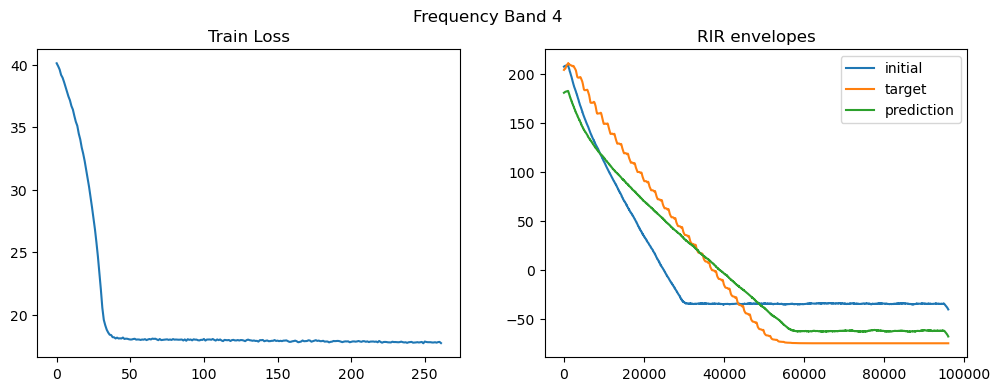

-----trial number: 1------- 
Target Kvalues for band5: (tensor(-0.1629, device='cuda:0'), tensor(-0.1882, device='cuda:0'), tensor(-0.1868, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1780], device='cuda:0')
Ky :  tensor([-0.1880], device='cuda:0')
Kz :  tensor([-0.1450], device='cuda:0')
Loss in epoch:0 is : 49.57855224609375
Loss in epoch:100 is : 22.73151969909668
Loss in epoch:200 is : 17.32864761352539
Loss in epoch:300 is : 17.147424697875977

RIR no:5,
Updated model Params:
Kx :  tensor([-0.1584], device='cuda:0')
Ky :  tensor([-0.1699], device='cuda:0')
Kz :  tensor([-0.0500], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band5: (tensor(-0.1629, device='cuda:0'), tensor(-0.1882, device='cuda:0'), tensor(-0.1868, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1500], device='cuda:0')
Ky :  tensor([-0.1820], device='cuda:0')
Kz :  tensor([-0.1540], device='cuda:0')
Loss in epoch:0 is : 48.947425842285156
Loss in epoch:100 is : 36.204437255

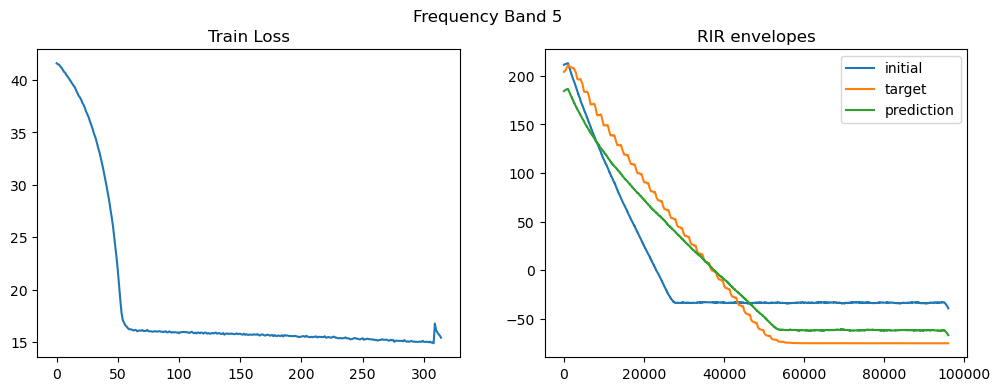

-----trial number: 1------- 
Target Kvalues for band6: (tensor(-0.1629, device='cuda:0'), tensor(-0.1882, device='cuda:0'), tensor(-0.1868, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1490], device='cuda:0')
Ky :  tensor([-0.1120], device='cuda:0')
Kz :  tensor([-0.1780], device='cuda:0')
Loss in epoch:0 is : 70.84954833984375
Loss in epoch:100 is : 41.88117218017578
Loss in epoch:200 is : 41.547550201416016

RIR no:6,
Updated model Params:
Kx :  tensor([-0.1288], device='cuda:0')
Ky :  tensor([-0.0446], device='cuda:0')
Kz :  tensor([-0.1613], device='cuda:0')
-----trial number: 2------- 
Target Kvalues for band6: (tensor(-0.1629, device='cuda:0'), tensor(-0.1882, device='cuda:0'), tensor(-0.1868, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1200], device='cuda:0')
Ky :  tensor([-0.1010], device='cuda:0')
Kz :  tensor([-0.1420], device='cuda:0')
Loss in epoch:0 is : 66.43285369873047
Loss in epoch:100 is : 40.40924835205078
Loss in epoch:200 is : 40.3777694702

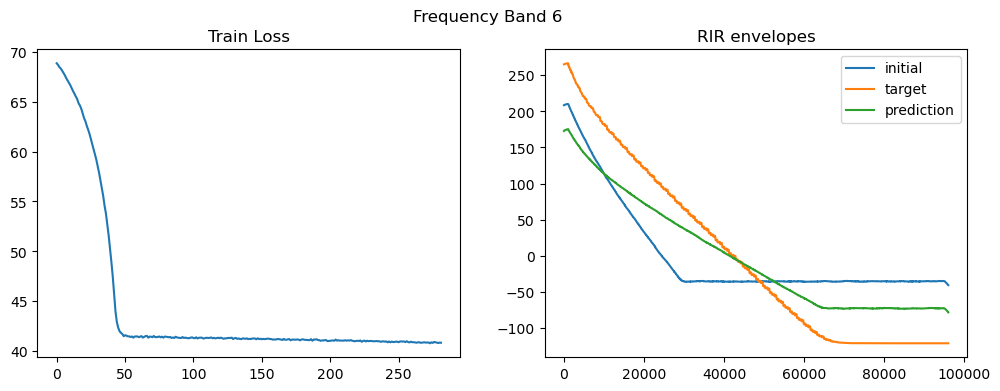

In [21]:
# Generated RIR training - Frequency Dependent case
# hyper params
iter_ = 1551
lr = 0.000003
env_filter_len = 2047
signal_gain = 100    # dB
dB_clip = None
normalize = True
# params
device = 'cuda'
logging_frequency = 100     # epochs  
stopping_criterion = 200    # epochs
accepted_loss = 6       # dB
convergence_trials = 3
# For real RIR
rir_data = torch.tensor(rir_np, dtype=torch.float).to(device=device)

for i in range(rir_data.size(0)):
    print(f"-------------------{i+1}th Datapoint out of {rir_data.size(0)}--------------------------")
    lengths, betas, rir_ = rir_data[i, :3], rir_data[i, 3:9], rir_data[i, 9:]
    labels = rir_bands(rir_, device=device)
    target_K_values = calculate_K(betas, lengths)
    #print("Target: ", target_K_values)
    nBands = labels.size(1)
    k_array = torch.zeros((nBands, 3)).to(device=device)
    #
    for j in range(nBands):
        #
        not_converged = True
        converge_counter = 0
        while not_converged:
            converge_counter += 1
            print(f"-----trial number: {converge_counter}------- ")
            # for each frequency band
            print(f"Target Kvalues for band{j+1}: {target_K_values[:]}")
            l_env = env_makerF(labels[:, j], filter_len=env_filter_len , gain=signal_gain, clip_=dB_clip, normalise=normalize,device=device)
            mod = RIR_model(device=device).to(device=device)
            crit = torch.nn.L1Loss().to(device=device)
            optim = torch.optim.SGD(mod.parameters(),lr=lr)
            init_param_dict = {}
            print("Initial model Params:")
            for name, param in mod.named_parameters():
                if param.requires_grad:
                    print( name,': ', param.data)
                    init_param_dict.update({name:param.data.clone()})

            t_l = []
            early_stopping = 0
            min_loss = torch.inf
            for i in range(iter_):
                optim.zero_grad()
                y_hat = mod.forward()
                x_env = env_makerF(y_hat, filter_len=env_filter_len , gain=signal_gain, clip_=dB_clip, normalise=normalize,device=device)
                l = crit(x_env, l_env)
                # l = torch.mean(torch.abs(x_env - l_env))
                l.backward()
                optim.step()
                log_l = l.detach().cpu()
                t_l.append(log_l)
                # early stopping
                # early stopping for convergent cases
                if log_l < min_loss:
                    min_loss = log_l
                else:
                    early_stopping += 1       
                if early_stopping > stopping_criterion: 
                    # converge case
                    if min_loss < accepted_loss: not_converged=False   
                    # tried but not converged  
                    if converge_counter > convergence_trials: not_converged=False
                    break
                if i%logging_frequency == 0 : print(f'Loss in epoch:{i} is : {l.detach()}')
            

            print(f"\nRIR no:{j+1},\nUpdated model Params:")
            final_param_collector = torch.zeros((1)).to(device=device)
            for name, param in mod.named_parameters():
                if param.requires_grad:
                    print( name,': ', param.data)
                    final_param_collector = torch.concat((final_param_collector, param.data.view(-1)))
            final_param_collector = final_param_collector[1:]
            k_array[j, :] = final_param_collector

    #   
        # print(param_dict)
        plt.figure(j+1, figsize=(12,4))
        plt.suptitle(f"Frequency Band {j+1}")
        plt.subplot(1,2,1)
        plt.plot(t_l,)# linestyle='', marker='.')
        plt.title("Train Loss")
        plt.subplot(1,2,2)
        plt.plot(env_makerF(generate_stochastic_rir(Kx=init_param_dict['Kx'], Ky=init_param_dict['Ky'], Kz=init_param_dict['Kz'], device=device), filter_len=env_filter_len, gain=signal_gain, clip_=dB_clip, normalise=normalize,device=device).detach().cpu(), label='initial')
        plt.plot(l_env.detach().cpu(),  label='target')
        plt.plot(env_makerF(mod.forward().detach(), filter_len=env_filter_len, gain=signal_gain, clip_=dB_clip, normalise=normalize,device=device).detach().cpu(), label='prediction')
        plt.title("RIR envelopes")
        plt.legend()
        plt.show()
    

-------------------1th Datapoint out of 14--------------------------


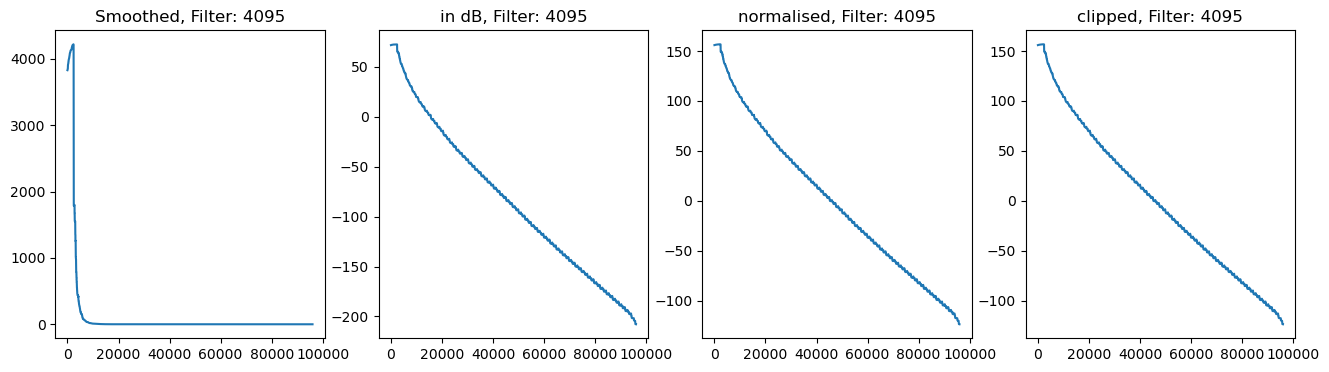

Target params: Kx:-0.037759095430374146, Ky:-0.13621051609516144, KZ:-0.2648499608039856
Inital Params: 

Kx :  tensor([-0.0103], device='cuda:0')
Ky :  tensor([-0.0115], device='cuda:0')
Kz :  tensor([-0.0157], device='cuda:0')
Loss in epoch:0 is : 39.017181396484375
Loss in epoch:100 is : 2.6620774269104004
Loss in epoch:200 is : 3.0284478664398193
Updated Params: 

Kx :  tensor([-0.0352], device='cuda:0')
Ky :  tensor([-0.0463], device='cuda:0')
Kz :  tensor([-0.0478], device='cuda:0')


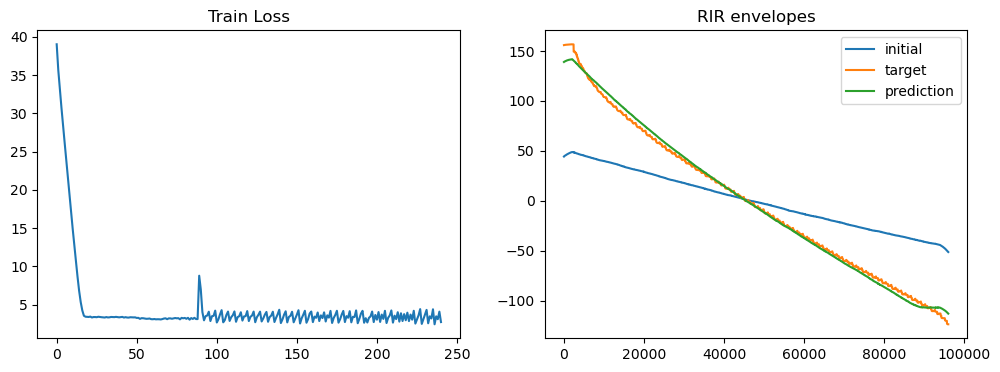

-------------------2th Datapoint out of 14--------------------------


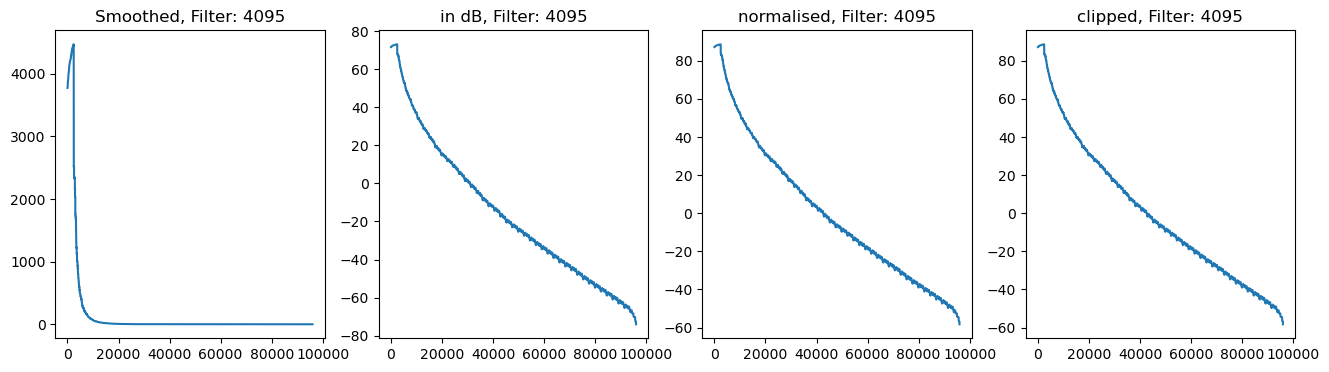

Target params: Kx:-0.02085677720606327, Ky:-0.13555516302585602, KZ:-0.22113537788391113
Inital Params: 

Kx :  tensor([-0.0118], device='cuda:0')
Ky :  tensor([-0.0121], device='cuda:0')
Kz :  tensor([-0.0120], device='cuda:0')
Loss in epoch:0 is : 7.001413345336914
Loss in epoch:100 is : 30.253202438354492
Loss in epoch:200 is : 30.18718147277832
Updated Params: 

Kx :  tensor([0.0054], device='cuda:0')
Ky :  tensor([0.0303], device='cuda:0')
Kz :  tensor([0.0348], device='cuda:0')


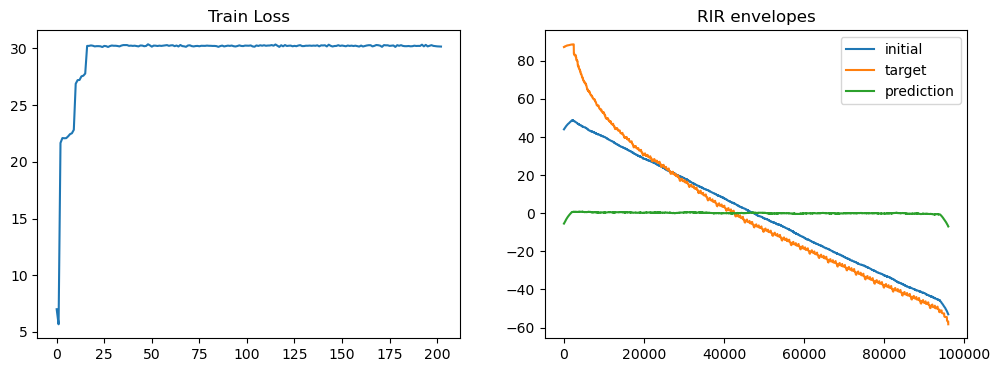

-------------------3th Datapoint out of 14--------------------------


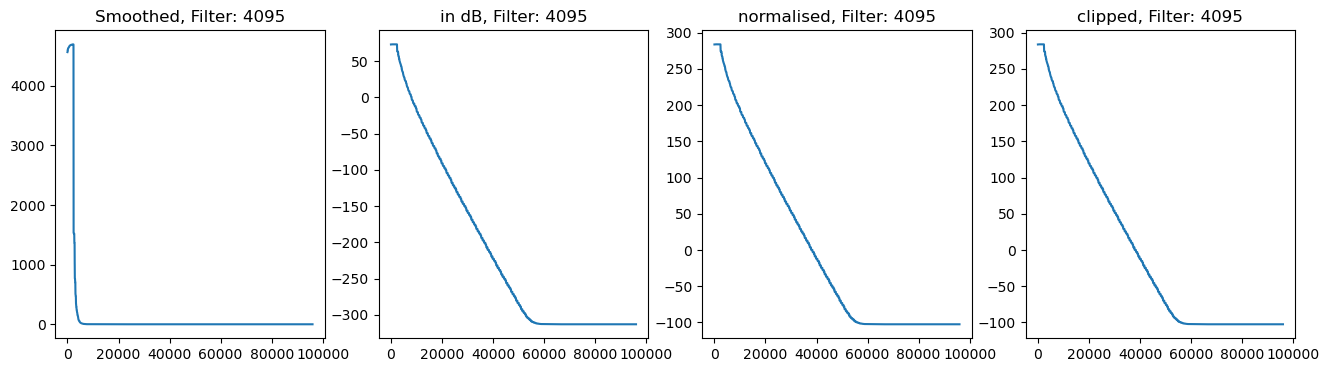

Target params: Kx:-0.2197013944387436, Ky:-0.16513541340827942, KZ:-0.18652649223804474
Inital Params: 

Kx :  tensor([-0.0147], device='cuda:0')
Ky :  tensor([-0.0170], device='cuda:0')
Kz :  tensor([-0.0182], device='cuda:0')
Loss in epoch:0 is : 74.53803253173828
Loss in epoch:100 is : 33.84675598144531
Loss in epoch:200 is : 33.74427032470703
Updated Params: 

Kx :  tensor([-0.0544], device='cuda:0')
Ky :  tensor([-0.0544], device='cuda:0')
Kz :  tensor([-0.0542], device='cuda:0')
Target params: Kx:-0.2197013944387436, Ky:-0.16513541340827942, KZ:-0.18652649223804474
Inital Params: 

Kx :  tensor([-0.0121], device='cuda:0')
Ky :  tensor([-0.0191], device='cuda:0')
Kz :  tensor([-0.0128], device='cuda:0')
Loss in epoch:0 is : 79.14244079589844
Loss in epoch:100 is : 33.82614517211914
Loss in epoch:200 is : 33.82849884033203
Updated Params: 

Kx :  tensor([-0.0547], device='cuda:0')
Ky :  tensor([-0.0547], device='cuda:0')
Kz :  tensor([-0.0545], device='cuda:0')
Target params: Kx:-0

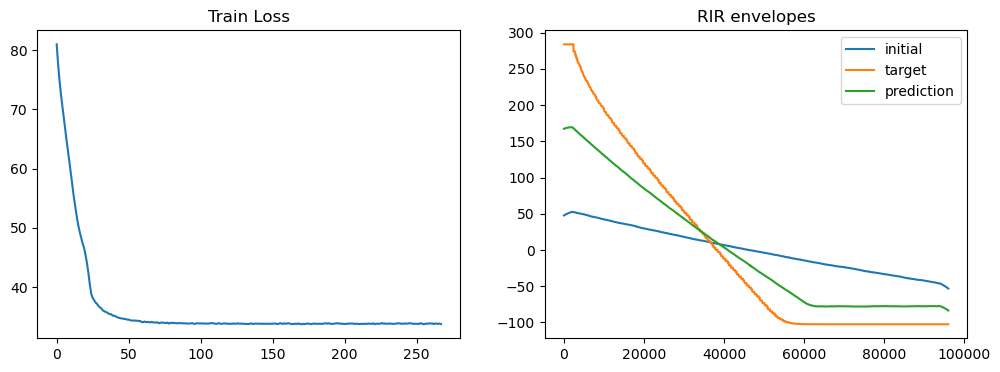

-------------------4th Datapoint out of 14--------------------------


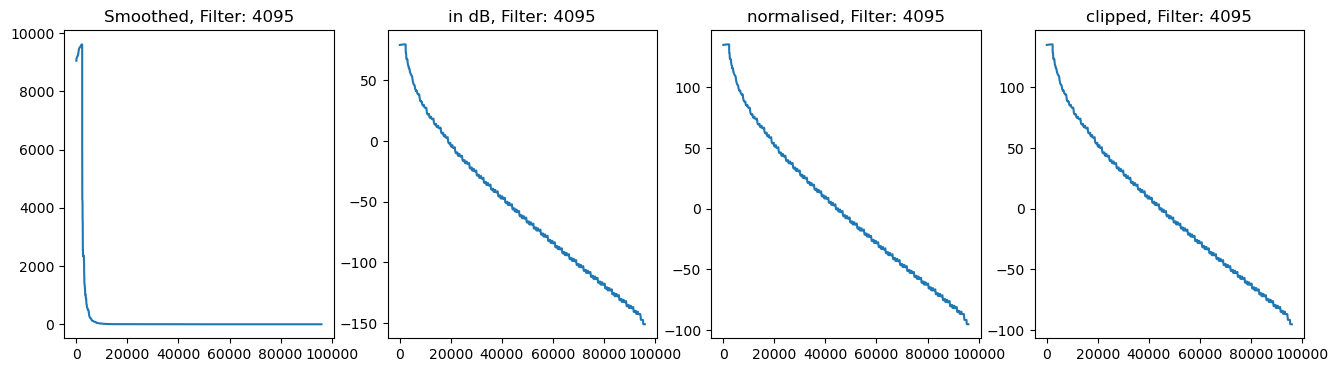

Target params: Kx:-0.09025770425796509, Ky:-0.15211397409439087, KZ:-0.06648693978786469
Inital Params: 

Kx :  tensor([-0.0177], device='cuda:0')
Ky :  tensor([-0.0150], device='cuda:0')
Kz :  tensor([-0.0111], device='cuda:0')
Loss in epoch:0 is : 22.20048713684082
Loss in epoch:100 is : 3.924431324005127
Loss in epoch:200 is : 4.069241046905518
Updated Params: 

Kx :  tensor([-0.0532], device='cuda:0')
Ky :  tensor([-0.0555], device='cuda:0')
Kz :  tensor([-0.0228], device='cuda:0')


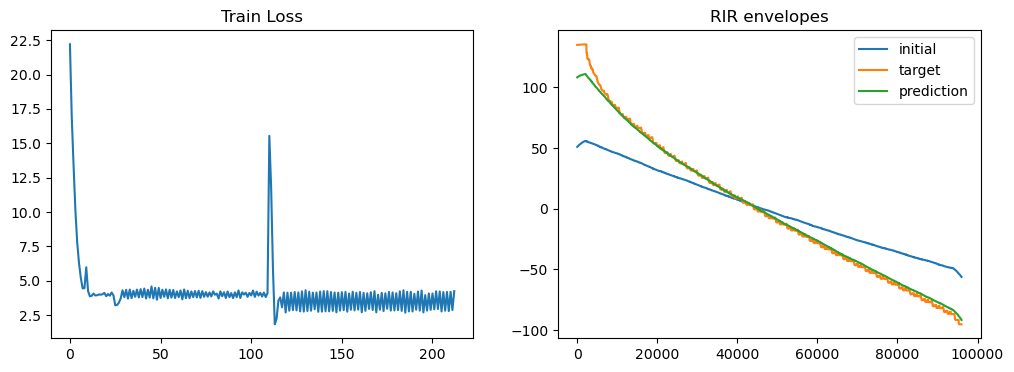

-------------------5th Datapoint out of 14--------------------------


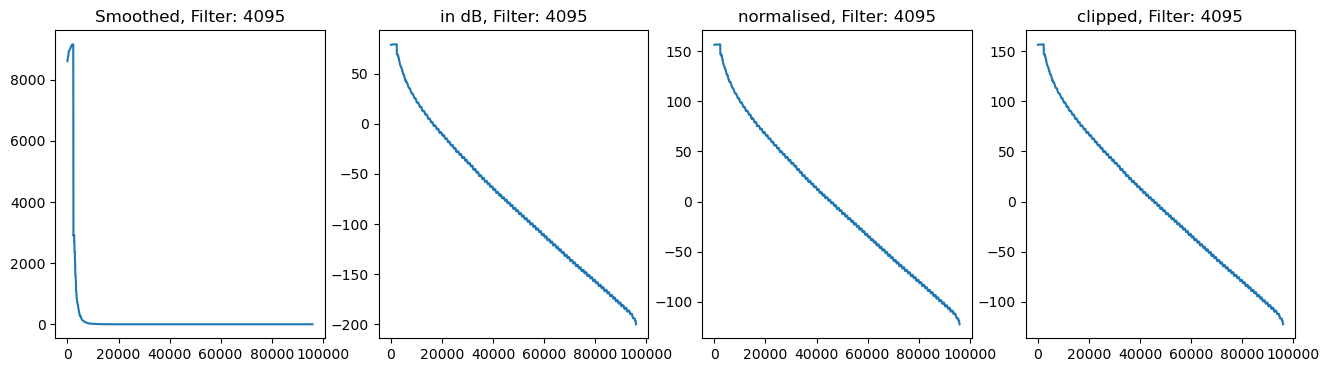

Target params: Kx:-0.07319147884845734, Ky:-0.21816284954547882, KZ:-0.0953492522239685
Inital Params: 

Kx :  tensor([-0.0154], device='cuda:0')
Ky :  tensor([-0.0143], device='cuda:0')
Kz :  tensor([-0.0115], device='cuda:0')
Loss in epoch:0 is : 34.32606506347656
Loss in epoch:100 is : 2.3891773223876953
Loss in epoch:200 is : 2.4074246883392334
Updated Params: 

Kx :  tensor([-0.0553], device='cuda:0')
Ky :  tensor([-0.0538], device='cuda:0')
Kz :  tensor([-0.0310], device='cuda:0')


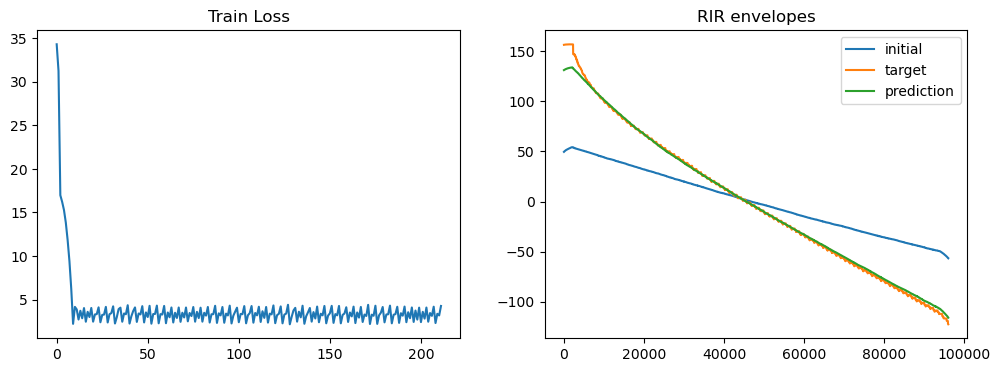

-------------------6th Datapoint out of 14--------------------------


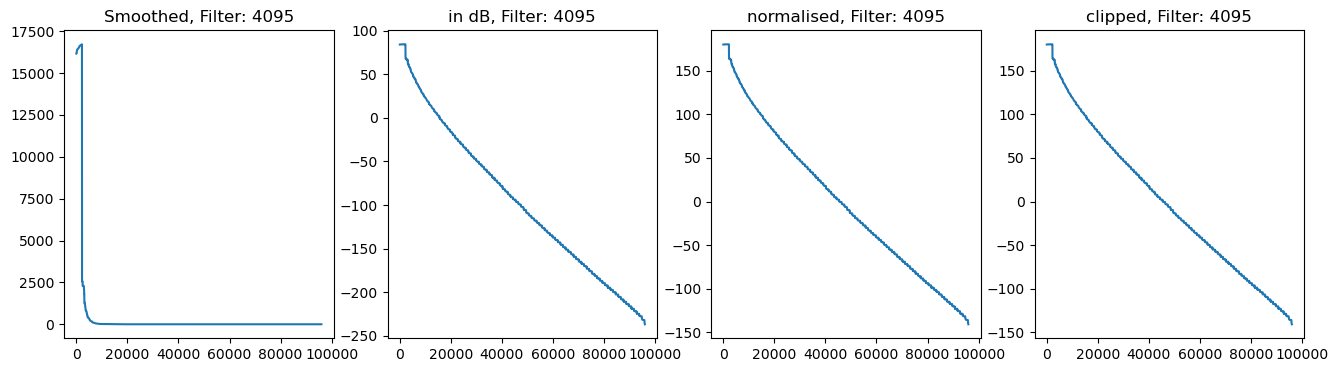

Target params: Kx:-0.13694141805171967, Ky:-0.0665481686592102, KZ:-0.16792285442352295
Inital Params: 

Kx :  tensor([-0.0133], device='cuda:0')
Ky :  tensor([-0.0183], device='cuda:0')
Kz :  tensor([-0.0170], device='cuda:0')
Loss in epoch:0 is : 41.73551559448242
Loss in epoch:100 is : 4.296730041503906
Loss in epoch:200 is : 4.209646224975586
Updated Params: 

Kx :  tensor([-0.0373], device='cuda:0')
Ky :  tensor([-0.0557], device='cuda:0')
Kz :  tensor([-0.0572], device='cuda:0')


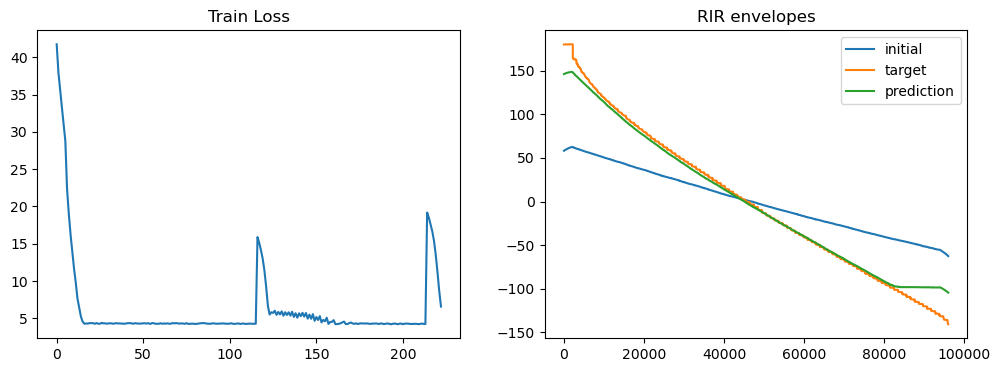

-------------------7th Datapoint out of 14--------------------------


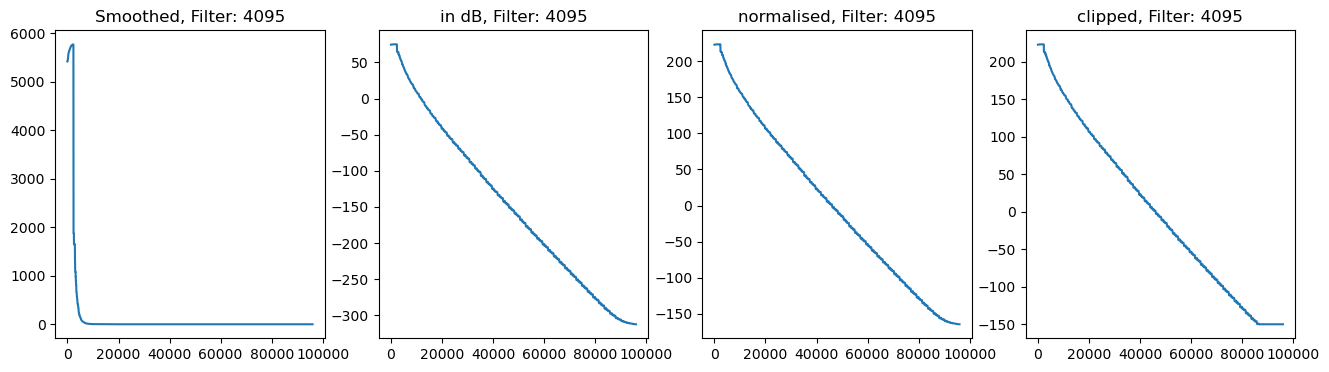

Target params: Kx:-0.13098092377185822, Ky:-0.11020901054143906, KZ:-0.13609525561332703
Inital Params: 

Kx :  tensor([-0.0199], device='cuda:0')
Ky :  tensor([-0.0145], device='cuda:0')
Kz :  tensor([-0.0183], device='cuda:0')
Loss in epoch:0 is : 63.365447998046875
Loss in epoch:100 is : 27.47321128845215
Loss in epoch:200 is : 25.067142486572266
Updated Params: 

Kx :  tensor([-0.0451], device='cuda:0')
Ky :  tensor([-0.0451], device='cuda:0')
Kz :  tensor([-0.0449], device='cuda:0')
Target params: Kx:-0.13098092377185822, Ky:-0.11020901054143906, KZ:-0.13609525561332703
Inital Params: 

Kx :  tensor([-0.0121], device='cuda:0')
Ky :  tensor([-0.0159], device='cuda:0')
Kz :  tensor([-0.0153], device='cuda:0')
Loss in epoch:0 is : 68.04521942138672
Loss in epoch:100 is : 25.820775985717773
Loss in epoch:200 is : 25.079620361328125
Updated Params: 

Kx :  tensor([-0.0451], device='cuda:0')
Ky :  tensor([-0.0451], device='cuda:0')
Kz :  tensor([-0.0449], device='cuda:0')
Target params:

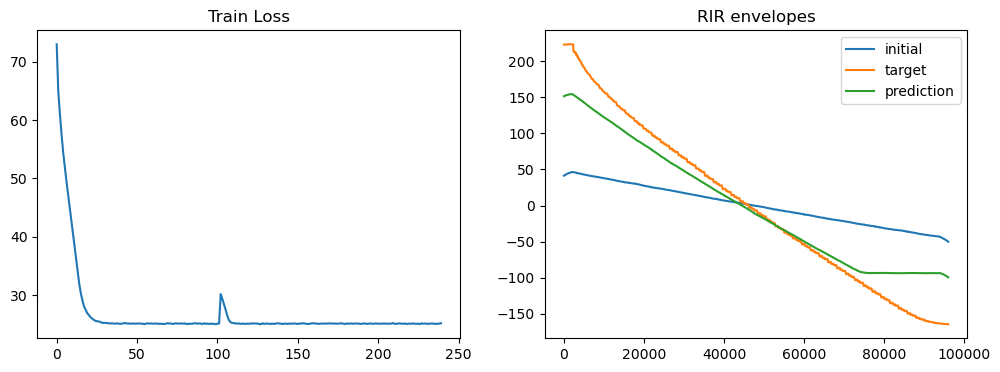

-------------------8th Datapoint out of 14--------------------------


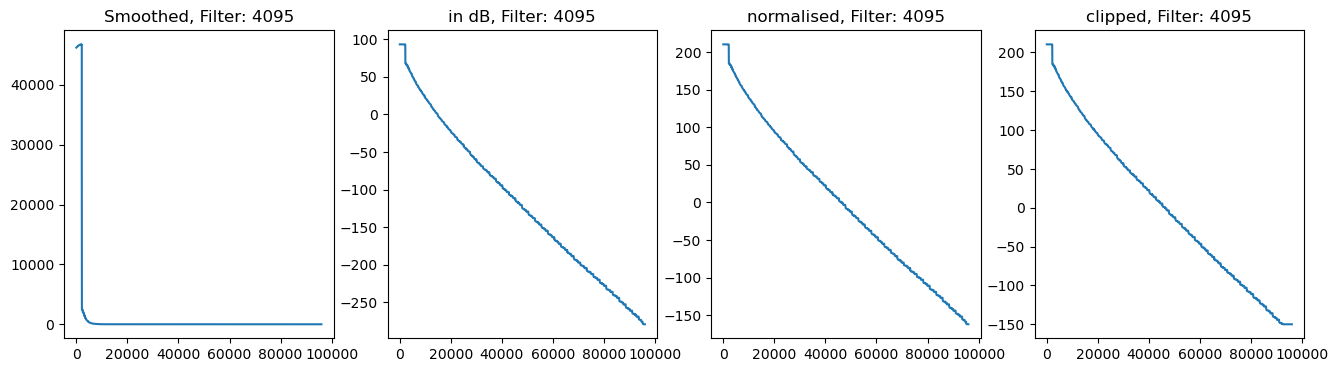

Target params: Kx:-0.08587110787630081, Ky:-0.06375109404325485, KZ:-0.11472395062446594
Inital Params: 

Kx :  tensor([-0.0186], device='cuda:0')
Ky :  tensor([-0.0116], device='cuda:0')
Kz :  tensor([-0.0149], device='cuda:0')
Loss in epoch:0 is : 57.05791473388672
Loss in epoch:100 is : 84.9414291381836
Loss in epoch:200 is : 84.92557525634766
Updated Params: 

Kx :  tensor([0.0025], device='cuda:0')
Ky :  tensor([0.0024], device='cuda:0')
Kz :  tensor([0.0037], device='cuda:0')
Target params: Kx:-0.08587110787630081, Ky:-0.06375109404325485, KZ:-0.11472395062446594
Inital Params: 

Kx :  tensor([-0.0137], device='cuda:0')
Ky :  tensor([-0.0123], device='cuda:0')
Kz :  tensor([-0.0162], device='cuda:0')
Loss in epoch:0 is : 57.337677001953125
Loss in epoch:100 is : 14.535719871520996
Loss in epoch:200 is : 14.534008026123047
Updated Params: 

Kx :  tensor([-0.0433], device='cuda:0')
Ky :  tensor([-0.0433], device='cuda:0')
Kz :  tensor([-0.0431], device='cuda:0')
Target params: Kx:-

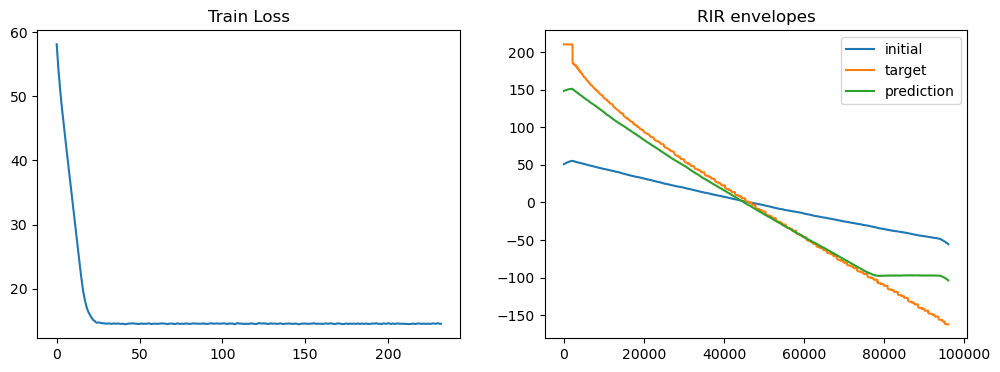

-------------------9th Datapoint out of 14--------------------------


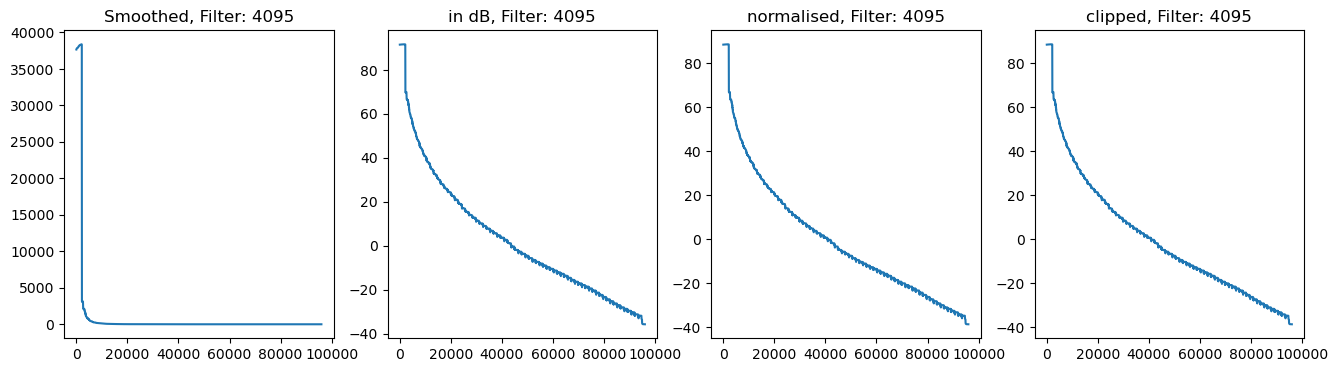

Target params: Kx:-0.031111838296055794, Ky:-0.14292532205581665, KZ:-0.18119728565216064
Inital Params: 

Kx :  tensor([-0.0155], device='cuda:0')
Ky :  tensor([-0.0141], device='cuda:0')
Kz :  tensor([-0.0160], device='cuda:0')
Loss in epoch:0 is : 11.02568244934082
Loss in epoch:100 is : 4.701988697052002
Loss in epoch:200 is : 4.655534267425537
Updated Params: 

Kx :  tensor([-0.0382], device='cuda:0')
Ky :  tensor([-0.0045], device='cuda:0')
Kz :  tensor([-0.0440], device='cuda:0')


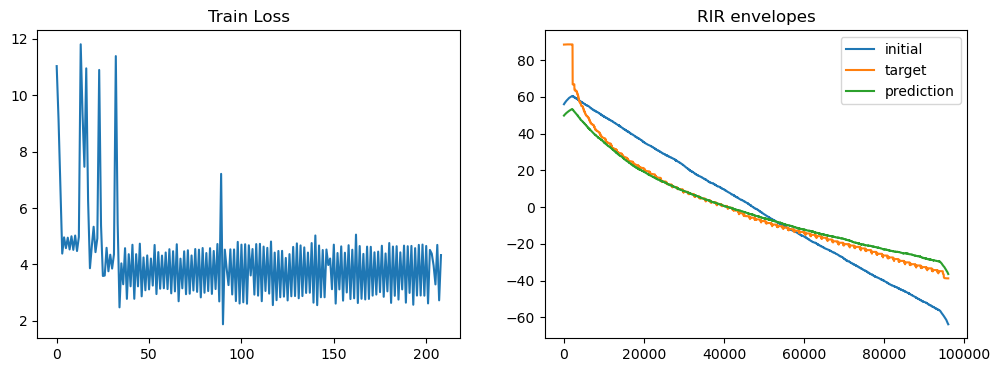

-------------------10th Datapoint out of 14--------------------------


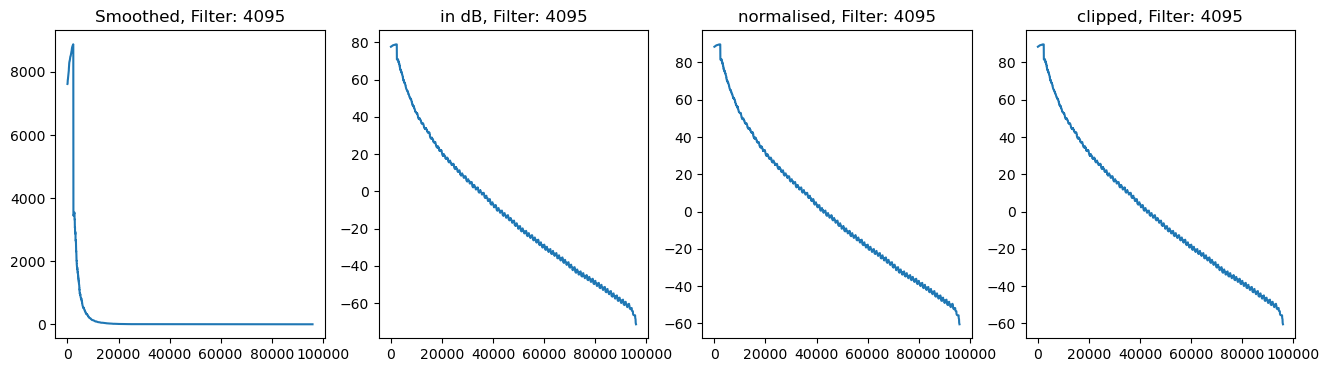

Target params: Kx:-0.05069904774427414, Ky:-0.03998503461480141, KZ:-0.11646449565887451
Inital Params: 

Kx :  tensor([-0.0155], device='cuda:0')
Ky :  tensor([-0.0142], device='cuda:0')
Kz :  tensor([-0.0197], device='cuda:0')
Loss in epoch:0 is : 4.721266746520996
Loss in epoch:100 is : 2.9714531898498535
Loss in epoch:200 is : 2.7859392166137695
Updated Params: 

Kx :  tensor([-0.0322], device='cuda:0')
Ky :  tensor([-0.0107], device='cuda:0')
Kz :  tensor([-0.0341], device='cuda:0')


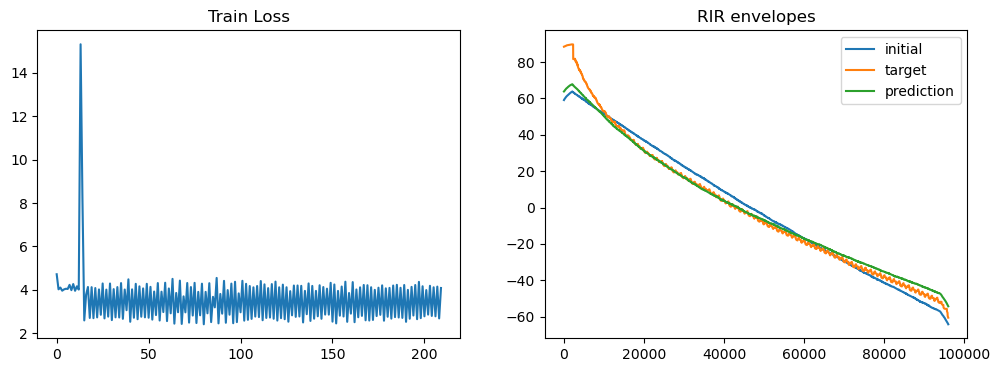

-------------------11th Datapoint out of 14--------------------------


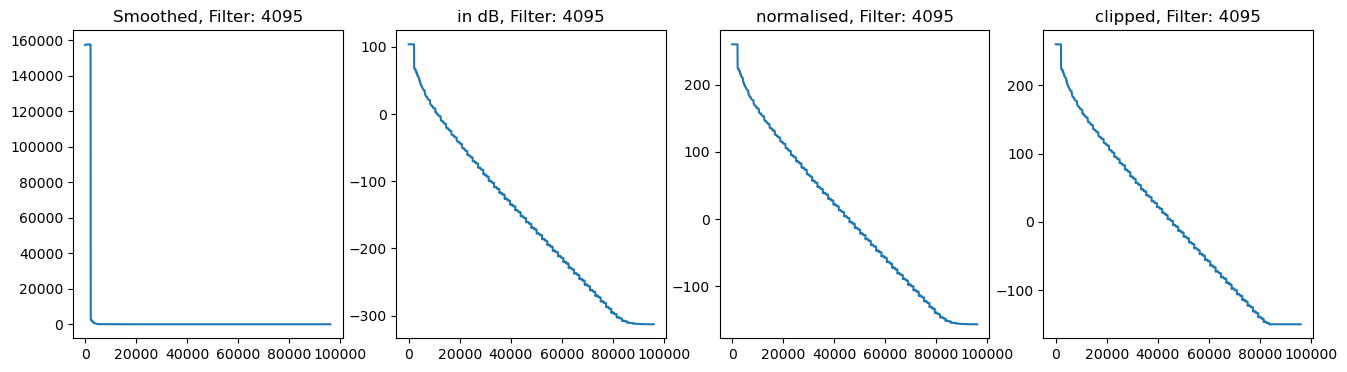

Target params: Kx:-0.10145626217126846, Ky:-0.2689417600631714, KZ:-0.1217874065041542
Inital Params: 

Kx :  tensor([-0.0124], device='cuda:0')
Ky :  tensor([-0.0199], device='cuda:0')
Kz :  tensor([-0.0189], device='cuda:0')
Loss in epoch:0 is : 70.64972686767578
Loss in epoch:100 is : 29.265079498291016
Loss in epoch:200 is : 29.195337295532227
Updated Params: 

Kx :  tensor([-0.0457], device='cuda:0')
Ky :  tensor([-0.0457], device='cuda:0')
Kz :  tensor([-0.0455], device='cuda:0')
Target params: Kx:-0.10145626217126846, Ky:-0.2689417600631714, KZ:-0.1217874065041542
Inital Params: 

Kx :  tensor([-0.0189], device='cuda:0')
Ky :  tensor([-0.0146], device='cuda:0')
Kz :  tensor([-0.0122], device='cuda:0')
Loss in epoch:0 is : 72.08738708496094
Loss in epoch:100 is : 29.12411880493164
Loss in epoch:200 is : 29.196609497070312
Updated Params: 

Kx :  tensor([-0.0458], device='cuda:0')
Ky :  tensor([-0.0458], device='cuda:0')
Kz :  tensor([-0.0456], device='cuda:0')
Target params: Kx:-

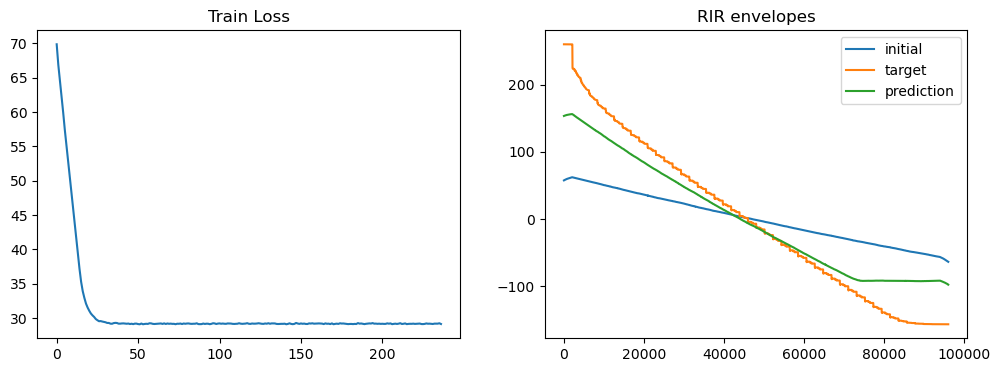

-------------------12th Datapoint out of 14--------------------------


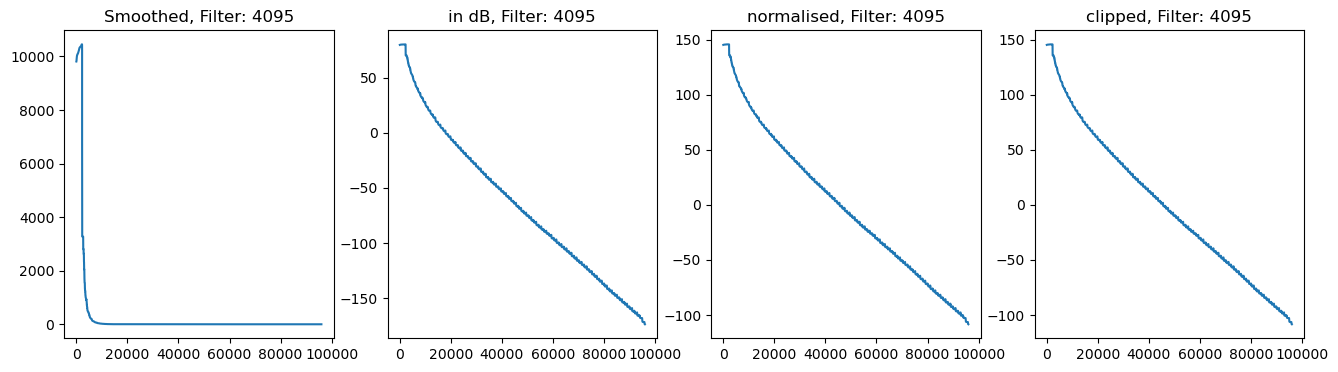

Target params: Kx:-0.10307808220386505, Ky:-0.10485287010669708, KZ:-0.1635342836380005
Inital Params: 

Kx :  tensor([-0.0166], device='cuda:0')
Ky :  tensor([-0.0115], device='cuda:0')
Kz :  tensor([-0.0139], device='cuda:0')
Loss in epoch:0 is : 28.69488525390625
Loss in epoch:100 is : 2.9848930835723877
Loss in epoch:200 is : 2.821721076965332
Updated Params: 

Kx :  tensor([-0.0517], device='cuda:0')
Ky :  tensor([-0.0311], device='cuda:0')
Kz :  tensor([-0.0589], device='cuda:0')


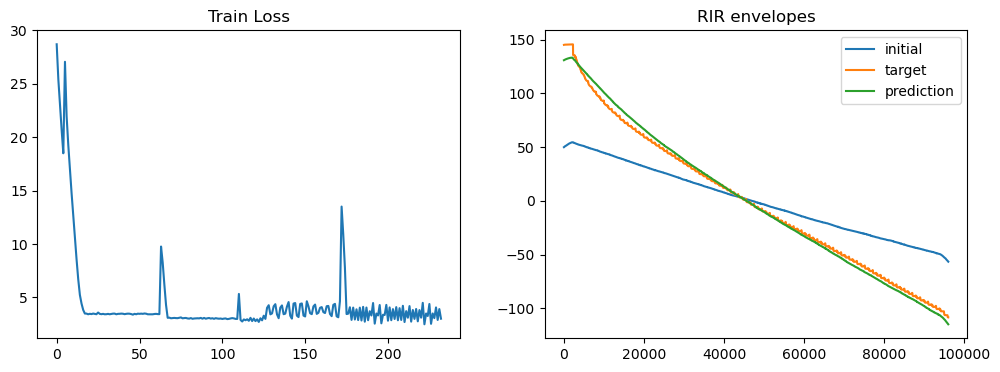

-------------------13th Datapoint out of 14--------------------------


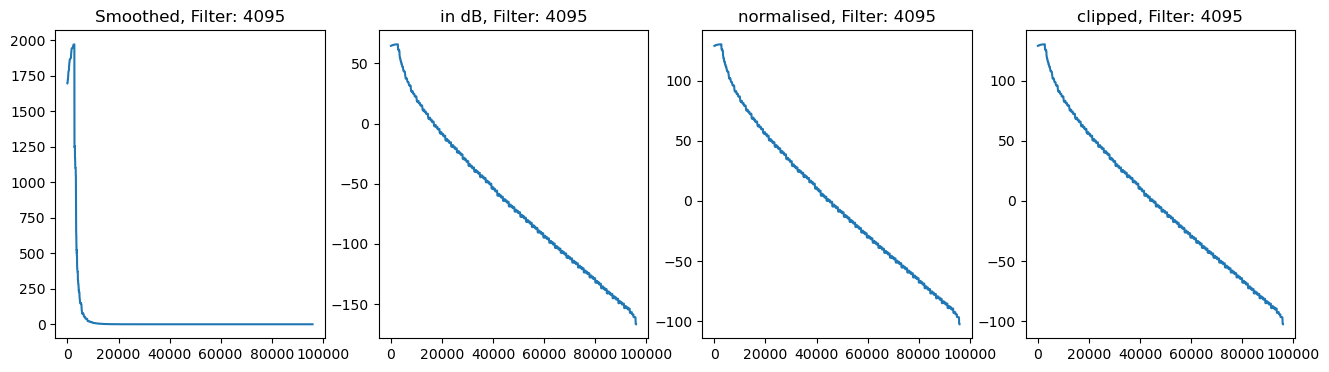

Target params: Kx:-0.10216885060071945, Ky:-0.20455020666122437, KZ:-0.10616428405046463
Inital Params: 

Kx :  tensor([-0.0161], device='cuda:0')
Ky :  tensor([-0.0193], device='cuda:0')
Kz :  tensor([-0.0166], device='cuda:0')
Loss in epoch:0 is : 17.71573257446289
Loss in epoch:100 is : 2.6333768367767334
Loss in epoch:200 is : 4.830245018005371
Updated Params: 

Kx :  tensor([-0.0576], device='cuda:0')
Ky :  tensor([-0.0286], device='cuda:0')
Kz :  tensor([-0.0539], device='cuda:0')


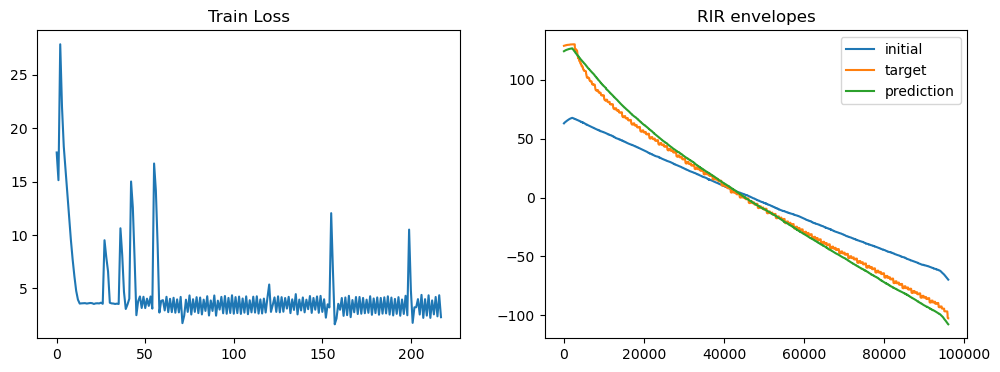

-------------------14th Datapoint out of 14--------------------------


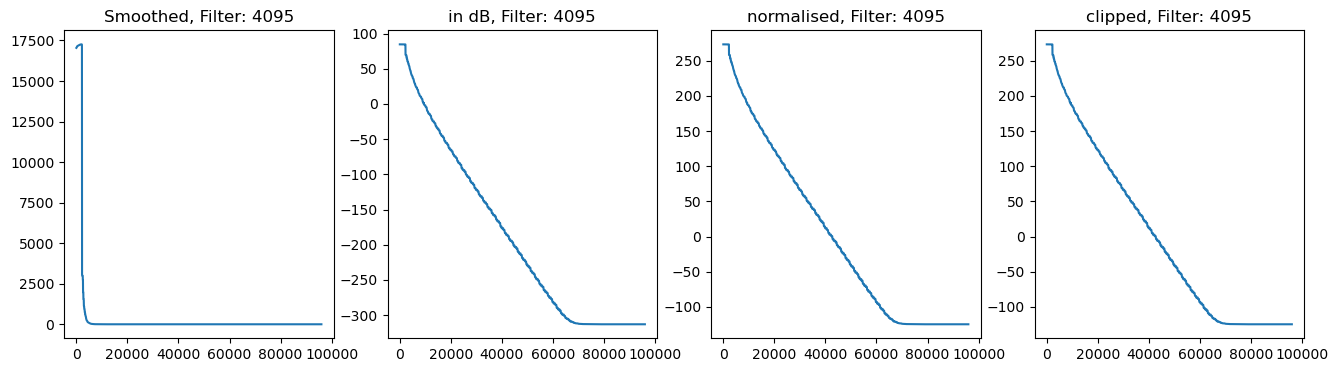

Target params: Kx:-0.16289477050304413, Ky:-0.18823517858982086, KZ:-0.18683433532714844
Inital Params: 

Kx :  tensor([-0.0197], device='cuda:0')
Ky :  tensor([-0.0133], device='cuda:0')
Kz :  tensor([-0.0151], device='cuda:0')
Loss in epoch:0 is : 78.07746124267578
Loss in epoch:100 is : 35.35839080810547
Loss in epoch:200 is : 35.33656692504883
Updated Params: 

Kx :  tensor([-0.0499], device='cuda:0')
Ky :  tensor([-0.0499], device='cuda:0')
Kz :  tensor([-0.0497], device='cuda:0')
Target params: Kx:-0.16289477050304413, Ky:-0.18823517858982086, KZ:-0.18683433532714844
Inital Params: 

Kx :  tensor([-0.0149], device='cuda:0')
Ky :  tensor([-0.0102], device='cuda:0')
Kz :  tensor([-0.0189], device='cuda:0')
Loss in epoch:0 is : 82.0865707397461
Loss in epoch:100 is : 35.36322784423828
Loss in epoch:200 is : 35.35567855834961
Updated Params: 

Kx :  tensor([-0.0499], device='cuda:0')
Ky :  tensor([-0.0499], device='cuda:0')
Kz :  tensor([-0.0497], device='cuda:0')
Target params: Kx:-

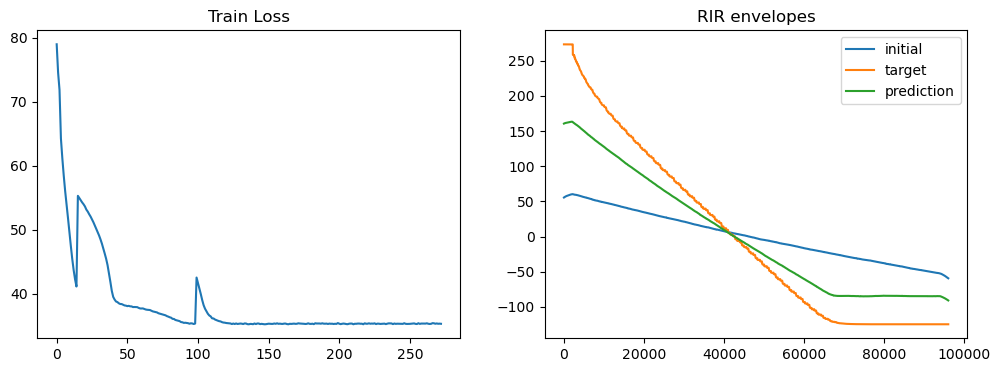

In [34]:
# Generated RIR training - K-model training
# training params
iter_ = 1001
lr = 0.000003
env_filter_len = 4095
signal_gain = 100    # dB
dB_clip = -150
normalise = True
device = 'cuda'
logging_frequency = 100     # epochs  
stopping_criterion = 200    # epochs
accepted_loss = 6       # dB
convergence_trials = 3
# K tensors
rir_data = torch.tensor(rir_np, dtype=torch.float).to(device=device)
# measure target - predicted
# diff_k = 
for i in range(rir_data.size(0)):
    print(f"-------------------{i+1}th Datapoint out of {rir_data.size(0)}--------------------------")
    # for each RIR in dataset
    lengths, betas, rir_ = rir_data[i, :3], rir_data[i, 3:9], rir_data[i, 9:]
    Kx, Ky, Kz = calculate_K(betas, lengths)
    l_env = env_makerF(rir_, filter_len=env_filter_len , gain=signal_gain, clip_=dB_clip, normalise=normalise, display_plots=True, device=device)
    #
    best_param_dict = {}
    not_converged = True
    converge_counter = 0
    while not_converged:
        best_param_dict = {}
        converge_counter += 1
        mod = RIR_model(device=device).to(device=device)
        crit = torch.nn.L1Loss().to(device=device)#.cuda()
        optim = torch.optim.SGD(mod.parameters(),lr=lr)
        print(f"Target params: Kx:{Kx.cpu()}, Ky:{Ky.cpu()}, KZ:{Kz.cpu()}")
        print("Inital Params: \n")
        init_param_dict = {}
        for name, param in mod.named_parameters():
            if param.requires_grad:
                print( name,': ', param.data)
                init_param_dict.update({name: param.data.clone()})


        t_l = []
        early_stopping = 0
        min_loss = torch.inf
        for i in range(iter_):
            optim.zero_grad()
            y_hat = mod.forward()
            x_env = env_makerF(y_hat, filter_len=env_filter_len , gain=signal_gain, clip_=dB_clip, normalise=normalise, device=device)
            l = crit(x_env, l_env)
            # l = torch.mean(torch.abs(x_env - l_env))
            l.backward()
            optim.step()
            log_l = l.detach().cpu()
            t_l.append(log_l)
            # early stopping for convergent cases
            if log_l < min_loss:
                min_loss = log_l
                # save params
                best_param_dict.update({'min_loss': min_loss})
                for name, param in mod.named_parameters():
                    if param.requires_grad:
                        best_param_dict.update({name: param.data.clone()})
            else:
                early_stopping += 1       
            if early_stopping > stopping_criterion: 
                # converge case
                if min_loss < accepted_loss: not_converged=False   
                # tried but not converged  
                if converge_counter >= convergence_trials: not_converged=False
                break
                    
            # log
            if i%logging_frequency == 0 : print(f'Loss in epoch:{i} is : {l.detach()}')

        final_param_dict = {}
        print("Updated Params: \n")
        for name, param in mod.named_parameters():
            if param.requires_grad:
                print( name,': ', param.data)
                final_param_dict.update({name: param.data.clone()})

    #
    plt.figure(1, figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot(t_l,)# linestyle='', marker='.')
    plt.title("Train Loss")
    plt.subplot(1,2,2)
    plt.plot(env_makerF(generate_stochastic_rir(Kx=init_param_dict['Kx'], Ky=init_param_dict['Ky'], Kz=init_param_dict['Kz'],device=device), filter_len=env_filter_len, gain=signal_gain, normalise=normalise,device=device).detach().cpu(), label='initial')
    plt.plot(l_env.detach().cpu(),  label='target')
    plt.plot(env_makerF(mod.forward().detach(), filter_len=env_filter_len, gain=signal_gain, normalise=normalise,device=device).cpu(), label='prediction')
    plt.title("RIR envelopes")
    plt.legend()
    plt.show()

Target Kvalues for band1: (tensor(-0.1022, device='cuda:0'), tensor(-0.2046, device='cuda:0'), tensor(-0.1062, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1400], device='cuda:0')
Ky :  tensor([-0.1490], device='cuda:0')
Kz :  tensor([-0.1220], device='cuda:0')
Loss in epoch:0 is : 36.72010040283203
Loss in epoch:50 is : 35.43159866333008
Loss in epoch:100 is : 32.93264389038086
Loss in epoch:150 is : 26.020200729370117
Loss in epoch:200 is : 2.899810552597046
Loss in epoch:250 is : 2.91369891166687
Loss in epoch:300 is : 2.925325870513916
Loss in epoch:350 is : 2.855381727218628
Loss in epoch:400 is : 2.8683388233184814
Loss in epoch:450 is : 2.8496806621551514
Loss in epoch:500 is : 2.946119546890259
Loss in epoch:550 is : 2.8389525413513184

RIR no:1,
Updated model Params:
Kx :  tensor([-0.1467], device='cuda:0')
Ky :  tensor([-0.1557], device='cuda:0')
Kz :  tensor([-0.0224], device='cuda:0')


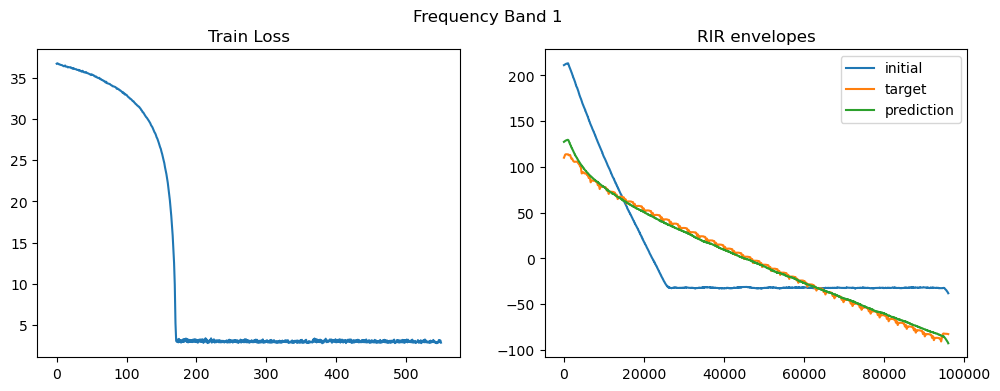

Target Kvalues for band2: (tensor(-0.1022, device='cuda:0'), tensor(-0.2046, device='cuda:0'), tensor(-0.1062, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1400], device='cuda:0')
Ky :  tensor([-0.1630], device='cuda:0')
Kz :  tensor([-0.1770], device='cuda:0')
Loss in epoch:0 is : 37.78005599975586
Loss in epoch:50 is : 36.950443267822266
Loss in epoch:100 is : 35.85757064819336
Loss in epoch:150 is : 34.17387771606445
Loss in epoch:200 is : 30.682369232177734
Loss in epoch:250 is : 3.0374720096588135
Loss in epoch:300 is : 3.1345410346984863
Loss in epoch:350 is : 3.3029048442840576
Loss in epoch:400 is : 3.2139432430267334
Loss in epoch:450 is : 3.273016929626465
Loss in epoch:500 is : 3.3718466758728027
Loss in epoch:550 is : 3.22948956489563

RIR no:2,
Updated model Params:
Kx :  tensor([-0.0251], device='cuda:0')
Ky :  tensor([-0.1683], device='cuda:0')
Kz :  tensor([-0.1819], device='cuda:0')


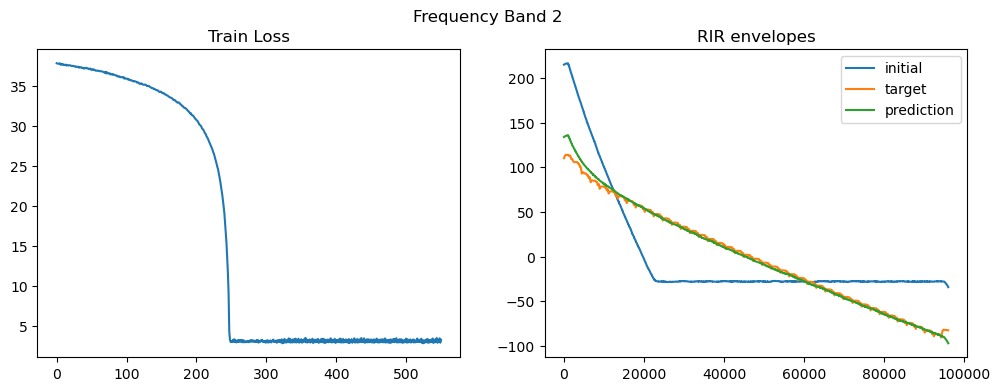

Target Kvalues for band3: (tensor(-0.1022, device='cuda:0'), tensor(-0.2046, device='cuda:0'), tensor(-0.1062, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1550], device='cuda:0')
Ky :  tensor([-0.1140], device='cuda:0')
Kz :  tensor([-0.1480], device='cuda:0')
Loss in epoch:0 is : 35.78822708129883
Loss in epoch:50 is : 33.81663131713867
Loss in epoch:100 is : 29.555992126464844
Loss in epoch:150 is : 2.71524977684021
Loss in epoch:200 is : 2.8935956954956055
Loss in epoch:250 is : 2.851332426071167
Loss in epoch:300 is : 3.0634686946868896
Loss in epoch:350 is : 3.1243133544921875
Loss in epoch:400 is : 3.260852813720703
Loss in epoch:450 is : 2.9933931827545166
Loss in epoch:500 is : 3.044245958328247
Loss in epoch:550 is : 2.705082416534424

RIR no:3,
Updated model Params:
Kx :  tensor([-0.1402], device='cuda:0')
Ky :  tensor([-0.0234], device='cuda:0')
Kz :  tensor([-0.1342], device='cuda:0')


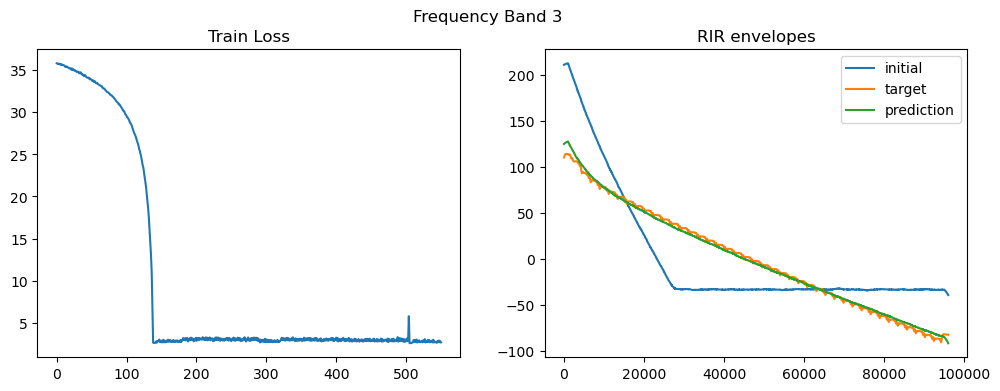

Target Kvalues for band4: (tensor(-0.1022, device='cuda:0'), tensor(-0.2046, device='cuda:0'), tensor(-0.1062, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1190], device='cuda:0')
Ky :  tensor([-0.1530], device='cuda:0')
Kz :  tensor([-0.1240], device='cuda:0')
Loss in epoch:0 is : 36.28681182861328
Loss in epoch:50 is : 35.304054260253906
Loss in epoch:100 is : 32.5493278503418
Loss in epoch:150 is : 23.682687759399414
Loss in epoch:200 is : 2.8235487937927246
Loss in epoch:250 is : 2.8988535404205322
Loss in epoch:300 is : 2.735022783279419
Loss in epoch:350 is : 2.7750370502471924
Loss in epoch:400 is : 3.31453275680542
Loss in epoch:450 is : 2.922431707382202
Loss in epoch:500 is : 2.9539804458618164
Loss in epoch:550 is : 2.9783358573913574

RIR no:4,
Updated model Params:
Kx :  tensor([-0.0250], device='cuda:0')
Ky :  tensor([-0.1735], device='cuda:0')
Kz :  tensor([-0.1400], device='cuda:0')


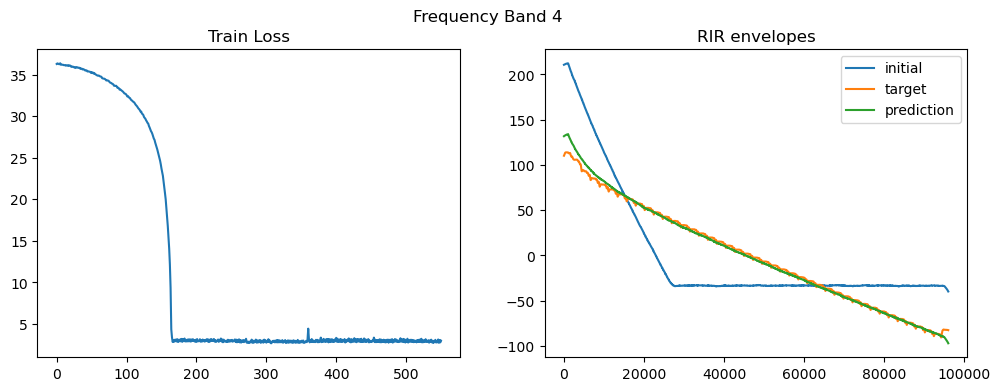

Target Kvalues for band5: (tensor(-0.1022, device='cuda:0'), tensor(-0.2046, device='cuda:0'), tensor(-0.1062, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1520], device='cuda:0')
Ky :  tensor([-0.1580], device='cuda:0')
Kz :  tensor([-0.1460], device='cuda:0')
Loss in epoch:0 is : 38.10050582885742
Loss in epoch:50 is : 37.944576263427734
Loss in epoch:100 is : 37.465362548828125
Loss in epoch:150 is : 36.526344299316406
Loss in epoch:200 is : 35.096927642822266
Loss in epoch:250 is : 32.4336051940918
Loss in epoch:300 is : 24.663612365722656
Loss in epoch:350 is : 2.9166107177734375
Loss in epoch:400 is : 2.861142873764038
Loss in epoch:450 is : 2.8039286136627197
Loss in epoch:500 is : 2.916002035140991
Loss in epoch:550 is : 2.872729778289795

RIR no:5,
Updated model Params:
Kx :  tensor([-0.1563], device='cuda:0')
Ky :  tensor([-0.1650], device='cuda:0')
Kz :  tensor([-0.0221], device='cuda:0')


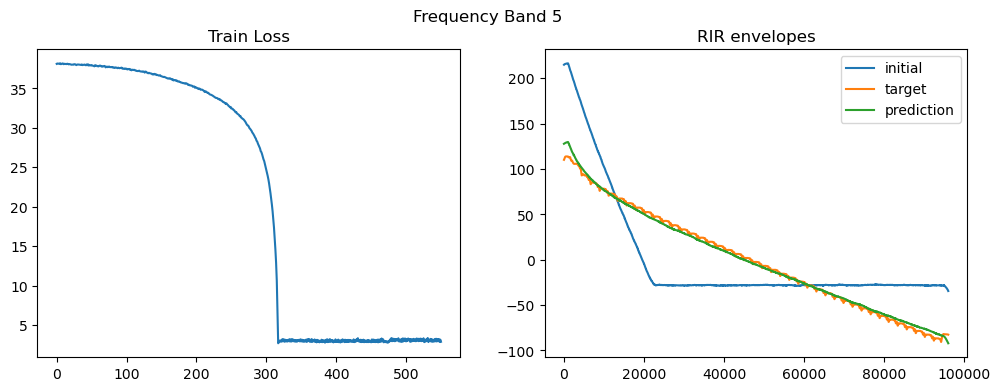

Target Kvalues for band6: (tensor(-0.1022, device='cuda:0'), tensor(-0.2046, device='cuda:0'), tensor(-0.1062, device='cuda:0'))
Initial model Params:
Kx :  tensor([-0.1770], device='cuda:0')
Ky :  tensor([-0.1050], device='cuda:0')
Kz :  tensor([-0.2000], device='cuda:0')
Loss in epoch:0 is : 33.48112487792969
Loss in epoch:50 is : 29.648115158081055
Loss in epoch:100 is : 3.8340744972229004
Loss in epoch:150 is : 3.5574355125427246
Loss in epoch:200 is : 4.079242706298828
Loss in epoch:250 is : 3.9548261165618896
Loss in epoch:300 is : 4.19285249710083
Loss in epoch:350 is : 4.1489057540893555
Loss in epoch:400 is : 3.9926087856292725
Loss in epoch:450 is : 4.078141689300537
Loss in epoch:500 is : 4.173483371734619
Loss in epoch:550 is : 3.707578182220459

RIR no:6,
Updated model Params:
Kx :  tensor([-0.1788], device='cuda:0')
Ky :  tensor([-0.0247], device='cuda:0')
Kz :  tensor([-0.2017], device='cuda:0')


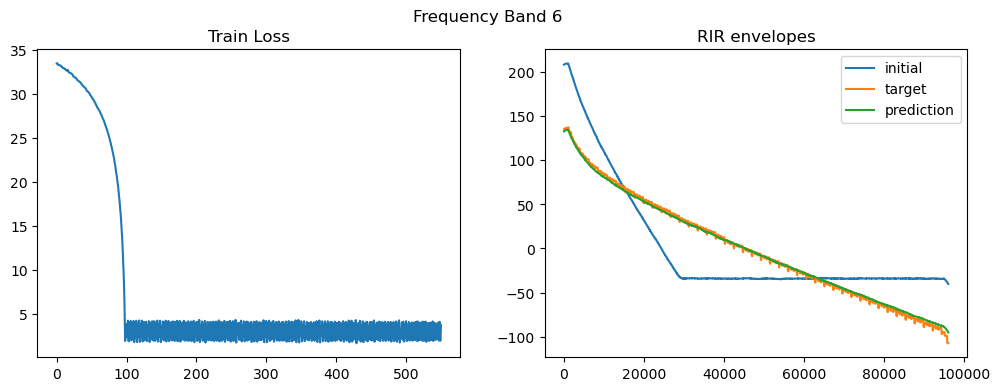

In [14]:
# Frequency Dependent RIR
# training params
iter_ = 551
lr = 0.000003
env_filter_len = 2047
signal_gain = 100    # dB
dB_clip = None
normalize = True
device = 'cuda'

# labels, target_K_values = generate_frequencyRIR(L = torch.tensor([3,4,5]))  # RIR * 6
# For real RIR
rir_data = torch.tensor(rir_np[12,:], dtype=torch.float).to(device=device)
lengths, betas, rir_ = rir_data[:3], rir_data[3:9], rir_data[9:]
labels = rir_bands(rir_, device=device)
target_K_values = calculate_K(betas, lengths)
#print("Target: ", target_K_values)
nBands = labels.size(1)
k_array = torch.zeros((nBands, 3)).to(device=device)
#
for j in range(nBands):
    # for each frequency band
    print(f"Target Kvalues for band{j+1}: {target_K_values[:]}")
    l_env = env_makerF(labels[:, j], filter_len=env_filter_len , gain=signal_gain, clip_=dB_clip, normalise=normalize,device=device)#.float().requires_grad_().cuda()
    mod = RIR_model(device=device).to(device=device)#.cuda()
    crit = torch.nn.L1Loss().to(device=device)#.cuda()
    optim = torch.optim.SGD(mod.parameters(),lr=lr)
    init_param_dict = {}
    print("Initial model Params:")
    for name, param in mod.named_parameters():
        if param.requires_grad:
            print( name,': ', param.data)
            init_param_dict.update({name:param.data.clone()})

    t_l = []
    for i in range(iter_):
        optim.zero_grad()
        y_hat = mod.forward()
        x_env = env_makerF(y_hat, filter_len=env_filter_len , gain=signal_gain, clip_=dB_clip, normalise=normalize,device=device)
        # l = crit(labels, y_hat)
        l = crit(x_env, l_env)
        # l = torch.mean(torch.abs(x_env - l_env))
        l.backward()
        optim.step()
        t_l.append(l.detach().cpu())
        if i%50 == 0 : print(f'Loss in epoch:{i} is : {l.detach()}')
    

    print(f"\nRIR no:{j+1},\nUpdated model Params:")
    final_param_collector = torch.zeros((1)).to(device=device)
    for name, param in mod.named_parameters():
        if param.requires_grad:
            print( name,': ', param.data)
            final_param_collector = torch.concat((final_param_collector, param.data.view(-1)))
    final_param_collector = final_param_collector[1:]
    k_array[j, :] = final_param_collector

#   
    # print(param_dict)
    plt.figure(j+1, figsize=(12,4))
    plt.suptitle(f"Frequency Band {j+1}")
    plt.subplot(1,2,1)
    plt.plot(t_l,)# linestyle='', marker='.')
    plt.title("Train Loss")
    plt.subplot(1,2,2)
    plt.plot(env_makerF(generate_stochastic_rir(Kx=init_param_dict['Kx'], Ky=init_param_dict['Ky'], Kz=init_param_dict['Kz'], device=device), filter_len=env_filter_len, gain=signal_gain, clip_=dB_clip, normalise=normalize,device=device).detach().cpu(), label='initial')
    plt.plot(l_env.detach().cpu(),  label='target')
    plt.plot(env_makerF(mod.forward().detach(), filter_len=env_filter_len, gain=signal_gain, clip_=dB_clip, normalise=normalize,device=device).detach().cpu(), label='prediction')
    plt.title("RIR envelopes")
    plt.legend()
    plt.show()
    

Target params: Kx:-0.02199999988079071, Ky:-0.01600000075995922, KZ:-0.012000000104308128
Target params Deltas: del_Kx:-0.02199999988079071, del_Ky:0.0059999991208314896, del_KZ:0.0040000006556510925
Inital Params: 

del_Kx :  tensor(-0.0177)
del_Ky :  tensor(0.0004)
del_Kz :  tensor(0.0068)
Loss in epoch:0 is : 2.174394130706787
Loss in epoch:25 is : 0.46765968203544617
Loss in epoch:50 is : 0.6256166100502014
Loss in epoch:75 is : 1.1087685823440552
Loss in epoch:100 is : 0.5257464051246643
Loss in epoch:125 is : 1.8178642988204956
Loss in epoch:150 is : 0.43430882692337036
Loss in epoch:175 is : 0.42982858419418335
Loss in epoch:200 is : 0.44066423177719116
Updated Params: 

del_Kx :  tensor(-0.0188)
del_Ky :  tensor(-1.9205e-05)
del_Kz :  tensor(0.0069)
Kx:  tensor(-0.0188)
Ky:  tensor(-0.0188)
Kz:  tensor(-0.0119)


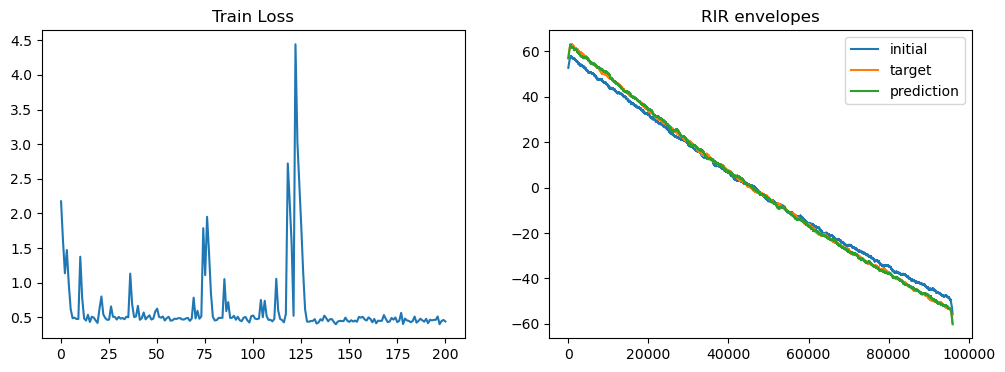

In [10]:
# delta K's model training
# training params
iter_ = 201
lr = 0.0000001
env_filter_len = 1023
signal_gain = 100    # dB
dB_clip = None
normalize = True
# K tensors
Kx=torch.tensor(-0.022) 
Ky=torch.tensor(-0.016)
Kz=torch.tensor(-0.012)
kes = torch.sort(torch.cat([Kx.view(-1), Ky.view(-1), Kz.view(-1)]))[0]
del_Kx = kes[0]
del_Ky = kes[1] - kes[0]
del_Kz = kes[2] - kes[1]
labels = generate_stochastic_rir_del(del_Kx=del_Kx, del_Ky=del_Ky, del_Kz=del_Kz)
l_env = env_makerF(labels, filter_len=env_filter_len , gain=signal_gain, clip_=dB_clip, normalise=normalize, )#.float().requires_grad_().cuda()
#
mod = RIR_model2()#.cuda()
crit = torch.nn.MSELoss()#.cuda()
optim = torch.optim.SGD(mod.parameters(),lr=lr)
print(f"Target params: Kx:{np.round(Kx.numpy(), 4)}, Ky:{Ky}, KZ:{Kz}")
print(f"Target params Deltas: del_Kx:{del_Kx}, del_Ky:{del_Ky}, del_KZ:{del_Kz}")
print("Inital Params: \n")

init_param_dict = {}
for name, param in mod.named_parameters():
    if param.requires_grad:
        print( name,': ', param.data)
        init_param_dict.update({name: param.data.clone()})

init_Kx = init_param_dict['del_Kx']
init_Ky = init_param_dict['del_Ky'] + init_param_dict['del_Kx']
init_Kz = init_param_dict['del_Kz'] + init_param_dict['del_Ky']+ init_param_dict['del_Kx']
# plt.figure(1)
# plt.plot(labels)
# #plt.show()
# y_env = env_maker0(labels)
# plt.figure(2)
# plt.plot(y_env)
# plt.show()


t_l = []
for i in range(iter_):
    optim.zero_grad()
    y_hat = mod.forward()
    x_env = env_makerF(y_hat, filter_len=env_filter_len , gain=signal_gain, clip_=dB_clip, normalise=normalize)
    # l = crit(labels, y_hat)
    #l = crit(x_env, l_env)
    l = torch.mean(torch.abs(x_env - l_env))
    l.backward()
    optim.step()
    t_l.append(l.detach().cpu())
    if i%25 == 0 : print(f'Loss in epoch:{i} is : {l.detach()}')

final_param_dict = {}
print("Updated Params: \n")
for name, param in mod.named_parameters():
    if param.requires_grad:
        print( name,': ', param.data)
        final_param_dict.update({name: param.data.clone()})
# print params
print("Kx: ", final_param_dict['del_Kx'])
print("Ky: ", final_param_dict['del_Ky'] + final_param_dict['del_Kx'])
print("Kz: ", final_param_dict['del_Kz'] + final_param_dict['del_Ky']+ final_param_dict['del_Kx'])
#
plt.figure(1, figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(t_l,)# linestyle='', marker='.')
plt.title("Train Loss")
plt.subplot(1,2,2)
plt.plot(env_makerF(generate_stochastic_rir_del(del_Kx=init_param_dict['del_Kx'], del_Ky=init_param_dict['del_Ky'], del_Kz=init_param_dict['del_Kz']), filter_len=env_filter_len, gain=signal_gain, clip_=dB_clip, normalise=normalize), label='initial')
# plt.plot(env_makerF(generate_stochastic_rir(Kx=init_Kx, Ky=init_Ky, Kz=init_Kz), filter_len=env_filter_len, gain=signal_gain, clip_=dB_clip, normalise=normalize), label='initial')
plt.plot(l_env,  label='target')
plt.plot(env_makerF(mod.forward().detach(), filter_len=env_filter_len, gain=signal_gain, clip_=dB_clip, normalise=normalize), label='prediction')
plt.title("RIR envelopes")
plt.legend()
plt.show()

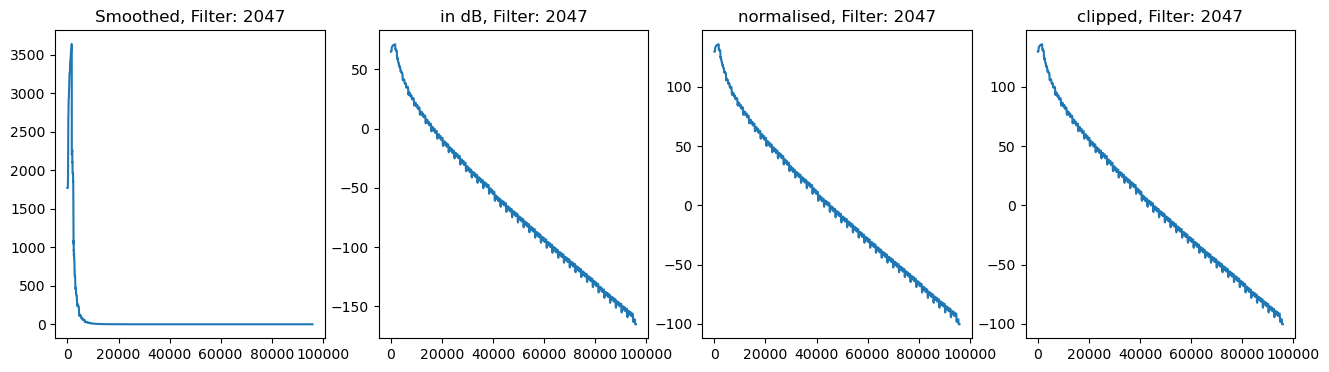

Target params: Kx:-0.10220000147819519, Ky:-0.20455020666122437, KZ:-0.10616428405046463
Inital Params: 

Kx :  tensor([-0.0144], device='cuda:0')
Ky :  tensor([-0.0183], device='cuda:0')
Kz :  tensor([-0.0105], device='cuda:0')
Loss in epoch:0 is : 24.90944480895996
Loss in epoch:100 is : 3.1029491424560547
Loss in epoch:200 is : 2.217106342315674
Loss in epoch:300 is : 1.994343876838684
Loss in epoch:400 is : 1.972080111503601
Loss in epoch:500 is : 1.970826268196106
Updated Params: 

Kx :  tensor([-0.0433], device='cuda:0')
Ky :  tensor([-0.0464], device='cuda:0')
Kz :  tensor([-0.0252], device='cuda:0')


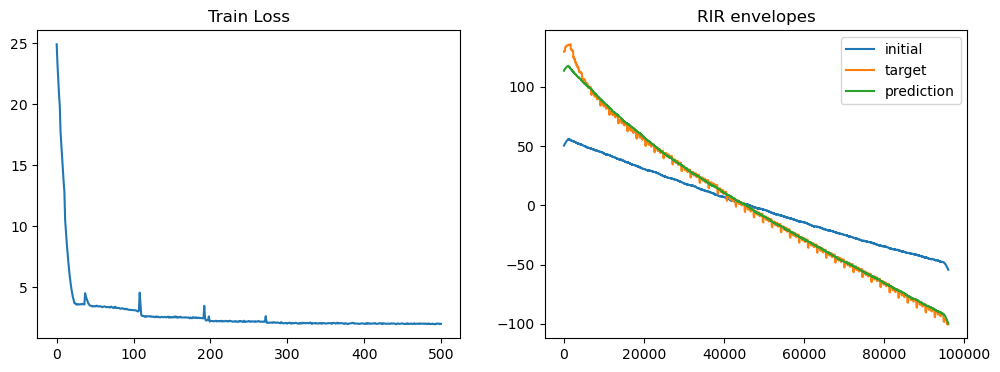

In [33]:
# K's model training
# training params
iter_ = 501
lr = 0.000001
env_filter_len = 2047
signal_gain = 100    # dB
dB_clip1 = None
normalise = True
device = 'cuda'
# K tensors
Kx=torch.tensor(-0.019).to(device=device)
Ky=torch.tensor(-0.021).to(device=device)
Kz=torch.tensor(-0.012).to(device=device)
# labels = generate_stochastic_rir(Kx=Kx,Ky=Ky,Kz=Kz, device=device).cuda()
# l_env = env_makerF(labels, filter_len=env_filter_len , gain=signal_gain, clip_=dB_clip, normalise=normalise, display_plots=True, device=device)#.float().requires_grad_().cuda()
rir_data = torch.tensor(rir_np[12,:], dtype=torch.float).cuda()
Kx, Ky, Kz = calculate_K(rir_data[3:9], rir_data[:3])
l_env = env_makerF(rir_data[9:], filter_len=env_filter_len , gain=signal_gain, clip_=dB_clip1, normalise=normalise, display_plots=True, device=device)#.cuda()
#
# mod = RIR_model(Kx=-0.0709, Ky =-0.0709, Kz= -0.0253)#.cuda()
Kx_i =  torch.tensor([-0.1520])
Ky_i =  torch.tensor([-0.1550])
Kz_i =  torch.tensor([-0.1610])
# mod = RIR_model(Kx=-0.1520,Ky=-0.1550,Kz=-0.1610,device=device).cuda()
mod = RIR_model(device=device).to(device=device)#.cuda()
crit = torch.nn.L1Loss().to(device=device)#.cuda()
optim = torch.optim.SGD(mod.parameters(),lr=lr)
print(f"Target params: Kx:{np.round(Kx.cpu().numpy(), 4)}, Ky:{Ky.cpu()}, KZ:{Kz.cpu()}")
print("Inital Params: \n")
init_param_dict = {}
for name, param in mod.named_parameters():
    if param.requires_grad:
        print( name,': ', param.data)
        init_param_dict.update({name: param.data.clone()})
# plt.figure(1)
# plt.plot(labels)
# #plt.show()
# y_env = env_maker0(labels)
# plt.figure(2)
# plt.plot(y_env)
# plt.show()


t_l = []
for i in range(iter_):
    optim.zero_grad()
    y_hat = mod.forward()
    x_env = env_makerF(y_hat, filter_len=env_filter_len , gain=signal_gain, clip_=dB_clip1, normalise=normalise, device=device)#.cuda()
    # l = crit(labels, y_hat)
    l = crit(x_env, l_env)
    # l = torch.mean(torch.abs(x_env - l_env))
    if i%100 == 0 : print(f'Loss in epoch:{i} is : {l.detach()}')
    l.backward()
    optim.step()
    t_l.append(l.detach().cpu())
    

final_param_dict = {}
print("Updated Params: \n")
for name, param in mod.named_parameters():
    if param.requires_grad:
        print( name,': ', param.data)
        final_param_dict.update({name: param.data.clone()})


#
plt.figure(1, figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(t_l,)# linestyle='', marker='.')
plt.title("Train Loss")
plt.subplot(1,2,2)
plt.plot(env_makerF(generate_stochastic_rir(Kx=init_param_dict['Kx'], Ky=init_param_dict['Ky'], Kz=init_param_dict['Kz'], device=device), filter_len=env_filter_len, gain=signal_gain, clip_=dB_clip1, normalise=normalise, device=device).detach().cpu(), label='initial')
plt.plot(l_env.detach().cpu(),  label='target')
plt.plot(env_makerF(mod.forward().detach(), filter_len=env_filter_len, gain=signal_gain,clip_=dB_clip1,  normalise=normalise, device=device).detach().cpu(), label='prediction')
plt.title("RIR envelopes")
plt.legend()
plt.show()

mod.cpu()
crit.cpu()
torch.cuda.empty_cache()

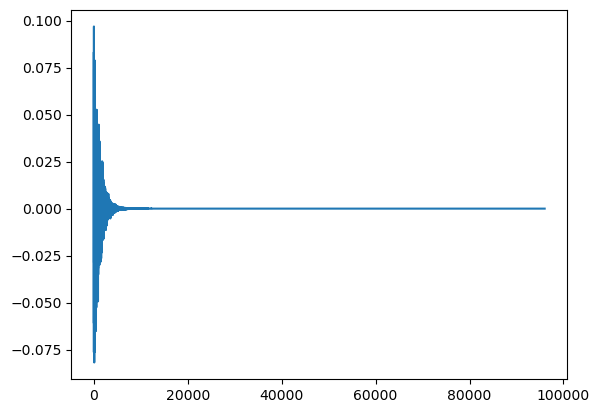

In [55]:
plt.plot(generate_stochastic_rir(Kx=init_param_dict['Kx'], Ky=init_param_dict['Ky'], Kz=init_param_dict['Kz'], device=device).detach().cpu(), label='initial')

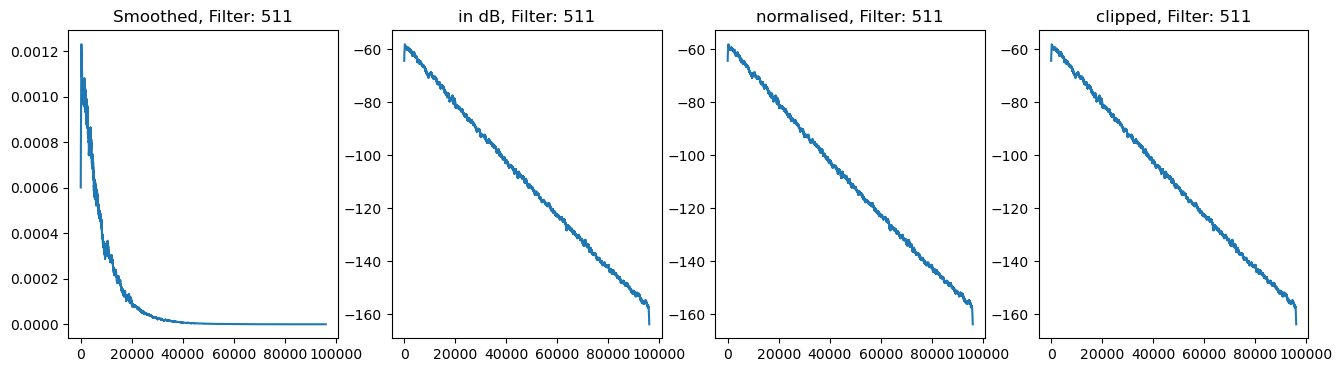

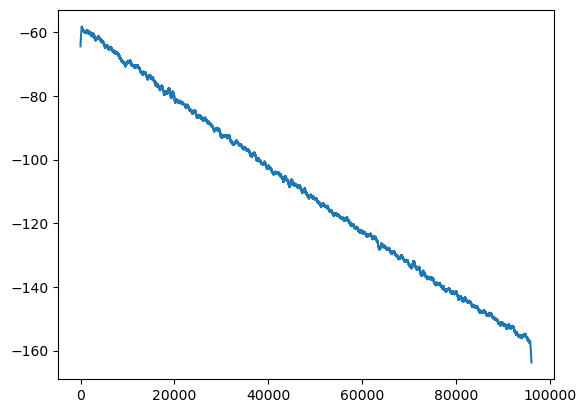

In [31]:
xx  = env_makerF(generate_stochastic_rir(Kx=init_param_dict['Kx'], Ky=init_param_dict['Ky'], Kz=init_param_dict['Kz'], device=device), filter_len=511, gain=0, clip_=-200, normalise=False,device=device, display_plots=True)
plt.plot(xx.detach().cpu(), label='initial')

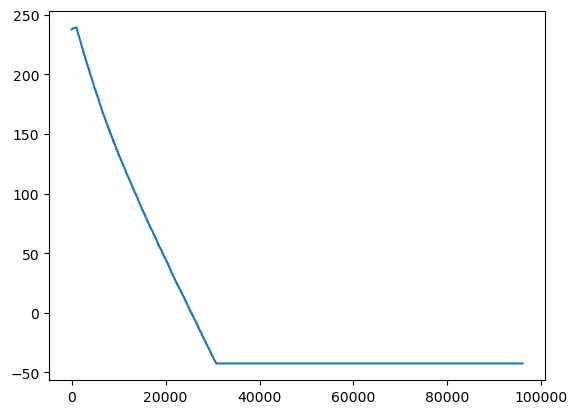

In [98]:
plt.plot(xx-torch.mean(xx))

In [ ]:
# check anomaly 
torch.autograd.set_detect_anomaly(True) 

mod = RIR_model()
# hndd = mod.register_full_backward_hook(backward_hook)
labels = generate_stochastic_rir(Kx=torch.tensor(-0.012),Ky=torch.tensor( -0.016),Kz=torch.tensor( -0.018))
optim = torch.optim.Adam(mod.parameters(), lr=0.001)
# for i in range(3):
for name, param in mod.named_parameters():
    if param.requires_grad:
        print( name,': ', param.data)
optim.zero_grad()
y = mod.forward()
# y.register_hook(lambda t: print(f'hook0 : {t}'))
l = torch.abs((labels - y)).sum()
# P = l.register_hook(lambda t: print(f'hook1 : {t}'))
print("lossValue: ", l)
l.retain_grad()
l.backward()

#print('Tracing back tensors:')
optim.step()

# hndd.remove()
# make_dot(y, params=dict(mod.named_parameters()))


In [ ]:
# Print model graph
model = nn.Sequential()
model.add_module('W0', nn.Linear(8, 16))
model.add_module('tanh', nn.Tanh())
model.add_module('W1', nn.Linear(16, 1))

x = torch.randn(1, 8)
with torch.autograd.graph.saved_tensors_hooks(pack_hook, unpack_hook):
    y = model(x)


make_dot(y.mean(), params=dict(model.named_parameters()))

## Part for SGD basics

### A. Gradient descent for finding the minima of a function
1. We have a function $y=f(x)=x²$, and we want to find the minima of that function.<br>
2. we take a starting guess $x_0$ in the available range. <br>
3. Then we evaluate $\frac{d}{dx}f(x)|_{x=x_0}$ and update $x_0 = x_0 - \alpha\frac{d}{dx}f(x)|_{x=x_0}$,<br>
where $\alpha$ is the learning rate
4. We continue reiterating untill $\frac{d}{dx}f(x)\approxeq0$
   
N.B : 
1. The function f has to continously differentiable to apply GD
2. The function needs to be concave/convex to find global minima

### B. Gradient descent for finding inverse of a funciton / <br> Model the inverse of any unknown function

1. We have $y=f(x)$ where f can be any function
2. We want to find $g(y)=f^{-1}(y)$ , such that for any y, we can find<br>
    corresponding $\hat{x}=g(y)$
3. For this we take a NN model and optimize it using GD to achieve $\hat{x}\approxeq x$
4. Then the trained NN model is $\approxeq f^{-1}$  

In [ ]:
# Dummy Model train
torch.autograd.set_detect_anomaly(True) 
def gen_mul(a, x):
    return a*x
def gen_add(b, x):
    return x + b

class func_NN(torch.nn.Module):
    def __init__(self,) :
        super().__init__()
        self.a = torch.nn.Parameter(torch.rand(1))
        self.b = torch.nn.Parameter(torch.rand(1))
        #self.x = torch.nn.Parameter(torch.linspace(-1, 1, 100))
        # self.x = torch.linspace(-1, 1, 10)

    def forward(self, inp):
        # mul_x = torch.cos(self.a.view(-1,1)*inp)
        mul_x = gen_mul(self.a.view(-1,1), inp)
        # sum_x = mul_x - self.b
        sum_x = gen_add(self.b, mul_x)
        if sum_x.requires_grad : sum_x.register_hook(lambda x : print("sumx", x, sum_x.grad_fn))
        #return mul_x
        return sum_x
        # return mul_x + b
        #return generate_stochasticRIR(L=(), K=())
def pack_hook(x):
    # print("Packing", x)
    return x

def unpack_hook(x):
    # print("Unpacking", x)
    return x

# label
a = torch.Tensor([0.5])
b = torch.Tensor([0.8])
x = torch.linspace(-1, 1, 10)
y = gen_add(b, gen_mul(a,x)) + (0.1**0.5)*torch.randn_like(x)*(0.1)
# y = torch.cos(a*x) + (0.1**0.5)*torch.randn_like(x)*(0.001) + b
inp = x
foo = func_NN()
# hnd = foo.register_full_backward_hook(backward_hook)
print("inint model")
for name, param in foo.named_parameters():
    if param.requires_grad:
        print( name,': ', param.data)
loss = torch.nn.MSELoss()
optim = torch.optim.Adam(foo.parameters(),lr=0.001)

t_l = []
for i in range(2):
    # print(f'#######\n ##Epoch:{i} \n #######')
    # for name, param in foo.named_parameters():
    #     if param.requires_grad:
    #         print( name,': ', param.data)
    # with torch.autograd.graph.saved_tensors_hooks(pack_hook, unpack_hook):
    optim.zero_grad()
    l = loss(y, foo.forward(inp=inp))
    # l.retain_grad()
    # l.register_hook(print)
    # print('L:',l)
    
    l.backward()
    # print('Tracing back tensors:')
    # getBack(l.grad_fn)
    optim.step()
    t_l.append(l.detach())
# hnd.remove()

print("Final Loss: ", loss(y, foo.forward(inp)).detach())
print('Parameters: \n', 'Original: a:', a, ' b: ',b, '\n Predicted: ')

for name, param in foo.named_parameters():
    if param.requires_grad:
        print( name,': ', param.data)
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.xlabel("Epochs Trained")
plt.ylabel("Train Loss")
plt.plot(t_l)
plt.yscale('log')
#print(func_NN.parameters())
plt.subplot(1,2,2)
plt.plot(x, y.squeeze(), linestyle='', marker='v', label='labels')
plt.plot(x, foo.forward(inp=inp).detach().squeeze(), linestyle='', marker='.', label='preds')
plt.xlabel("Value of Y")
plt.ylabel("Value of X")
plt.legend()


In [ ]:
y = foo(inp)
make_dot(y, params=dict(foo.named_parameters()))

In [ ]:
## A part

# define function and df
def f(x):
   return x**2 - 4*x + 6

def df(x):
   return 2*x - 4


# params
initial_x = 4
learning_rate = 0.1
num_iterations = 50
history_x = [initial_x]

# finding minima
x = initial_x
for i in range(num_iterations):
   gradient = df(x)
   x = x - learning_rate * gradient
   history_x.append(x)

# plot
x_vals = np.linspace(-1, 5, 100)
plt.plot(x_vals, f(x_vals))
plt.plot(history_x, f(np.array(history_x)), 'rx')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Gradient Descent')
plt.show()

In [ ]:
## B part

# Creating a function f(X) with a slope of -5
X = torch.arange(-5, 5, 0.1).view(-1, 1)
func =  -2*X**2 + 5

# Adding Gaussian noise to the function f(X) and saving it in Y
Y = func + 0.9 * torch.randn(X.size())


# defining the function for forward pass for prediction
def forward(x):
    return w * x + b

# evaluating data points with Mean Square Error (MSE)
def criterion(y_pred, y):
    return torch.mean((y_pred - y) ** 2)

# Batch gradient descent
w = torch.tensor(-10.0, requires_grad=True)
b = torch.tensor(-20.0, requires_grad=True)
step_size = 0.1
loss_BGD = []
n_iter = 50

for i in range (n_iter):
    # making predictions with forward pass
    Y_pred = forward(X)
    # calculating the loss between original and predicted data points
    loss = criterion(Y_pred, Y)
    # storing the calculated loss in a list
    loss_BGD.append(loss.item())
    # backward pass for computing the gradients of the loss w.r.t to learnable parameters
    loss.backward()
    # updateing the parameters after each iteration
    w.data = w.data - step_size * w.grad.data
    b.data = b.data - step_size * b.grad.data
    # zeroing gradients after each iteration
    w.grad.data.zero_()
    b.grad.data.zero_()
    # priting the values for understanding
    print('{}, \t{}, \t{}, \t{}'.format(i, loss.item(), w.item(), b.item()))

# # Stochastic gradient descent
# w = torch.tensor(-10.0, requires_grad=True)
# b = torch.tensor(-20.0, requires_grad=True)
# step_size = 0.1
# loss_SGD = []
# n_iter = 20

# for i in range(n_iter):  
#     # calculating true loss and storing it
#     Y_pred = forward(X)
#     # store the loss in the list
#     loss_SGD.append(criterion(Y_pred, Y).tolist())

#     for x, y in zip(X, Y):
#       # making a pridiction in forward pass
#       y_hat = forward(x)
#       # calculating the loss between original and predicted data points
#       loss = criterion(y_hat, y)
#       # backward pass for computing the gradients of the loss w.r.t to learnable parameters
#       loss.backward()
#       # updateing the parameters after each iteration
#       w.data = w.data - step_size * w.grad.data
#       b.data = b.data - step_size * b.grad.data
#       # zeroing gradients after each iteration
#       w.grad.data.zero_()
#       b.grad.data.zero_()
#       # priting the values for understanding
#       print('{}, \t{}, \t{}, \t{}'.format(i, loss.item(), w.item(), b.item()))

X = X.detach()
w = w.detach().item()
b = b.detach().item()
print(w, b)
# Plot and visualizing the data points in blue
plt.plot(X.numpy(), Y.numpy(), 'b+', label='Y')
plt.plot(X.numpy(), func.numpy(), 'r', label='func')
plt.plot(X, (w*X)+b, label='preds')
#plt.plot(*X.numpy()+b.detach().numpy(), label="prediction")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid('True', color='y')
plt.show()


# Plot graphs
plt.plot(loss_BGD, label="Batch Gradient Descent")
plt.xlabel('Epoch')
plt.ylabel('Cost/Total loss')
plt.legend()
plt.show()

# plt.plot(loss_SGD,label="Stochastic Gradient Descent")
# plt.xlabel('Epoch')
# plt.ylabel('Cost/Total loss')
# plt.legend()
# plt.show()